# Practical Machine Learning for Physicists
## Week 6 Exercise
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [ ]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2


In [ ]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [ ]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


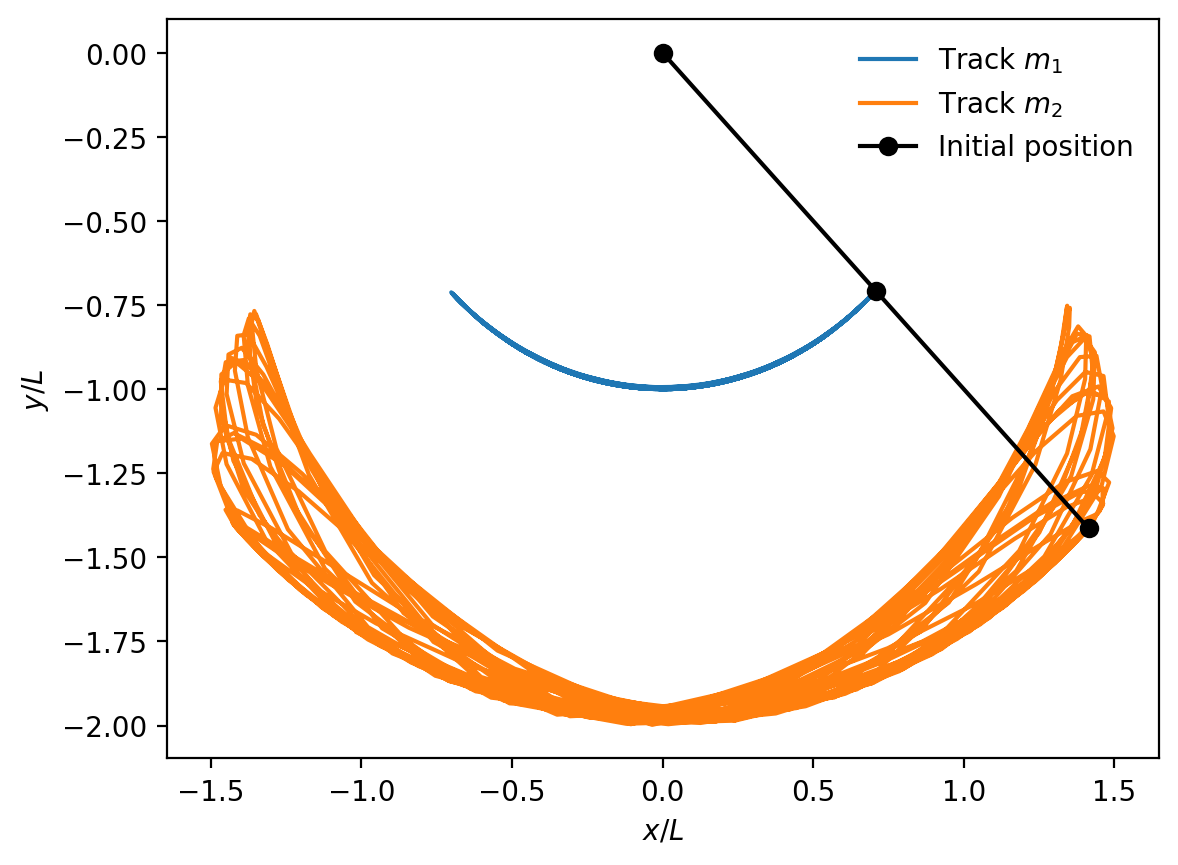

In [ ]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



# 1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.

In [ ]:
def shapeArray(array,windowsize,offset):
    ''' This function splits up a 1-d array x into a series of overlapping windows
    The return is a tuple of the array of input windows and target (label) windows'''
    inputs = np.array([array[i : i + windowsize] for i in range(len(array)-(windowsize+offset)+1)])
    targets = np.array([array[i +windowsize : i+ windowsize+offset] for i in range(len(array)-(windowsize+offset)+1)])
    return (inputs,targets)

In [ ]:
def stability(i,j):
    '''
    Inputs:
    i & j which are variables that affect the initial conditions
    Outputs:
    The plots of x and y against time
    The values of x1,y1,x2,y2
    '''

    ###Changing the initial conditions and running rhs function again###
    #Choosing the angles
    z0=[i,j,i,j]

    #Time ranges
    tmax, dt = 50, 0.1
    t = np.arange(0, tmax+dt, dt)

    #Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y

    #Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

    return x1, y1, x2, y2



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


The final cost for training data is 0.0011823107488453388


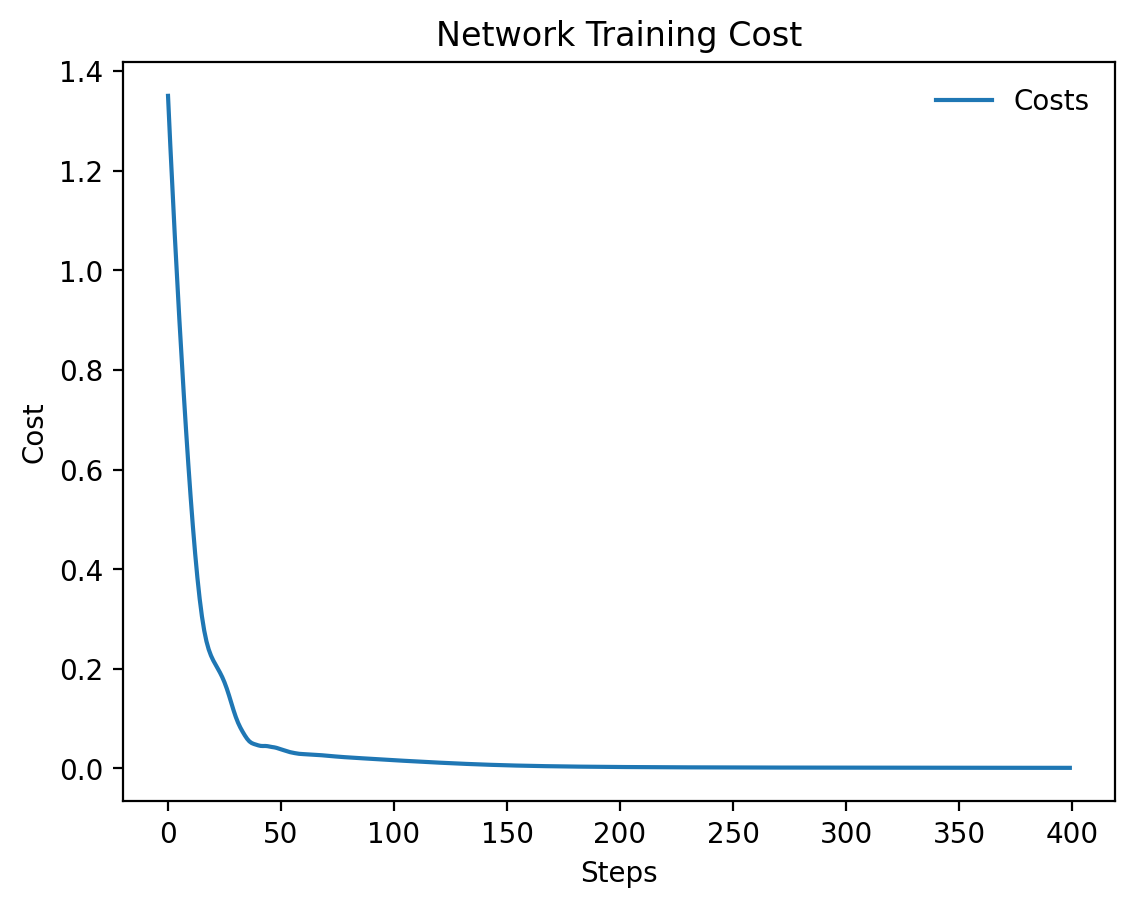

In [ ]:
def build_model(x1, x2, y1, y2, windowsize, offset,steps):

    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(50, input_shape=(None, 4), return_sequences=False))  # LSTM layer with 50 neurons
    model.add(keras.layers.Dense(4, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    # Stack coordinates such that we have an array of the coordinate of all coordinates at each time step
    xy = np.stack((x1,y1,x2,y2), axis = 1)

    # Reshape the data into (batchsize, timesteps, data)
    xyInput, xyLabel = shapeArray(xy, windowsize, offset)

    # Create training sample only including up to t0( windowsize*dt)
    xyTrain  = xyInput[:windowsize]

    # Create training target only including up to t0( windowsize*dt), and last time step in label batch
    xyTarget = xyLabel[:windowsize,-1]

    # Empty array for cost along each step
    costs = np.zeros(steps)

    for i in tqdm(range(steps)):
        # Train the network and append to 'costs' empty array
        costs[i] = model.train_on_batch(xyTrain, xyTarget)

    # Test data includes whole data range beyond window size
    xyTest = xyInput

    predictions = model.predict_on_batch(xyTest)

    # Retrieve predicted coordinates from predicted array
    x1_hat, y1_hat = predictions[:,0], predictions[:,1]
    x2_hat, y2_hat = predictions[:,2], predictions[:,3]

    # Plot costs vs steps
    fig, ax = plt.subplots()
    ax.plot(np.arange(steps), costs, label=r"Costs")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cost")
    ax.set_title("Network Training Cost")
    ax.legend()
    print("The final cost for training data is", costs[-1])

    return costs, (x1_hat, y1_hat, x2_hat, y2_hat)

costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model(x1, x2, y1, y2, 30, 20, 400)


# 2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

In [ ]:
def timePlot(x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat,windowsize,offset):

    # Define smaller figsize
    small_figsize = (8, 6)

    # Plotting x1 and y1
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(t, x1, label='Real - x1', color='blue')
    plt.plot(t[windowsize+offset-1:], x1_hat, label='Predicted - x1', color='red')
    plt.title('Real vs Predicted Trajectories for x1')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(t, y1, label='Real - y1', color='green')
    plt.plot(t[windowsize+offset-1:],  y1_hat, label='Predicted - y1', color='purple')
    plt.title('Real vs Predicted Trajectories for y1')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()

    # Plotting x2 and y2
    plt.subplot(2, 2, 3)
    plt.plot(t, x2, label='Real - x2', color='blue')
    plt.plot(t[windowsize+offset-1:], x2_hat, label='Predicted - x2', color='red')
    plt.title('Real vs Predicted Trajectories for x2')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(t, y2, label='Real - y2', color='green')
    plt.plot(t[windowsize+offset-1:], y2_hat, label='Predicted - y2', color='purple')
    plt.title('Real vs Predicted Trajectories for y2')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()

    plt.tight_layout()
    plt.show()


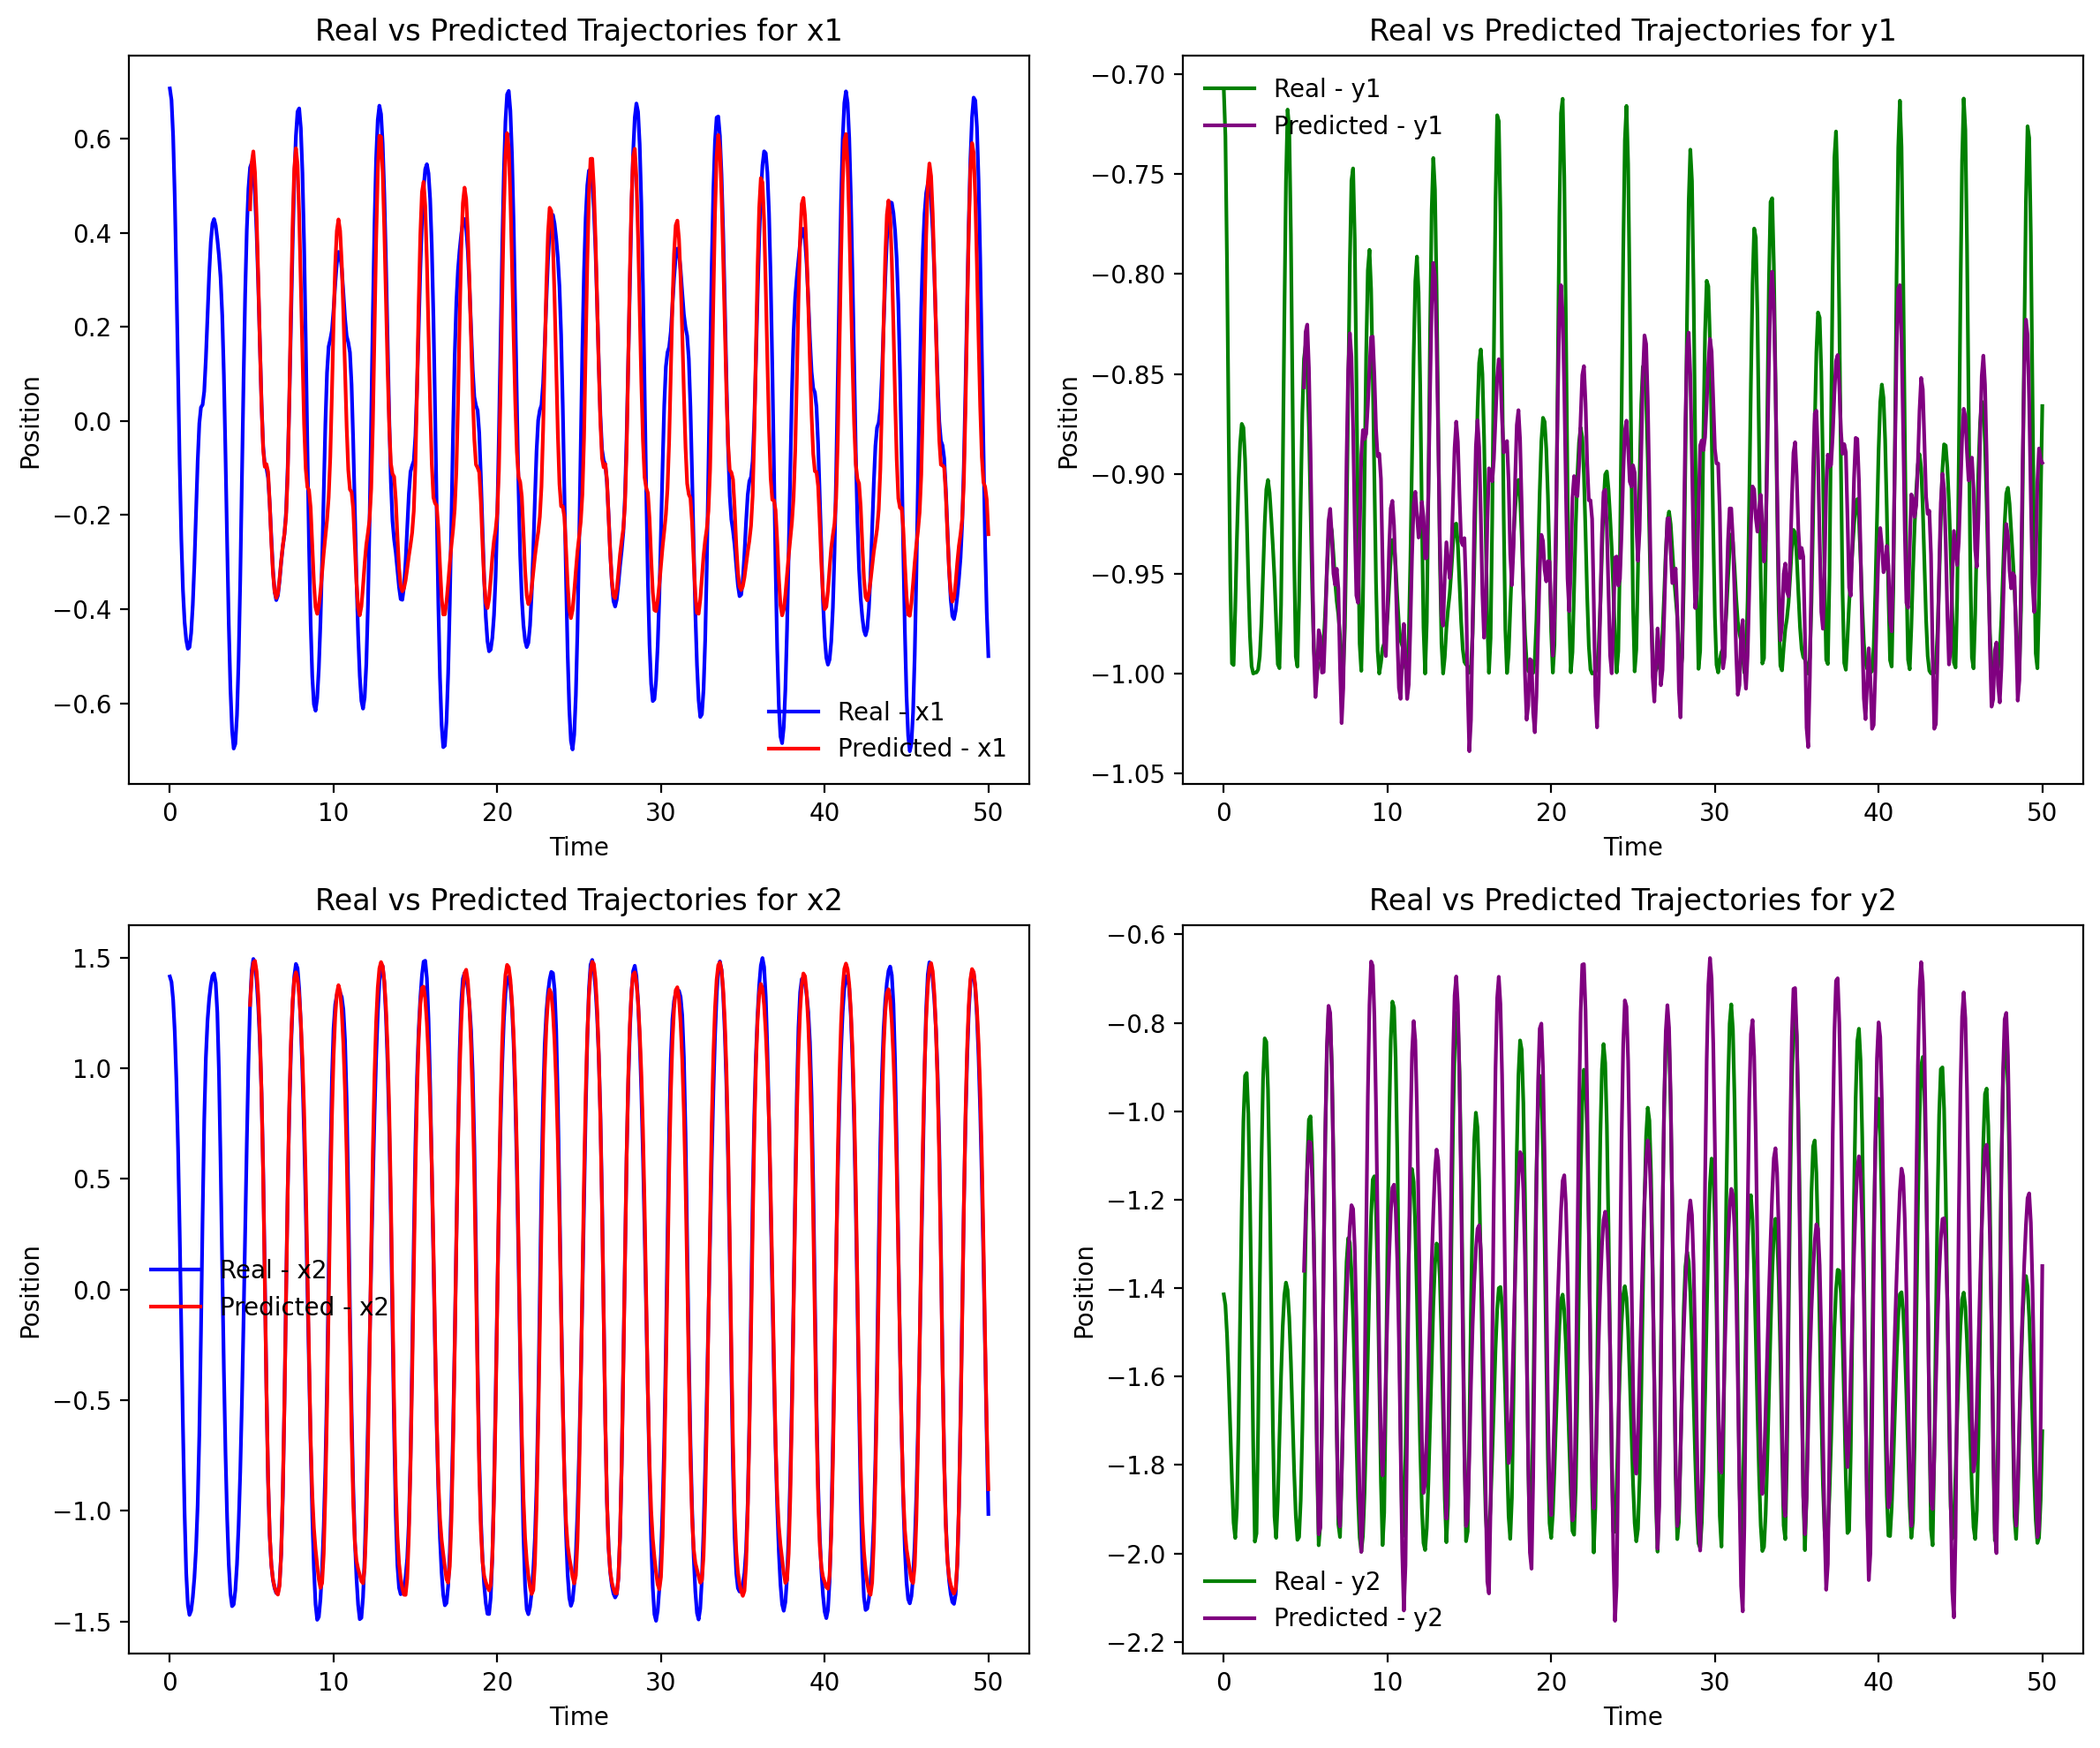

In [ ]:
# Number of samples we will use to train our network
windowsize= 30

# How many samples into the future to predict
offset= 20

x1,y1,x2,y2 = stability(np.pi/4,0)
timePlot(x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat,windowsize,offset)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11000     
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


The final cost for training data is 1.7218134189533885e-06
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                11000     
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.66it/s]


The final cost for training data is 0.0023484353441745043
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                11000     
                                                                 
 dense_3 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


The final cost for training data is 0.01357489638030529
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                11000     
                                                                 
 dense_4 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.62it/s]


The final cost for training data is 0.011855388060212135
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                11000     
                                                                 
 dense_5 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.53it/s]


The final cost for training data is 0.015164264477789402
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                11000     
                                                                 
 dense_6 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:04<00:00, 23.88it/s]


The final cost for training data is 0.0849536582827568
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                11000     
                                                                 
 dense_7 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


The final cost for training data is 0.00356390792876482
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                11000     
                                                                 
 dense_8 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


The final cost for training data is 0.008959935046732426
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                11000     
                                                                 
 dense_9 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


The final cost for training data is 0.11320862174034119
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                11000     
                                                                 
 dense_10 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


The final cost for training data is 3.3225471270270646e-05


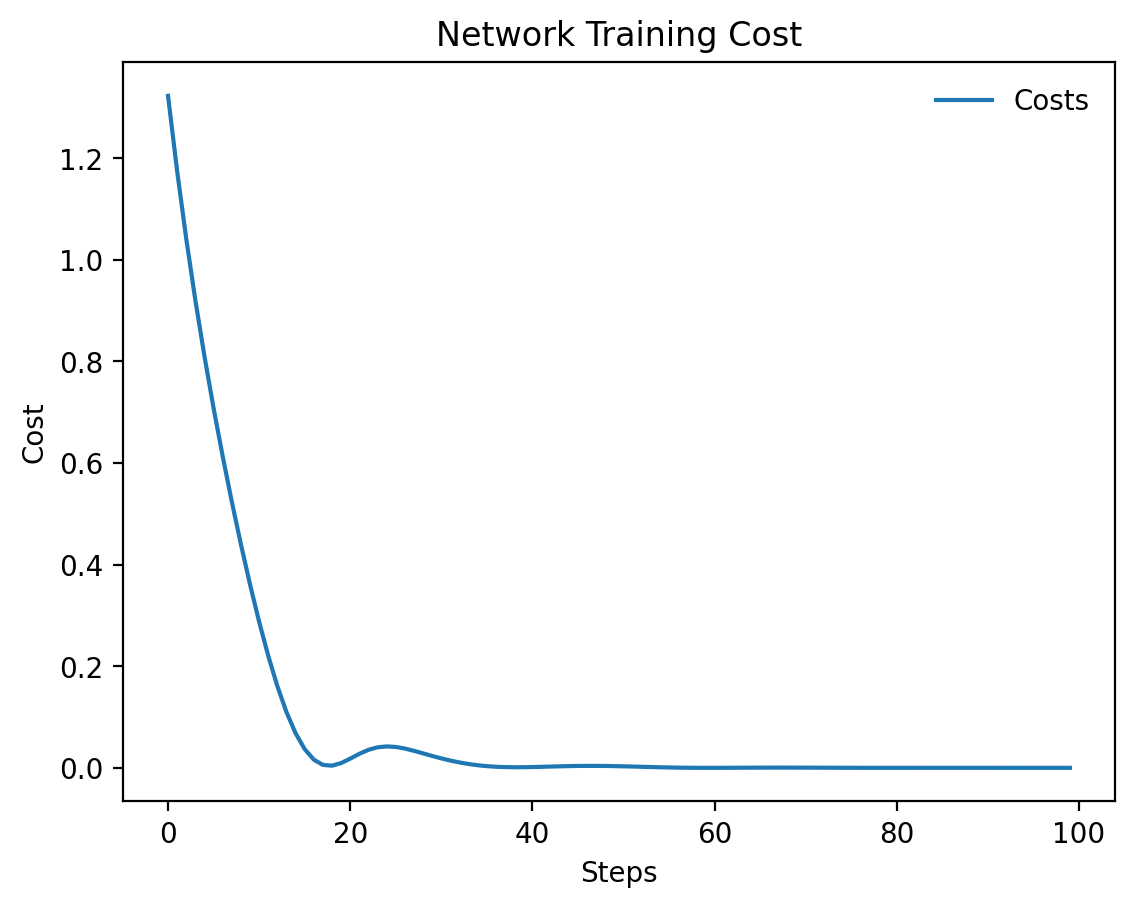

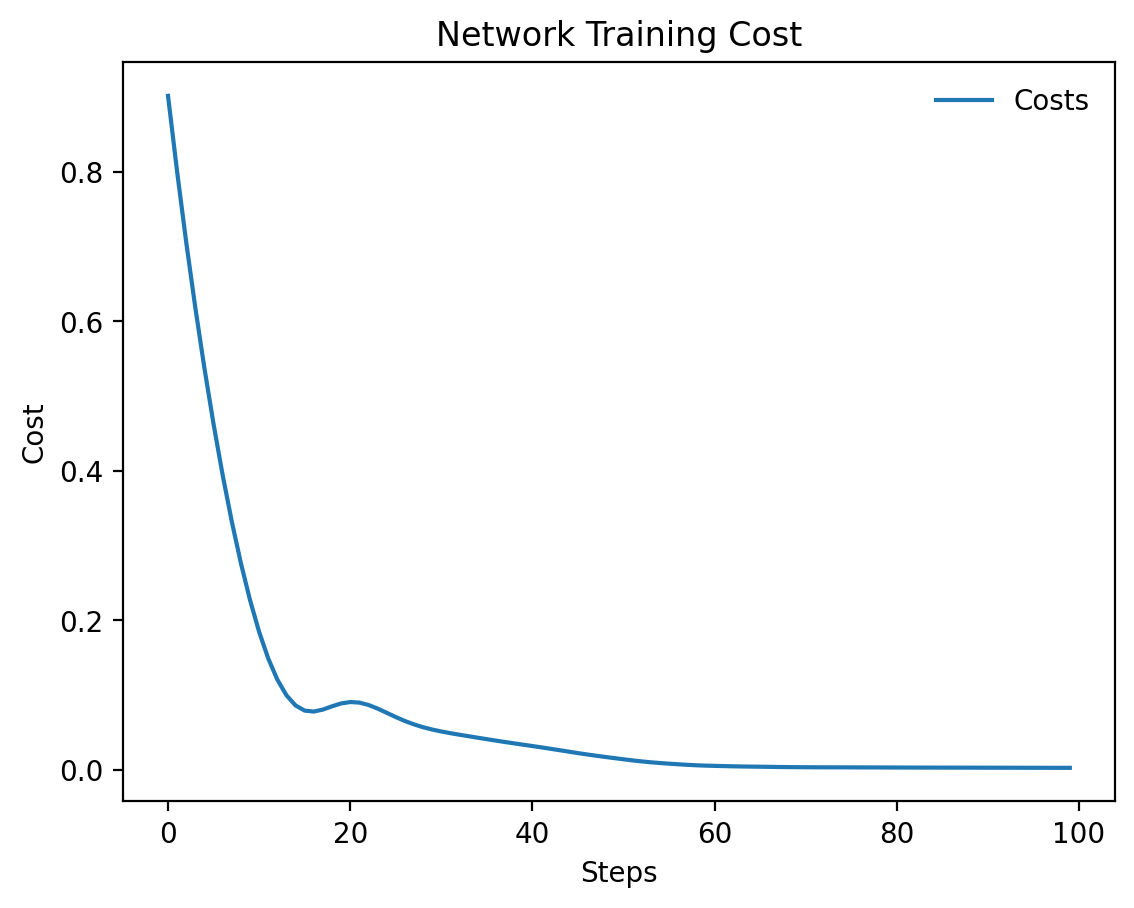

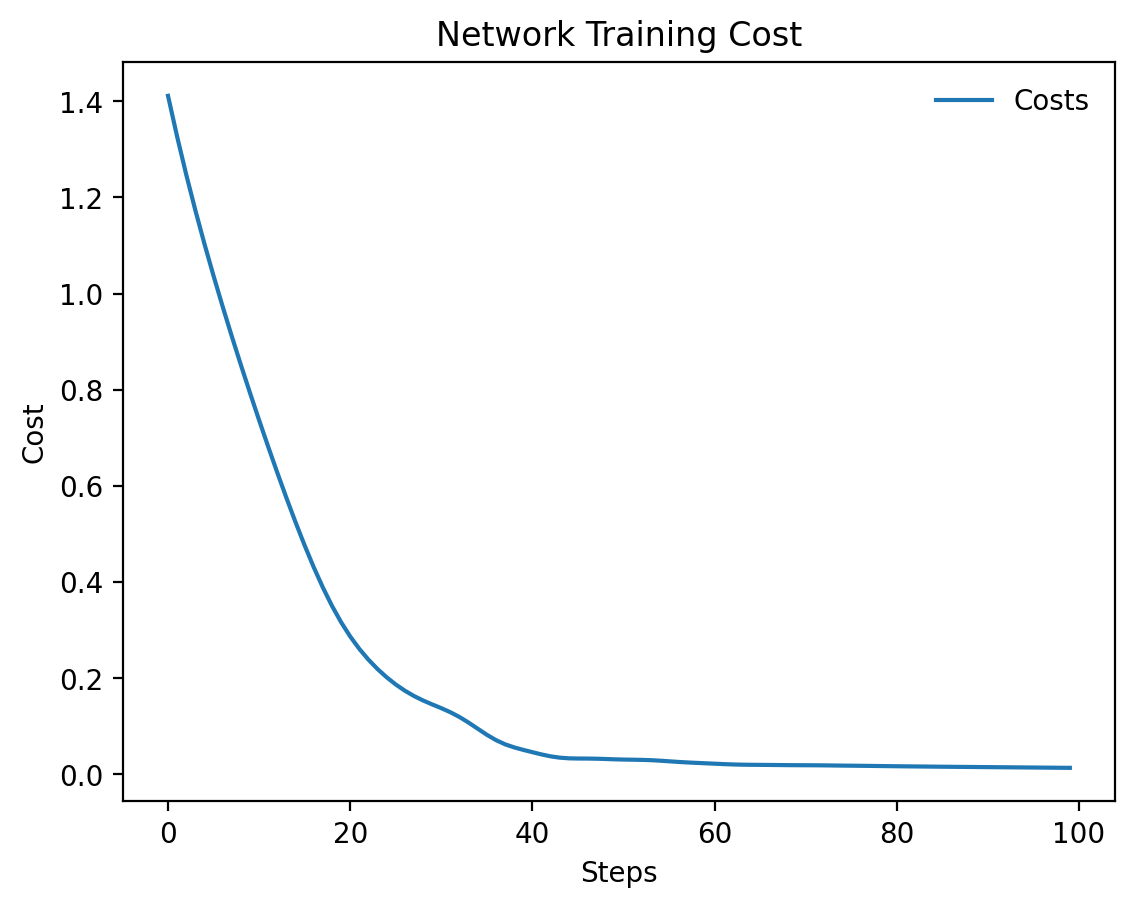

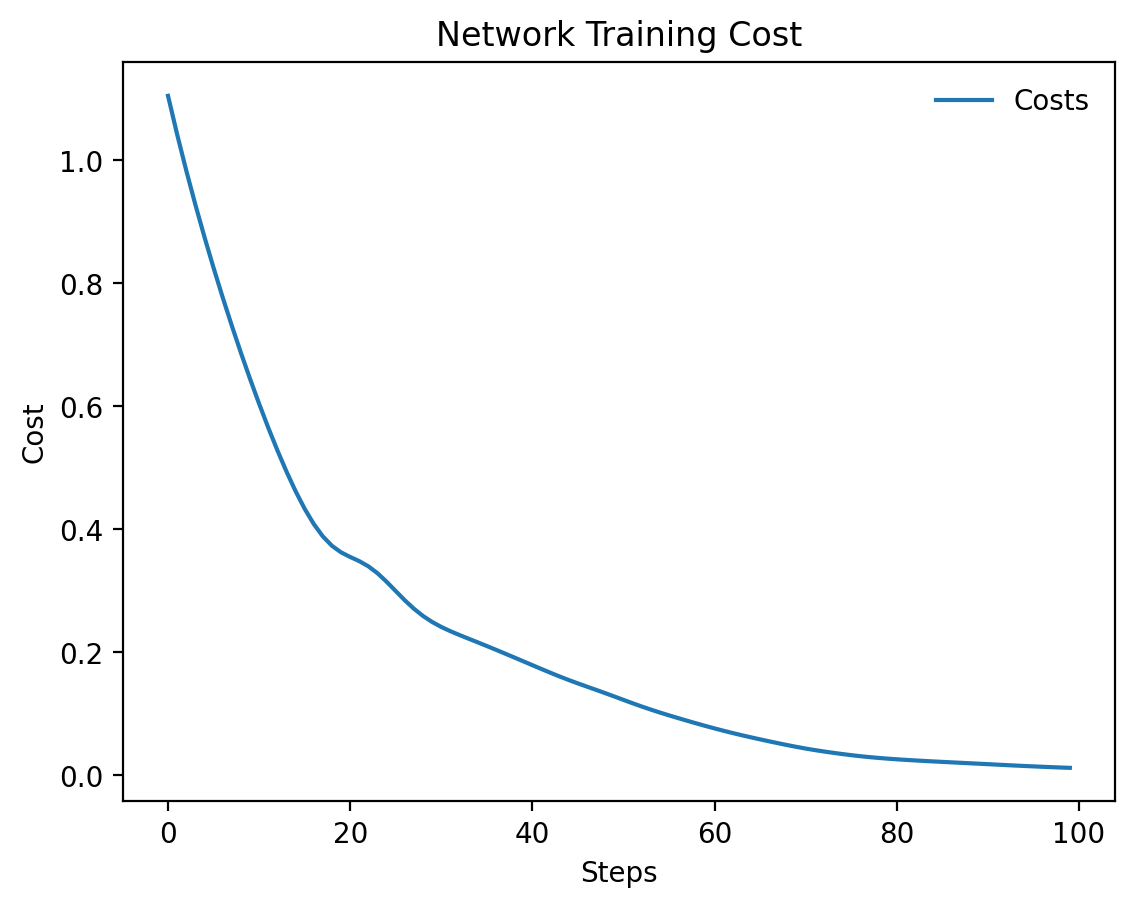

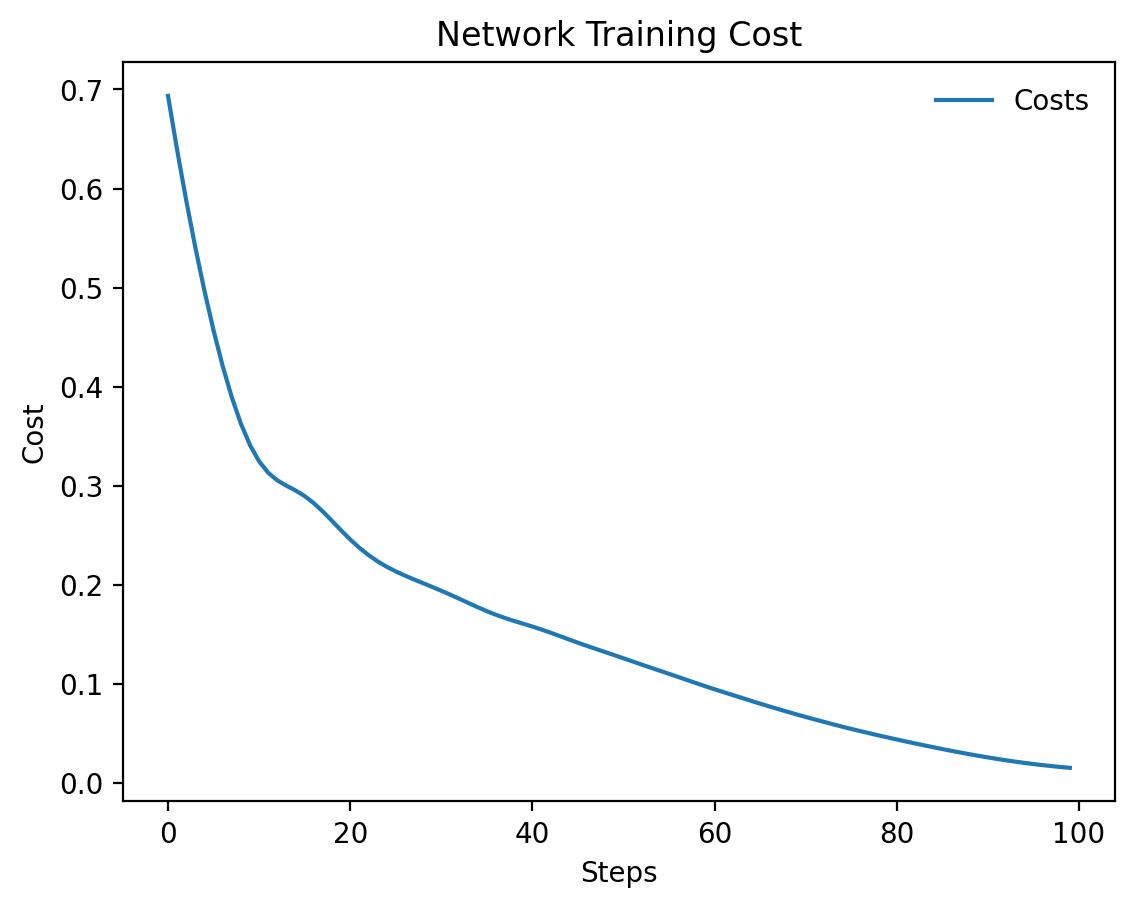

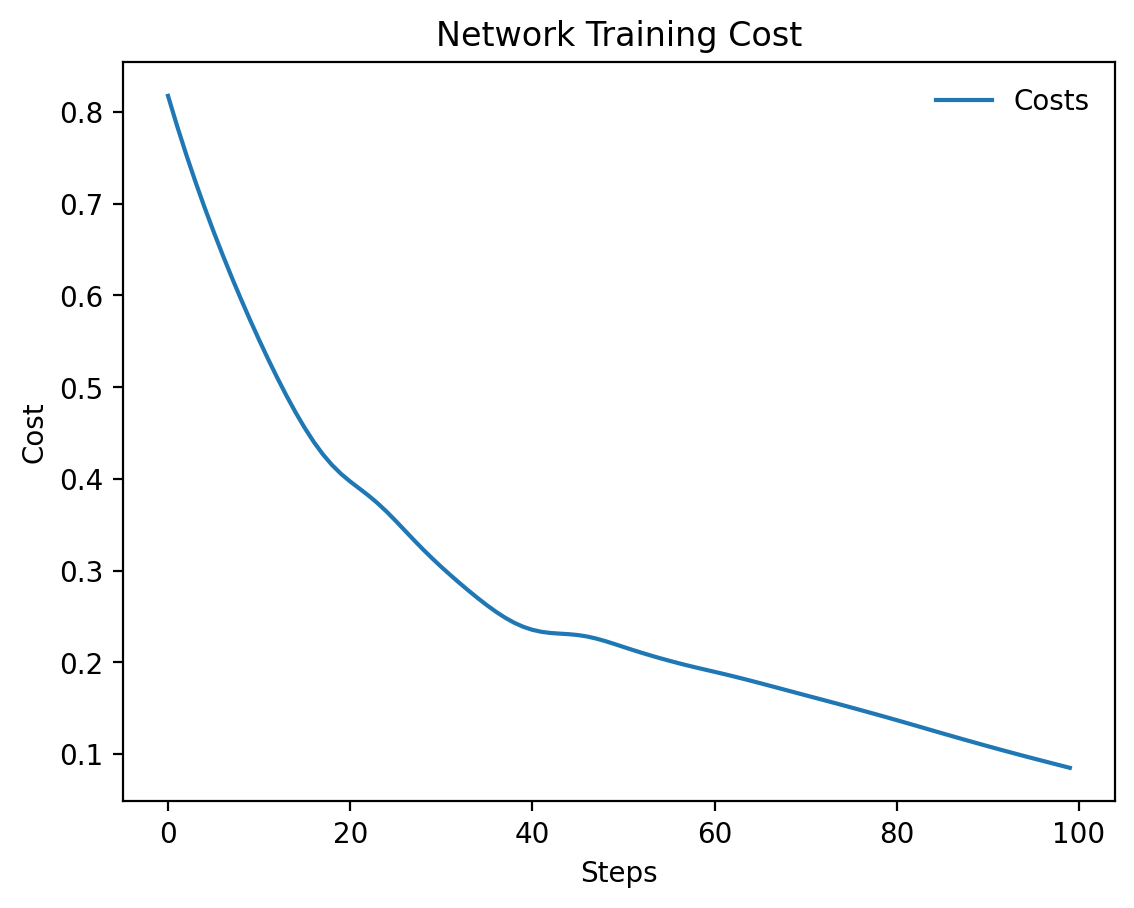

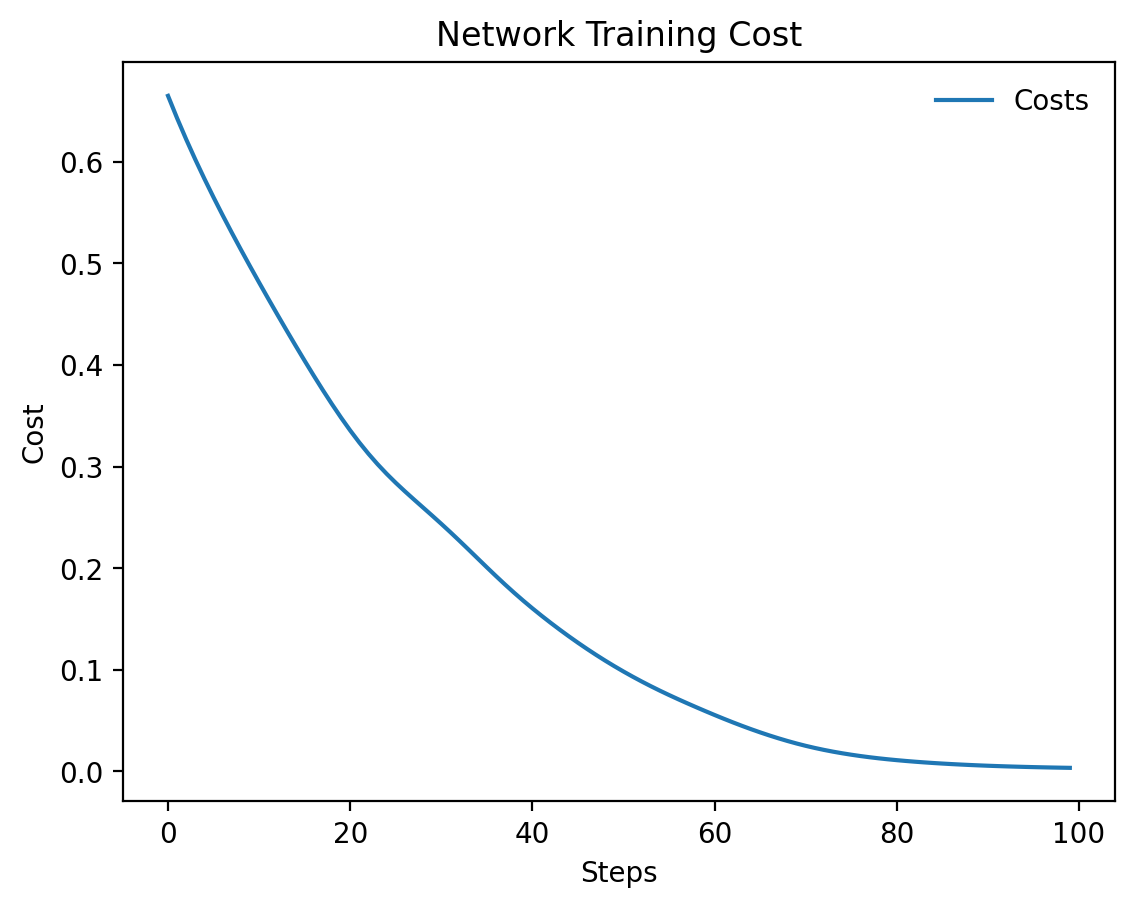

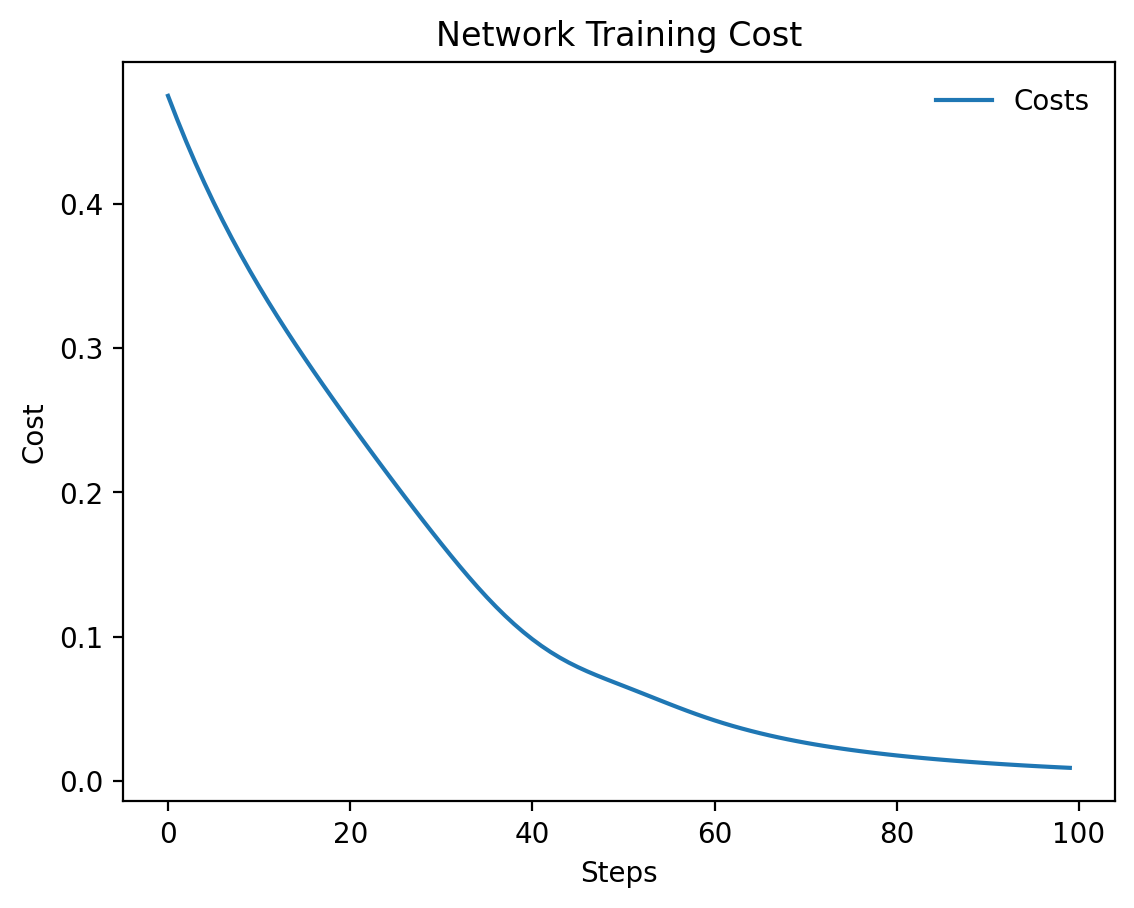

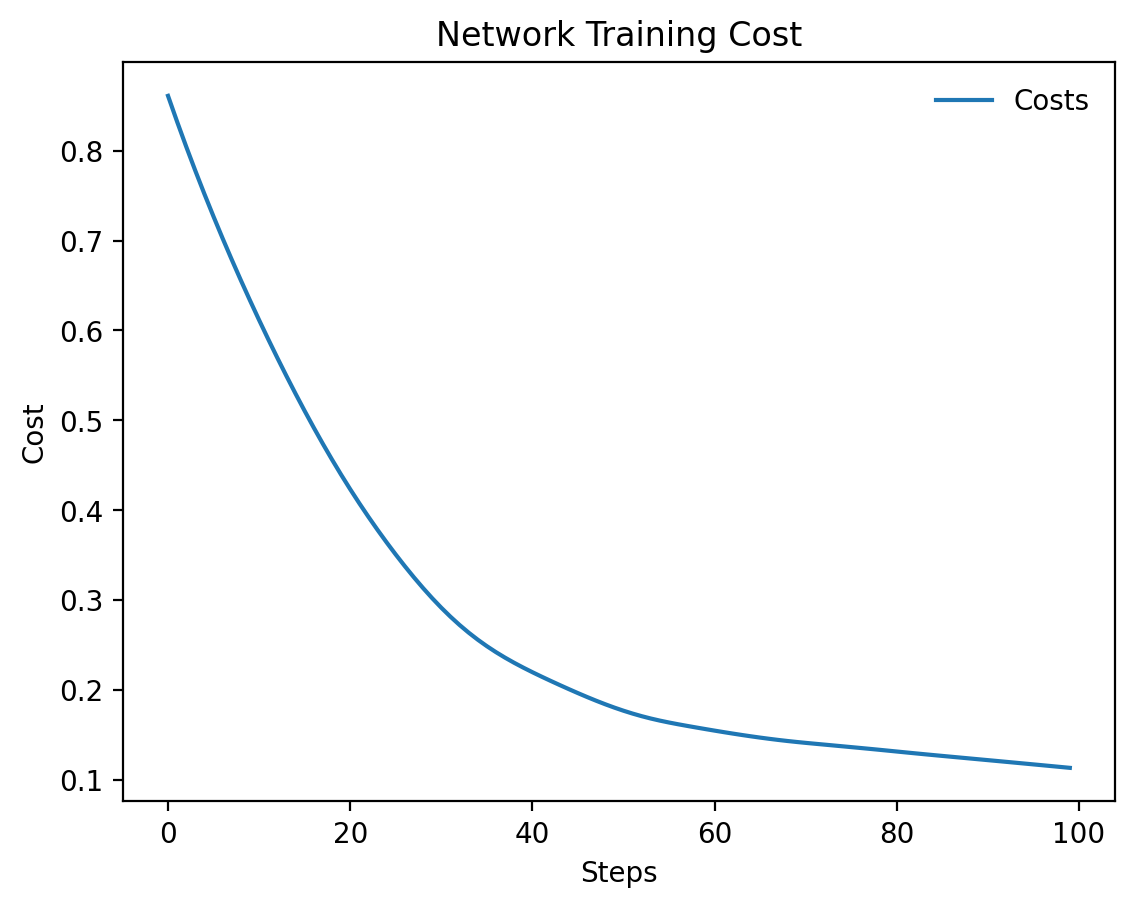

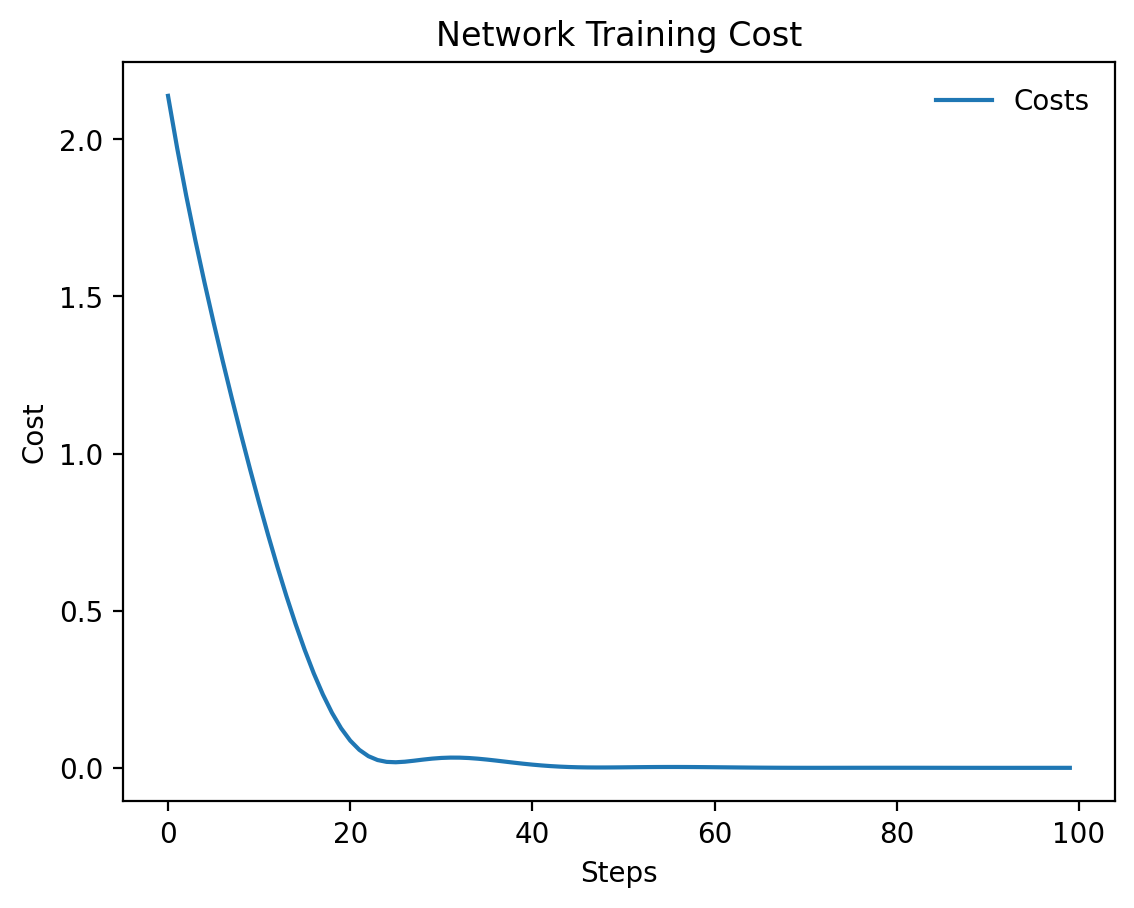

In [ ]:
# Set your windowsize and offset values
windowsize = 30
offset = 20
steps = 100

# Initialize arrays to store theta values and final costs
theta_values = np.linspace(0.001, np.pi, 10)
final_costs = []

for theta in theta_values:
    x1, y1, x2, y2 = stability(theta, 0)
    costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model(x1, x2, y1, y2, windowsize, offset,steps)
    final_costs.append(costs[-1])

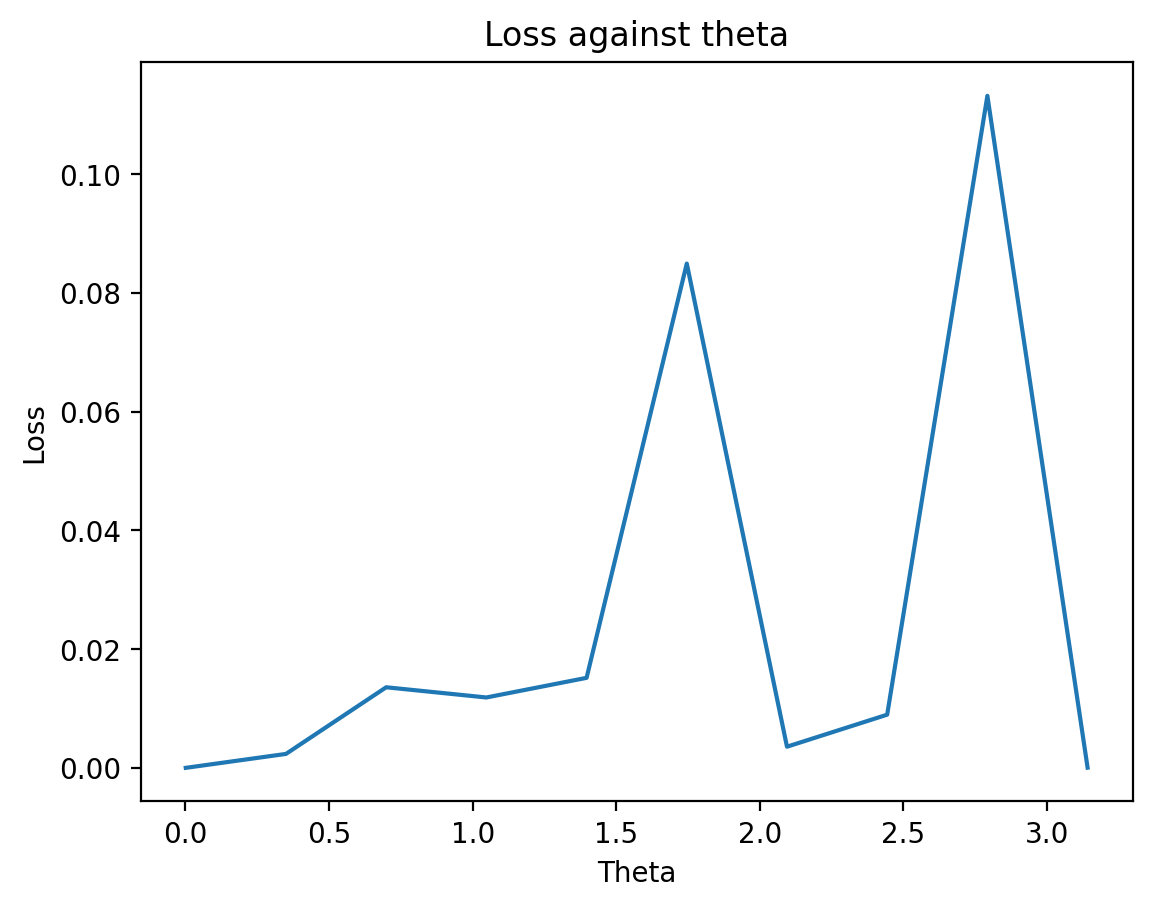

In [ ]:
plt.plot(theta_values, final_costs)
plt.xlabel("Theta")
plt.ylabel("Loss")
plt.title("Loss against theta")
plt.show()

  ## Comment:

  We can see a general upward trend which indicates that the model gets less accurate as theta increases

# 3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 50)                11000     
                                                                 
 dense_11 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 44.23it/s]


The final cost for training data is 0.30052512884140015


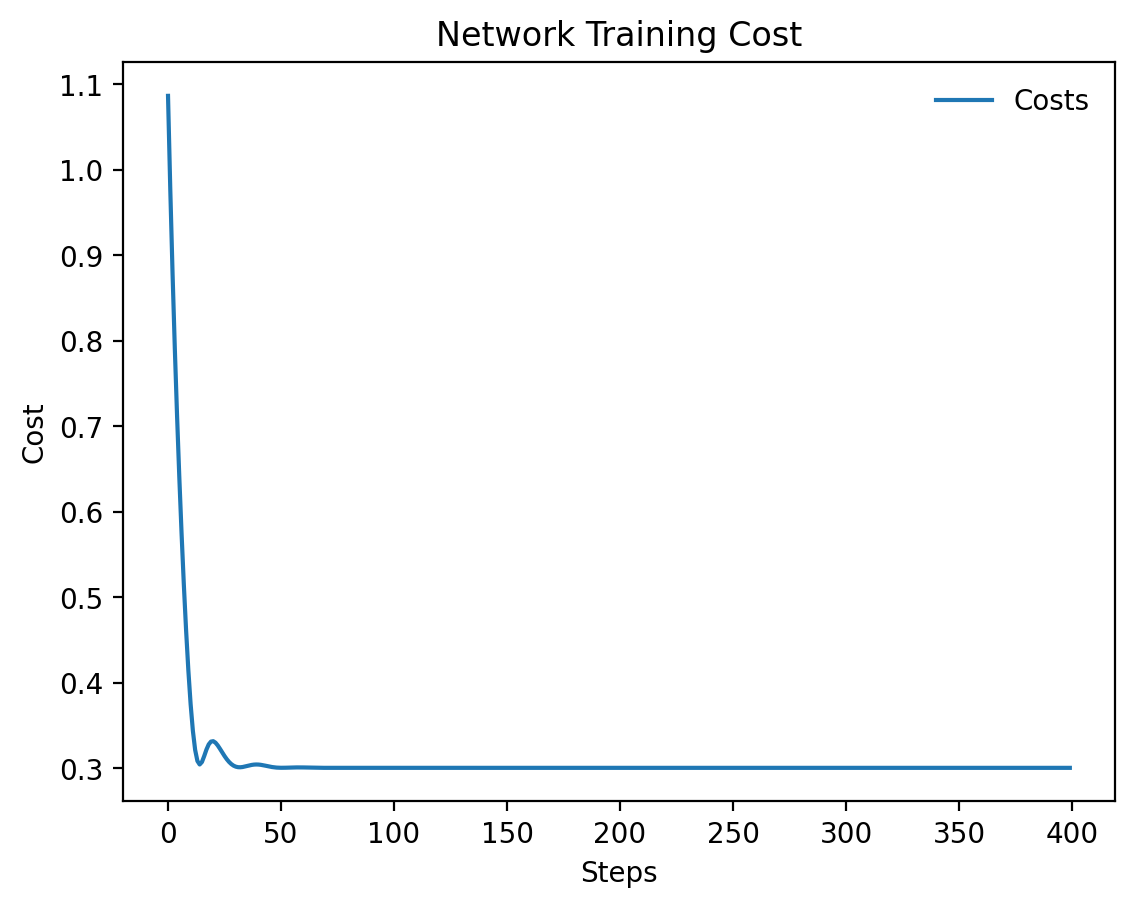

In [ ]:
# New offset to predict 100 into future
windowsize1= 30
offset1= 100
steps = 400

# Predicts future motion using function
costs2, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model(x1, x2, y1, y2, windowsize, offset1,steps)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50)                11000     
                                                                 
 dense_12 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 43.77it/s]


The final cost for training data is 0.000943765917327255
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                11000     
                                                                 
 dense_13 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 41.51it/s]


The final cost for training data is 0.0012334364000707865
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50)                11000     
                                                                 
 dense_14 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 41.28it/s]


The final cost for training data is 0.001658146153204143
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 50)                11000     
                                                                 
 dense_15 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


The final cost for training data is 0.001571799861267209
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50)                11000     
                                                                 
 dense_16 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 40.45it/s]


The final cost for training data is 0.0015906763728708029
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 50)                11000     
                                                                 
 dense_17 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 42.50it/s]


The final cost for training data is 0.0009179615881294012
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50)                11000     
                                                                 
 dense_18 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 43.17it/s]


The final cost for training data is 0.0014193416573107243
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 50)                11000     
                                                                 
 dense_19 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 41.06it/s]


The final cost for training data is 0.0014646016061306
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 50)                11000     
                                                                 
 dense_20 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 40.01it/s]


The final cost for training data is 0.0012851017527282238
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 50)                11000     
                                                                 
 dense_21 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 40.28it/s]


The final cost for training data is 0.0015912031522020698


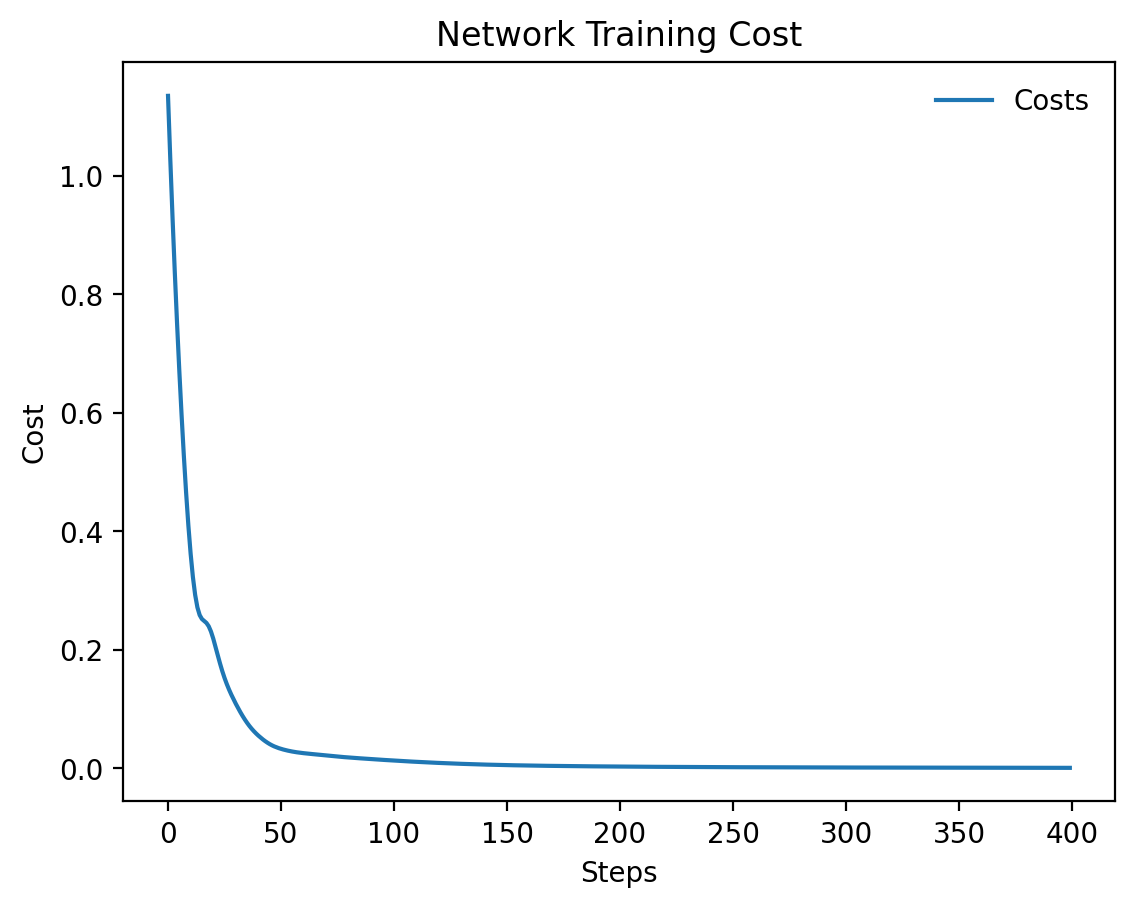

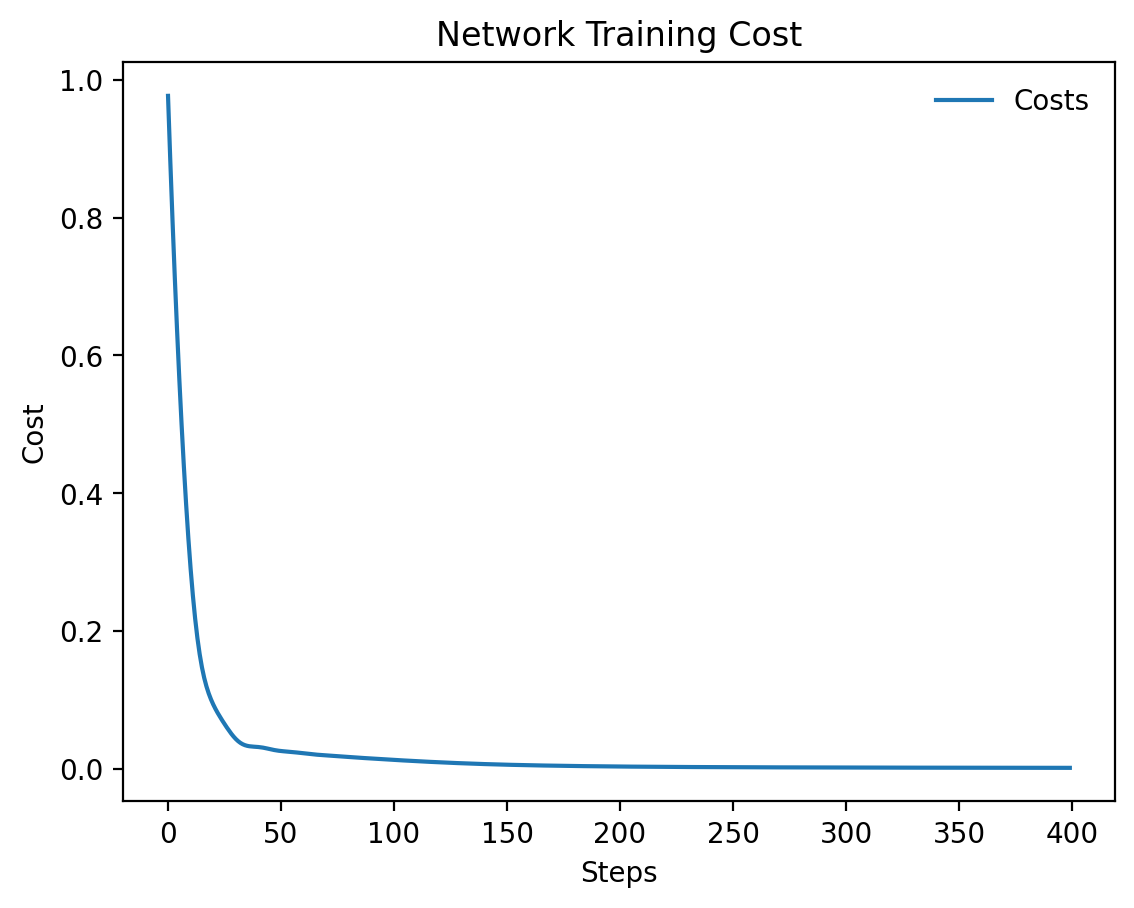

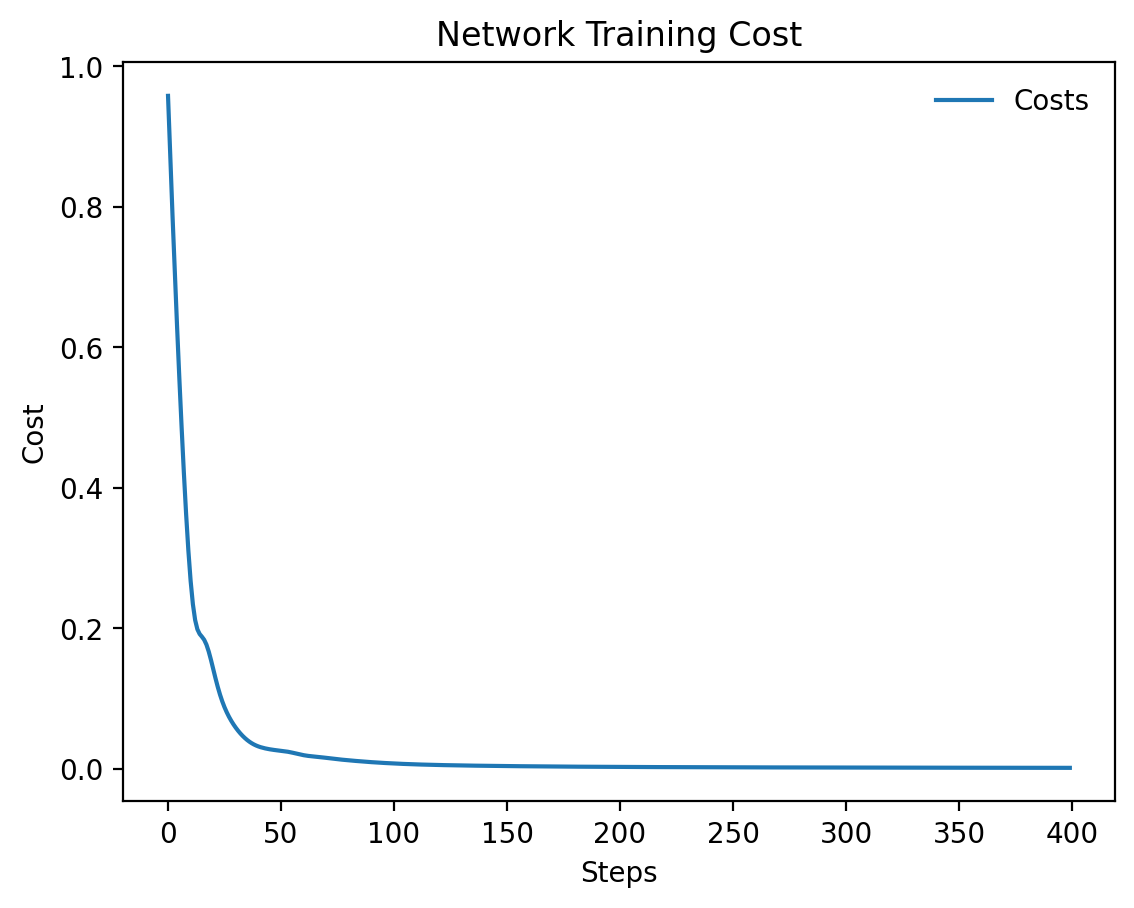

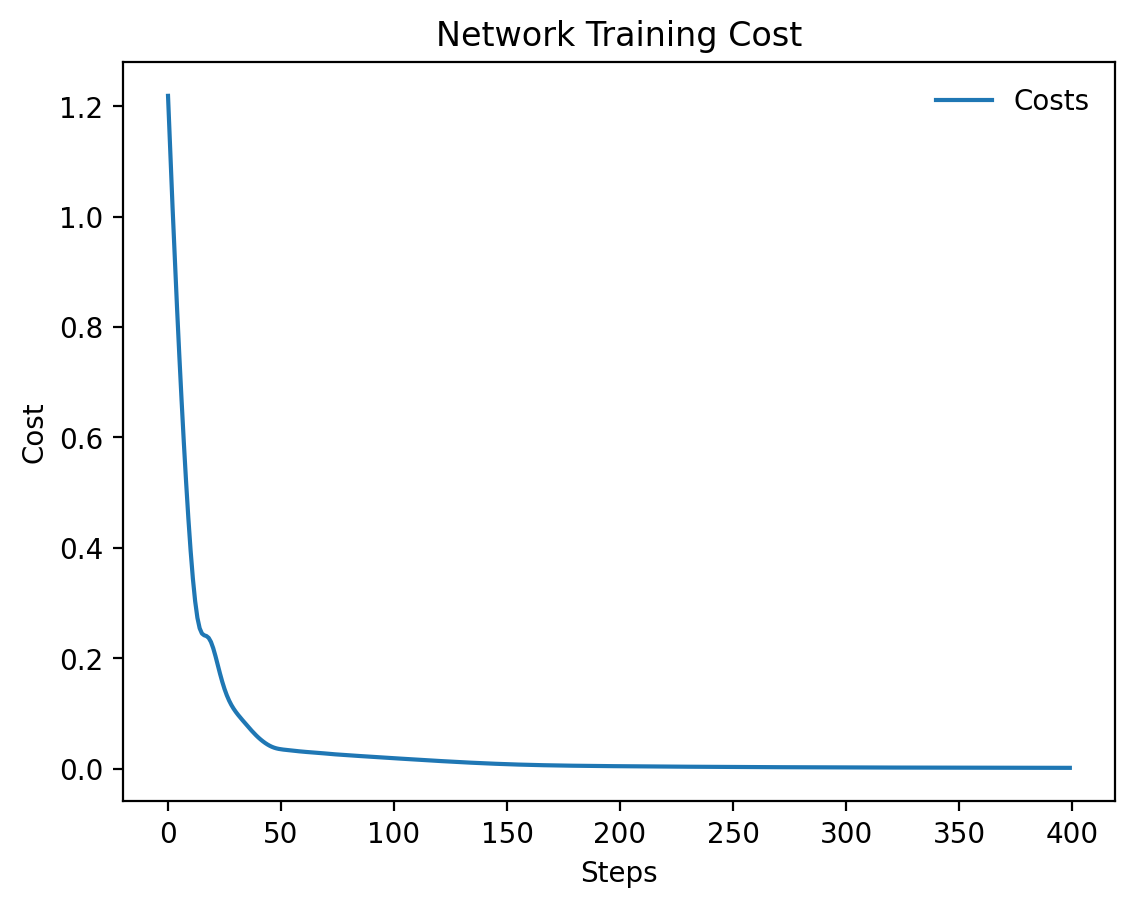

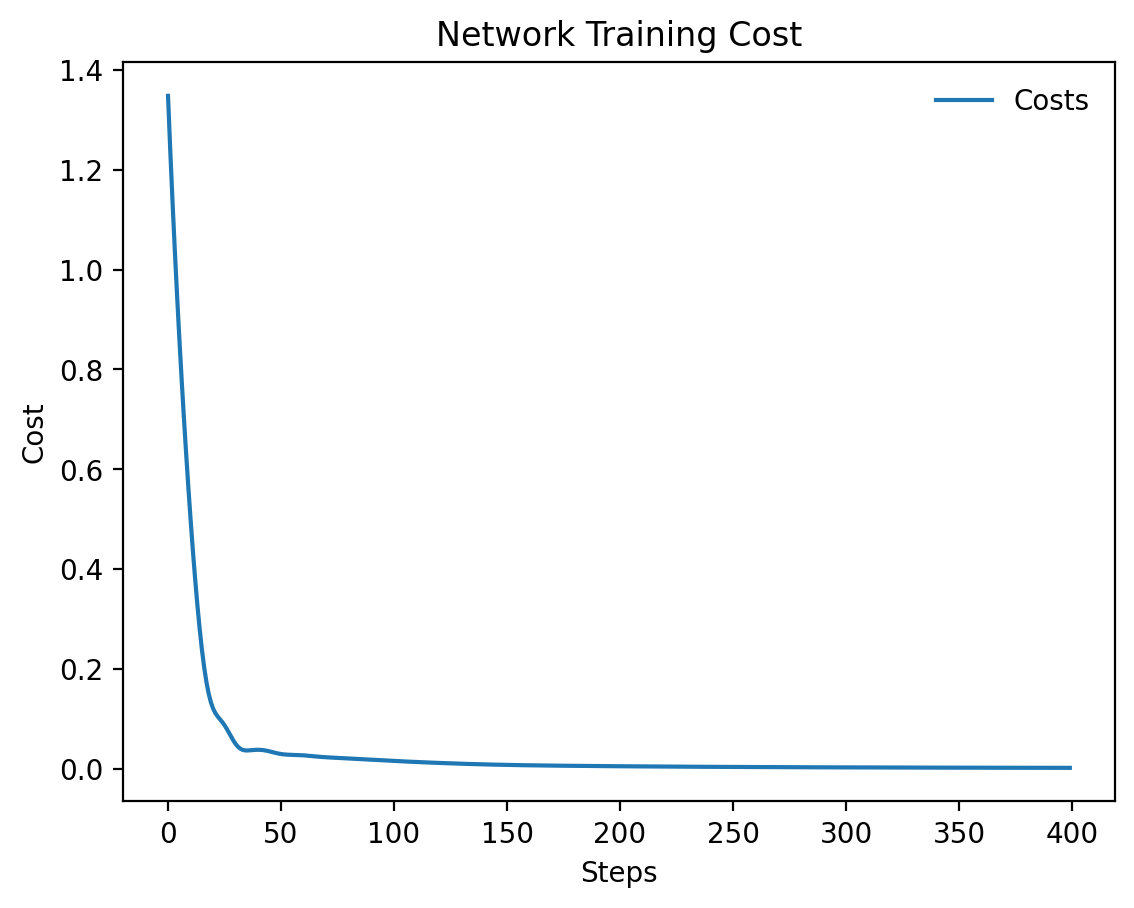

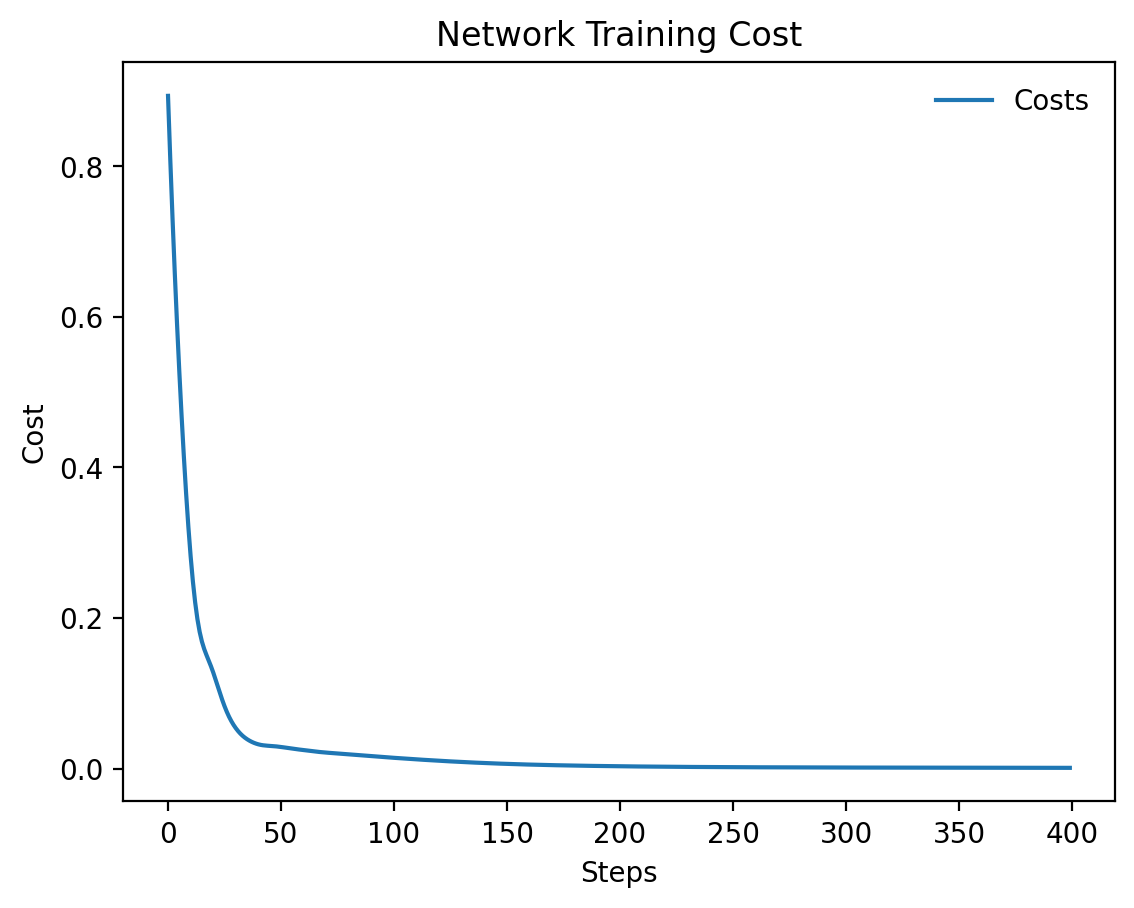

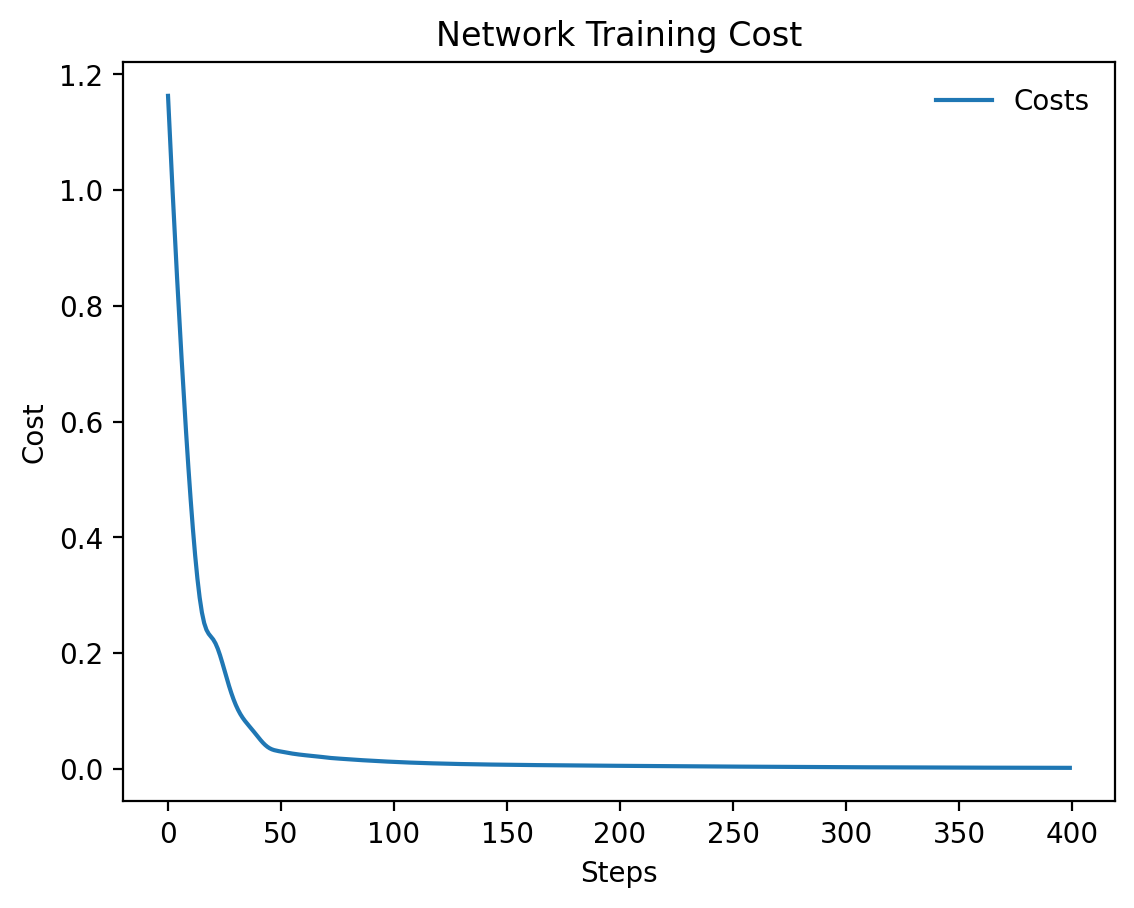

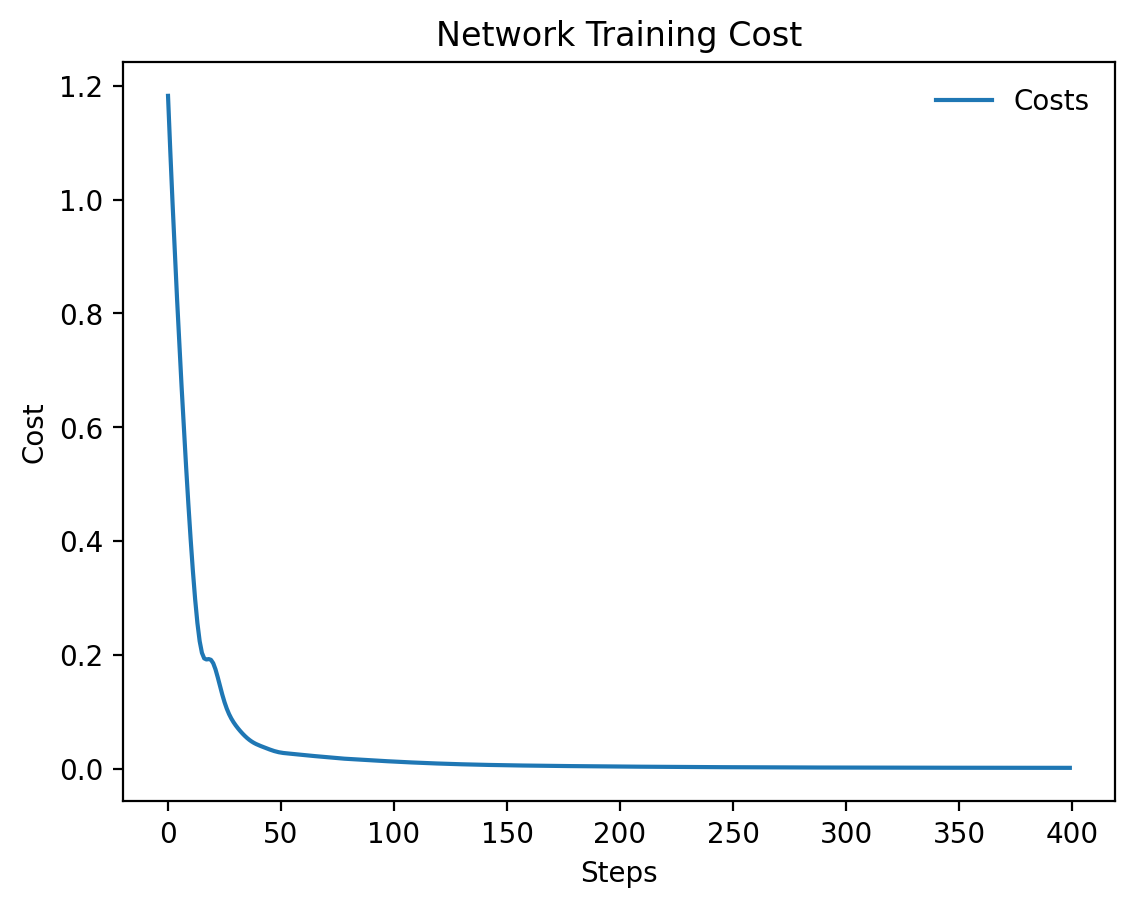

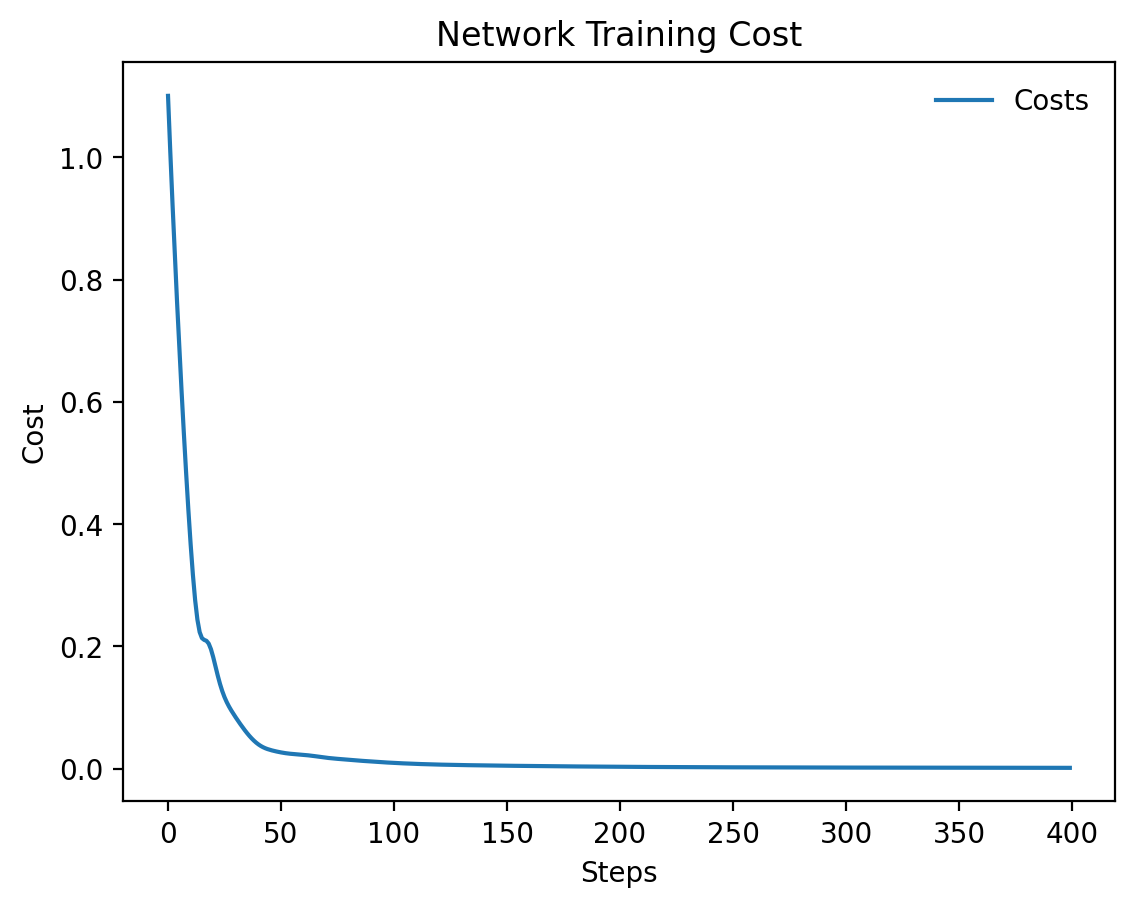

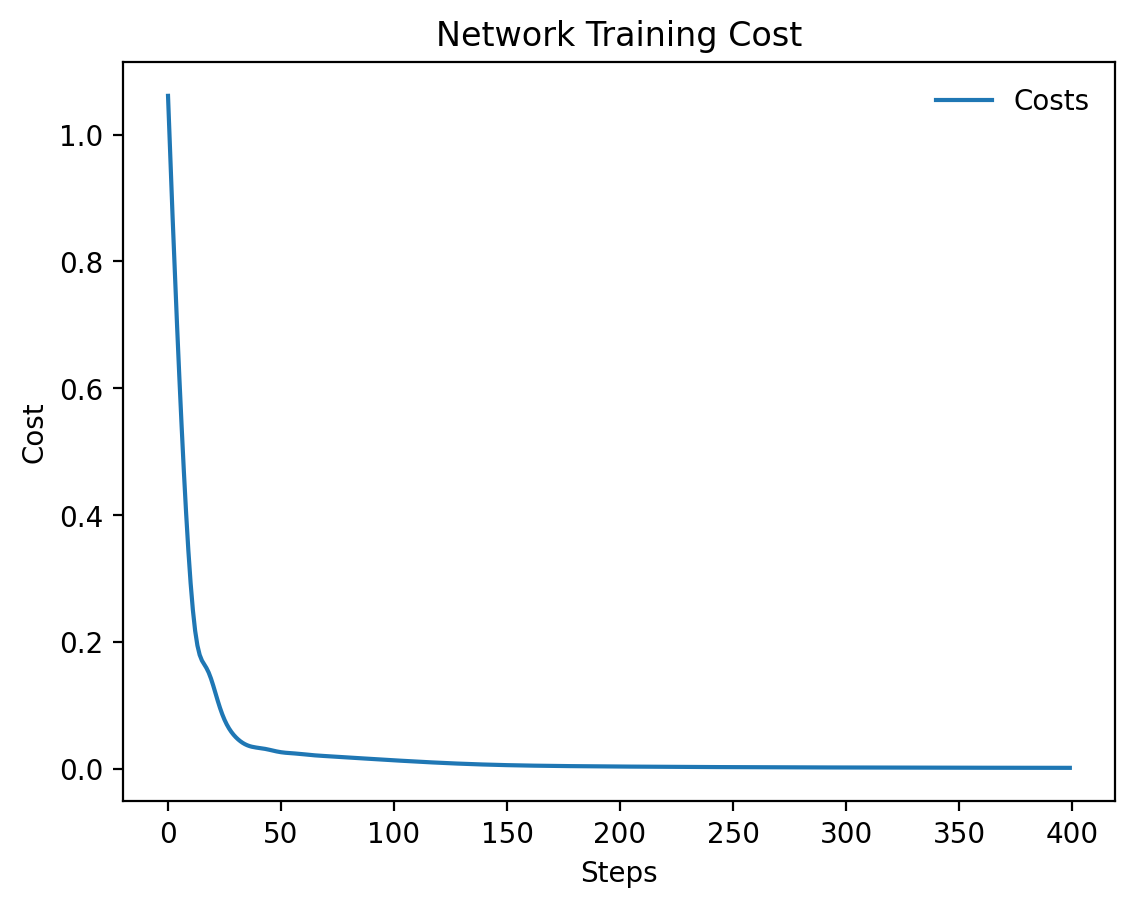

In [ ]:
# Range of offsets
offsets1 = np.linspace(20,100,10)

# Initialize arrays to store theta values and final costs
final_costs = []

for offset in offsets1:
    x1, y1, x2, y2 = stability(np.pi/4, 0)
    costs2, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model(x1, x2, y1, y2, windowsize, offset1,steps)
    final_costs.append(costs2[-1])

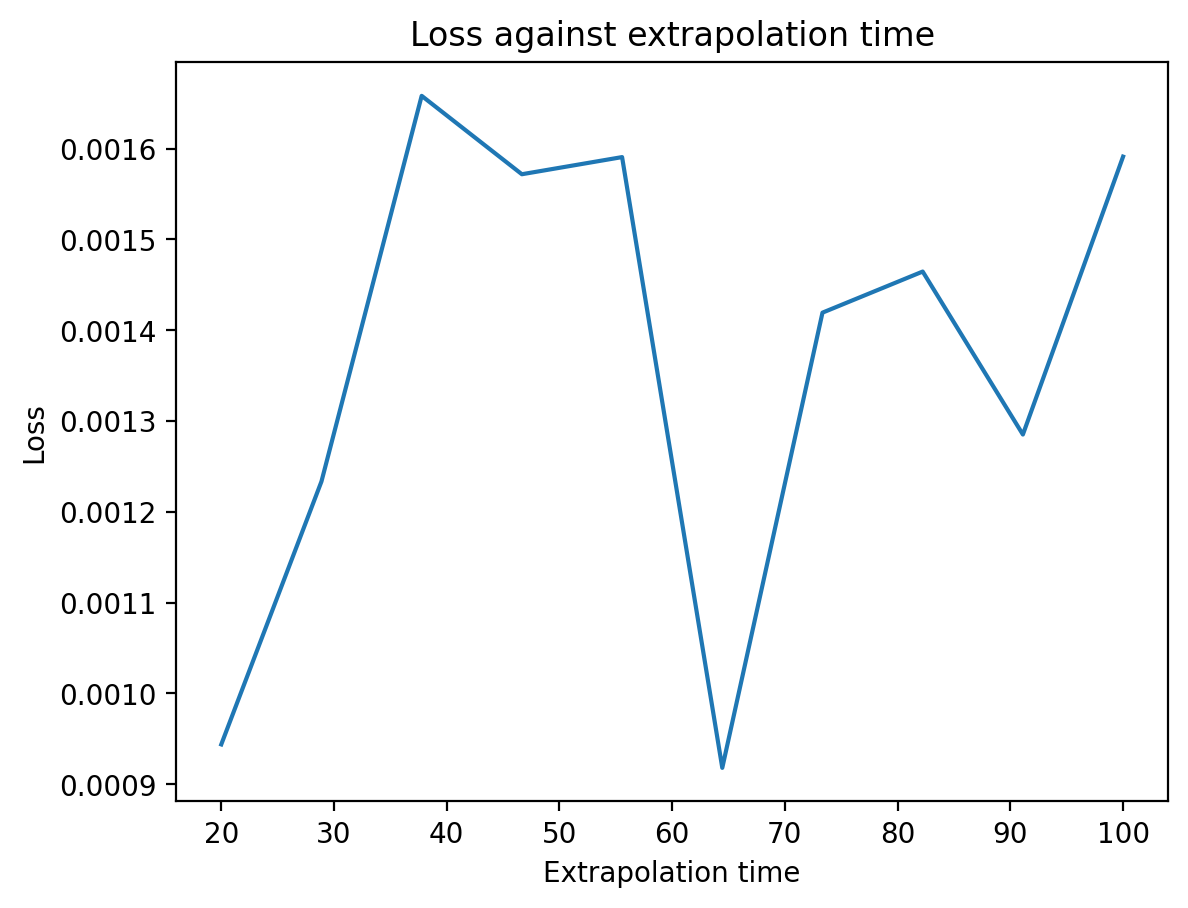

In [ ]:
plt.plot(offsets1, final_costs)
plt.xlabel("Extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

## Comment:

The loss of all offset values is lower than 0.002. This shows that our model can predict far into the future.

## Part 4:
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.

In [ ]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1,y1,x2,y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 50)                11000     
                                                                 
 dense_22 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:10<00:00, 39.83it/s]


The final cost for training data is 0.0015555346617475152


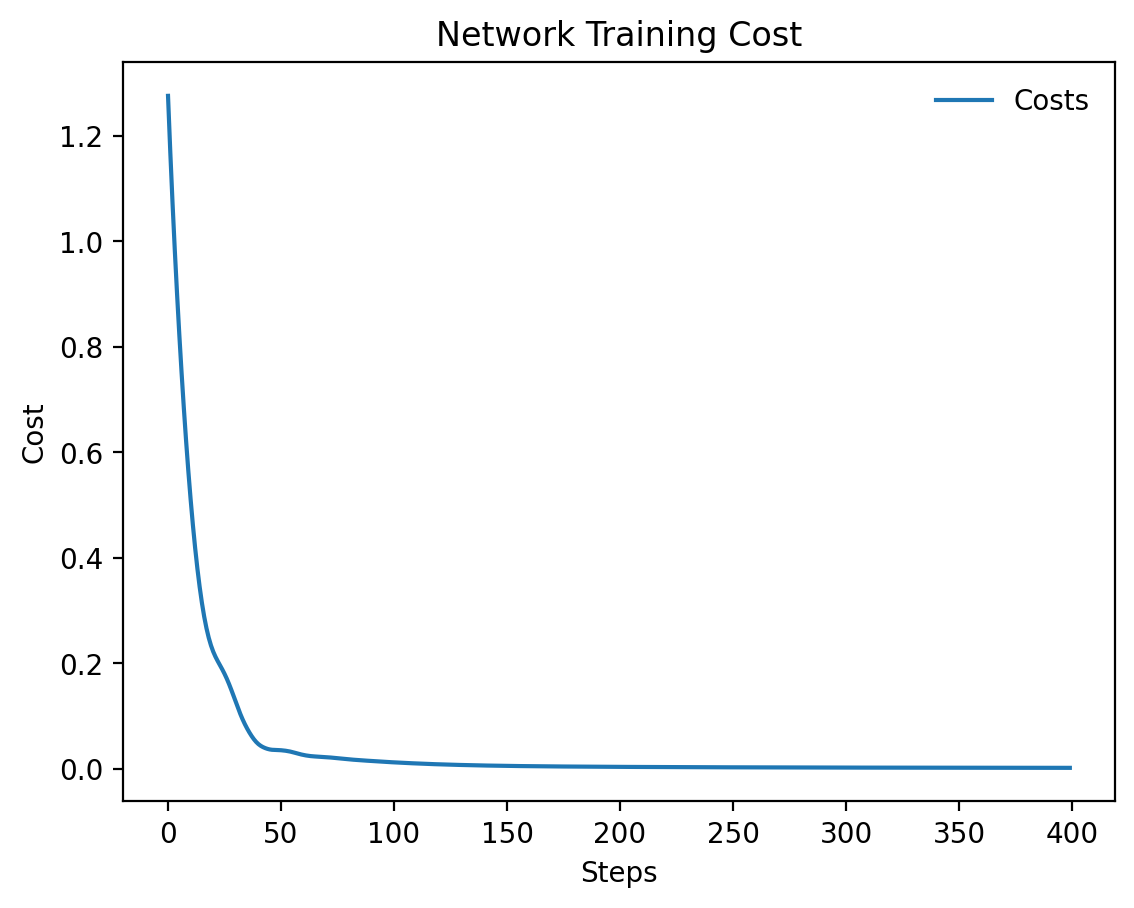

In [ ]:
costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model(x1, x2, y1, y2, 30, 20, 400)

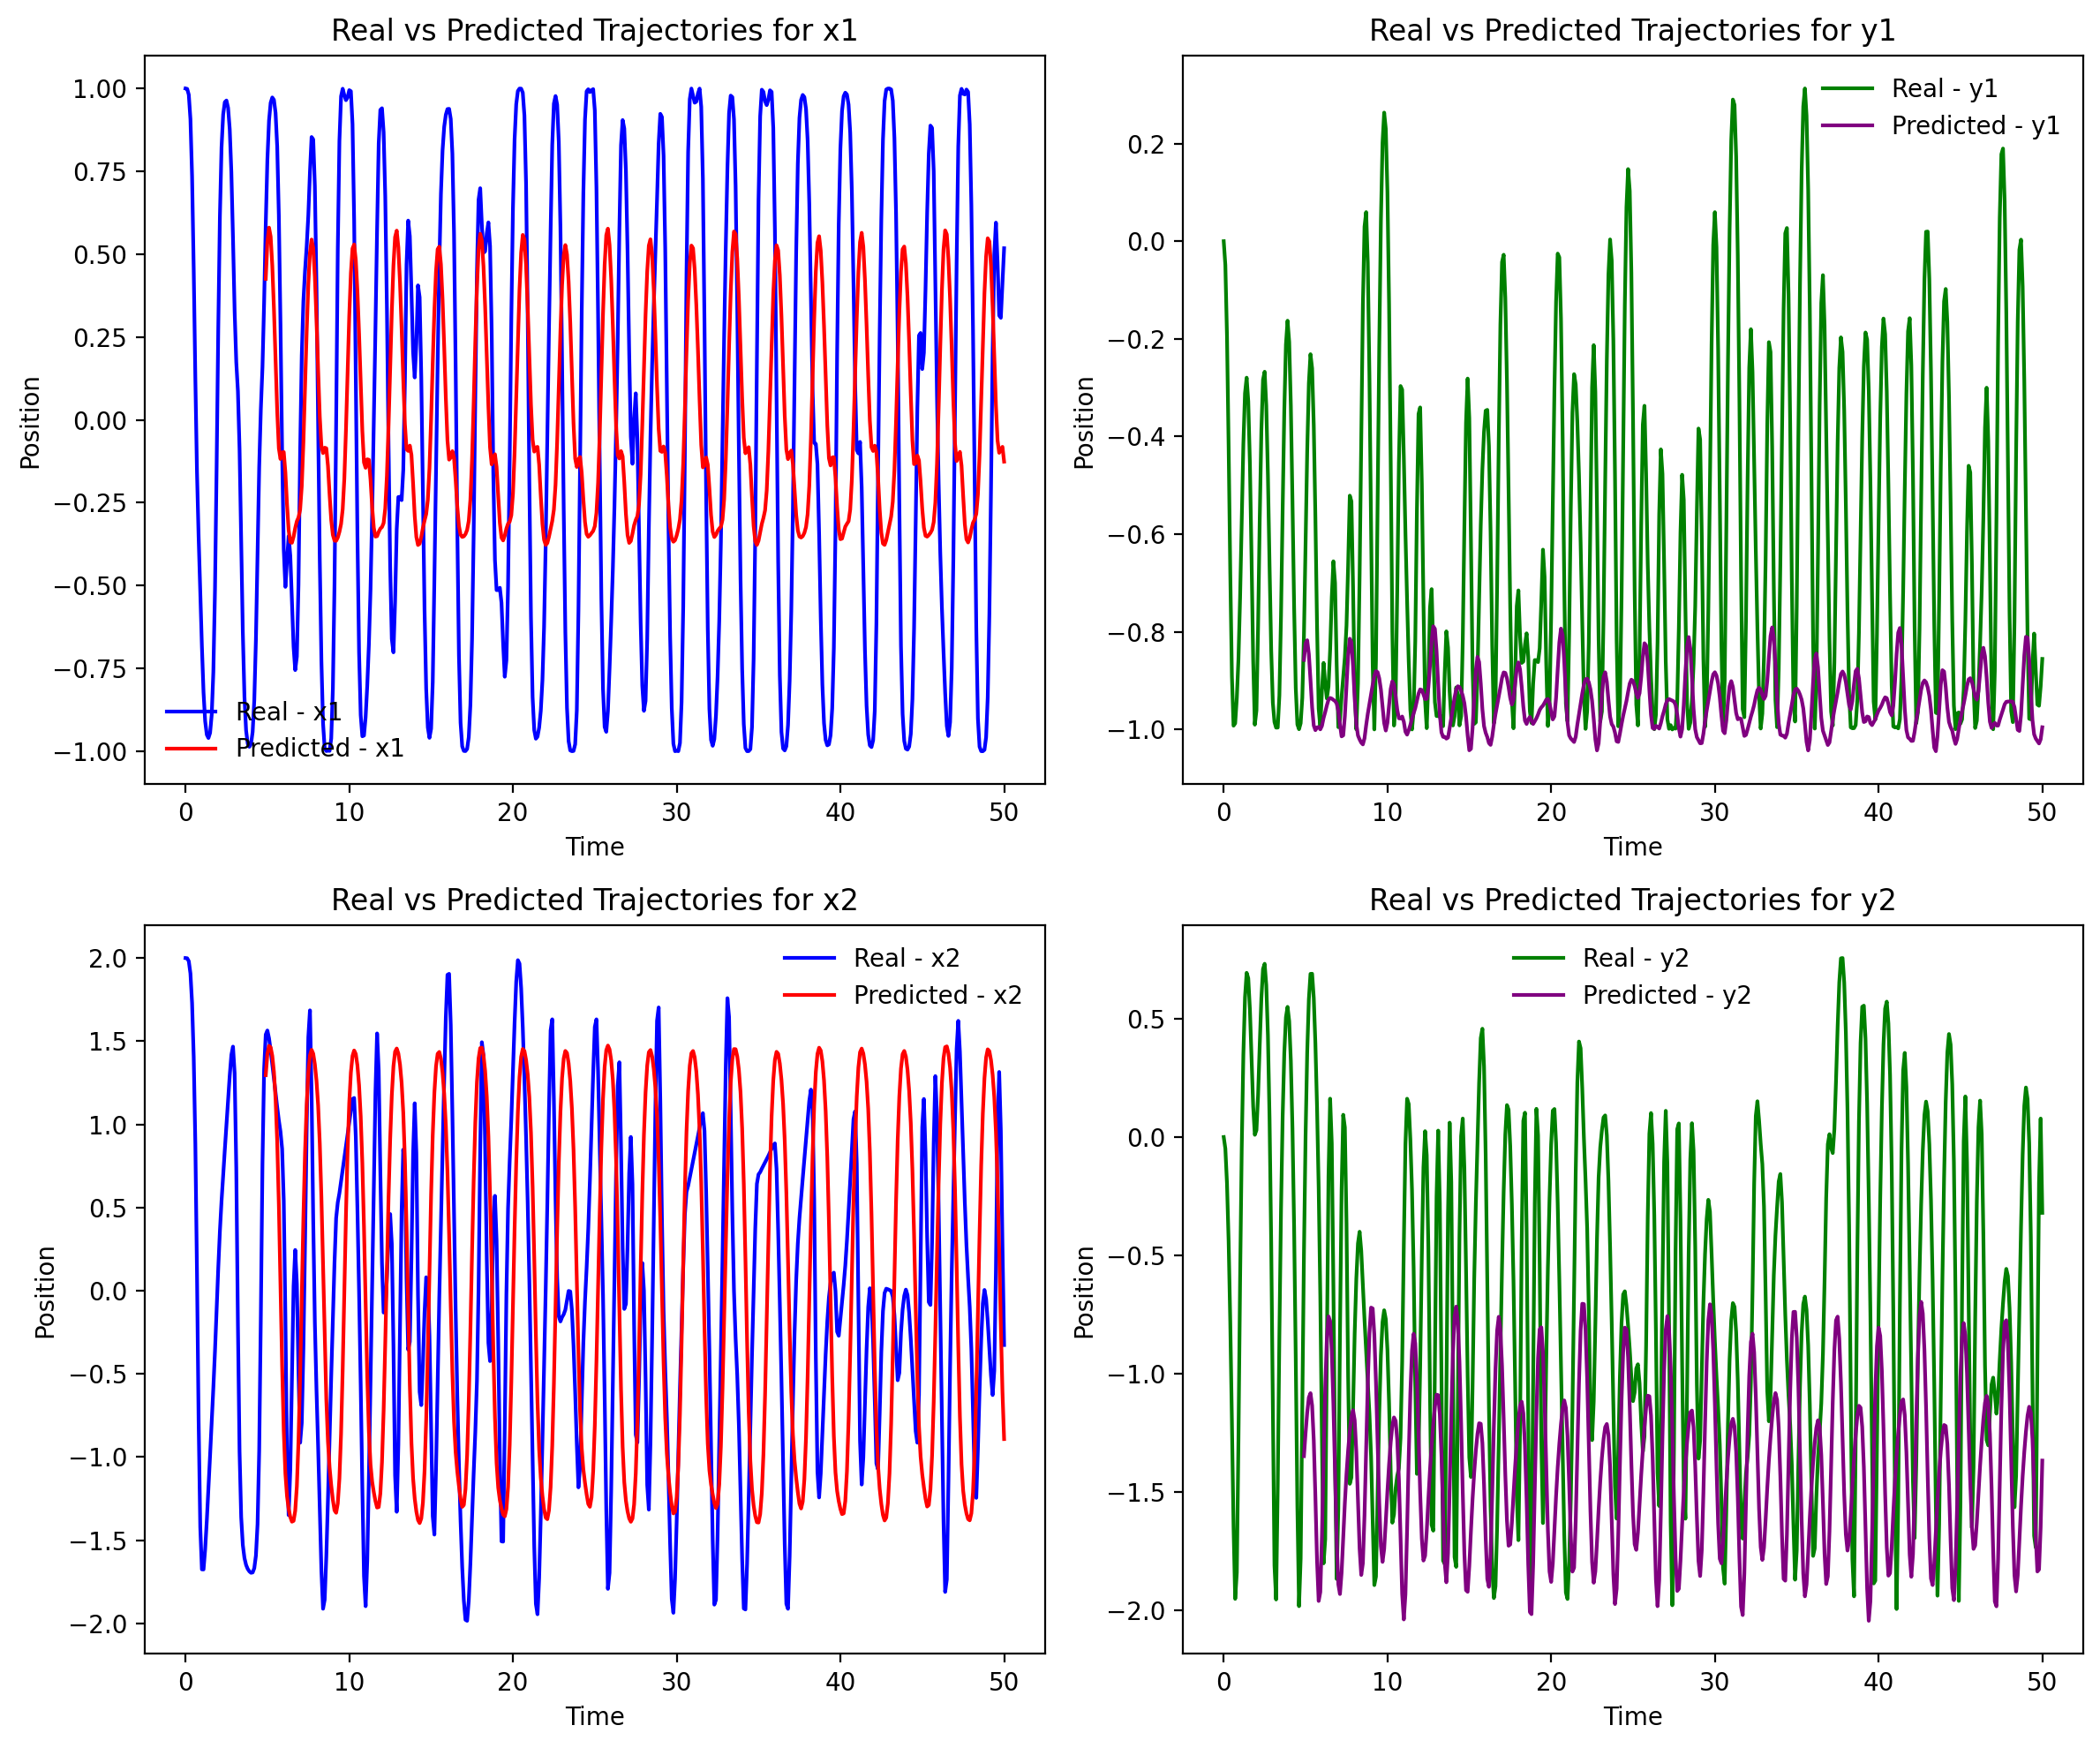

In [ ]:
# Number of samples we will use to train our network
windowsize= 30

# How many samples into the future to predict
offset= 20

x1,y1,x2,y2 = stability(np.pi/2,0)
timePlot(x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat,windowsize,offset)

## Comment:

We can see that with these different initial conditions the networks are much more difficult to predict,

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 50)                11000     
                                                                 
 dense_23 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:04<00:00, 23.18it/s]


The final cost for training data is 1.095528932637535e-05
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50)                11000     
                                                                 
 dense_24 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.72it/s]


The final cost for training data is 0.0023045125417411327
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 50)                11000     
                                                                 
 dense_25 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 26.42it/s]


The final cost for training data is 0.013240351341664791
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 50)                11000     
                                                                 
 dense_26 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 26.14it/s]


The final cost for training data is 0.007959769107401371
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 50)                11000     
                                                                 
 dense_27 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


The final cost for training data is 0.01786491461098194
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 50)                11000     
                                                                 
 dense_28 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:05<00:00, 18.65it/s]


The final cost for training data is 0.051280807703733444
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 50)                11000     
                                                                 
 dense_29 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 27.97it/s]


The final cost for training data is 0.004942520521581173
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 50)                11000     
                                                                 
 dense_30 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 25.64it/s]


The final cost for training data is 0.007969455793499947
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 50)                11000     
                                                                 
 dense_31 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


The final cost for training data is 0.10085909068584442
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 50)                11000     
                                                                 
 dense_32 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


The final cost for training data is 2.454603418300394e-06


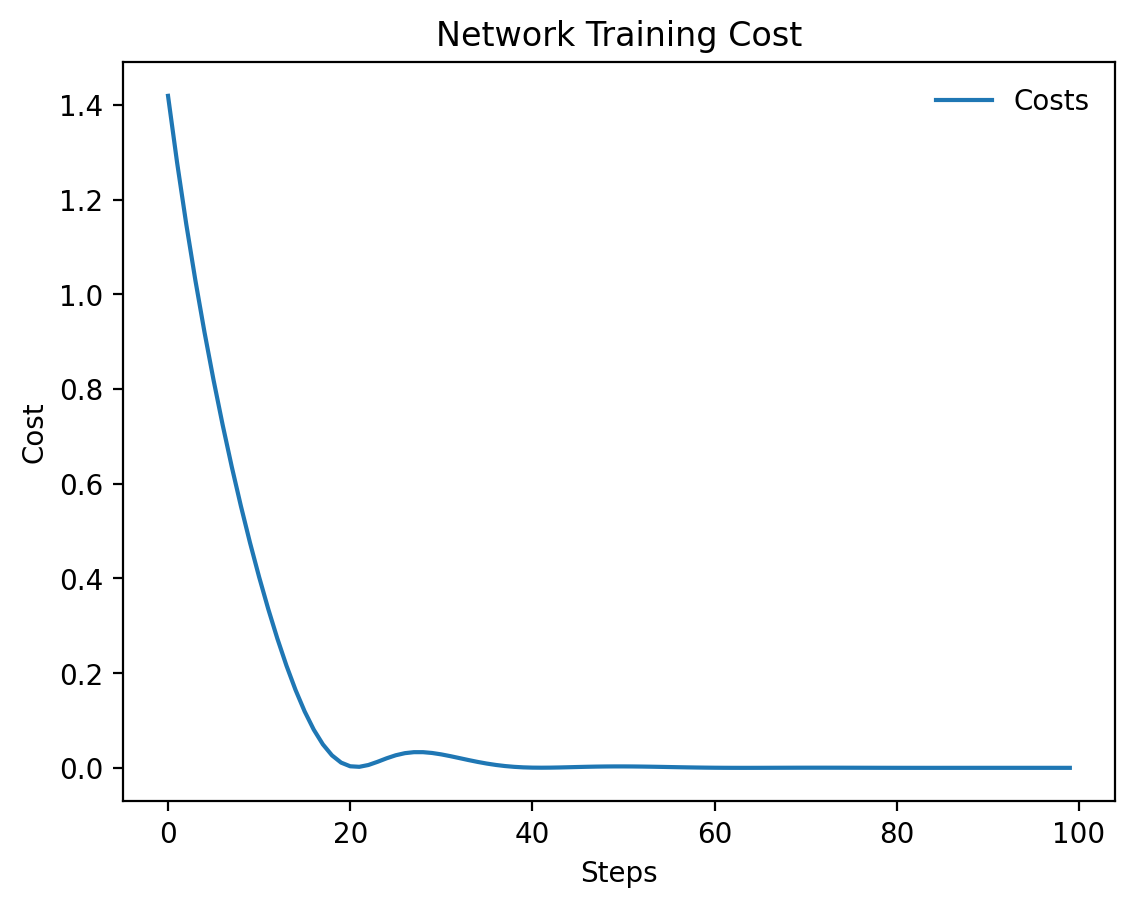

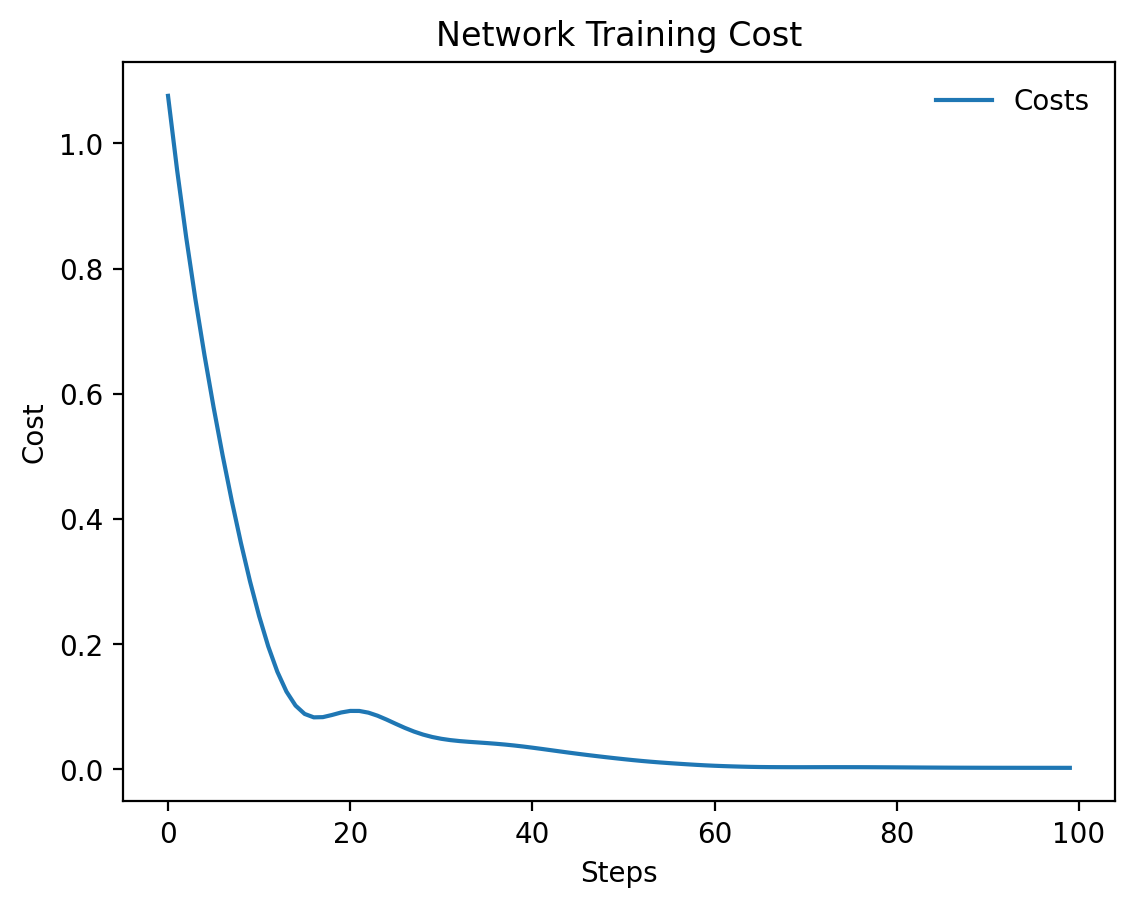

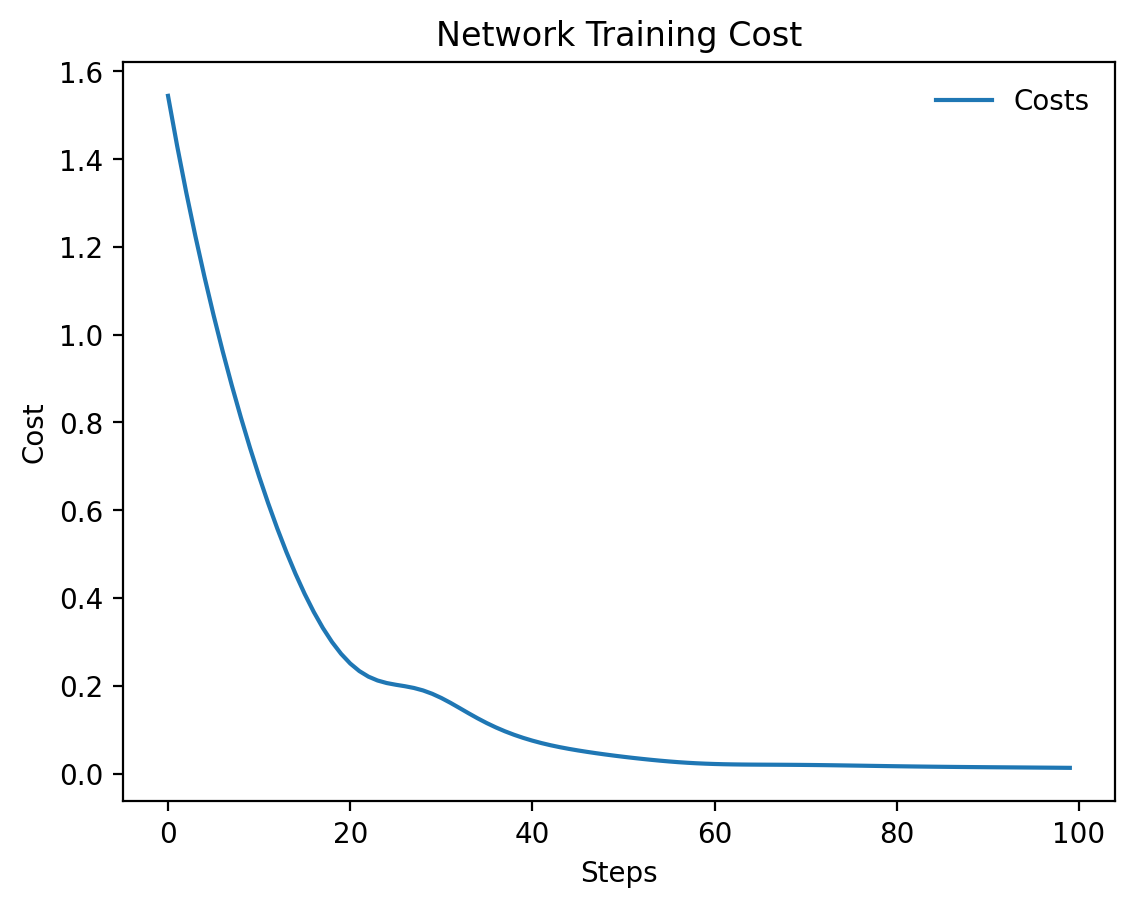

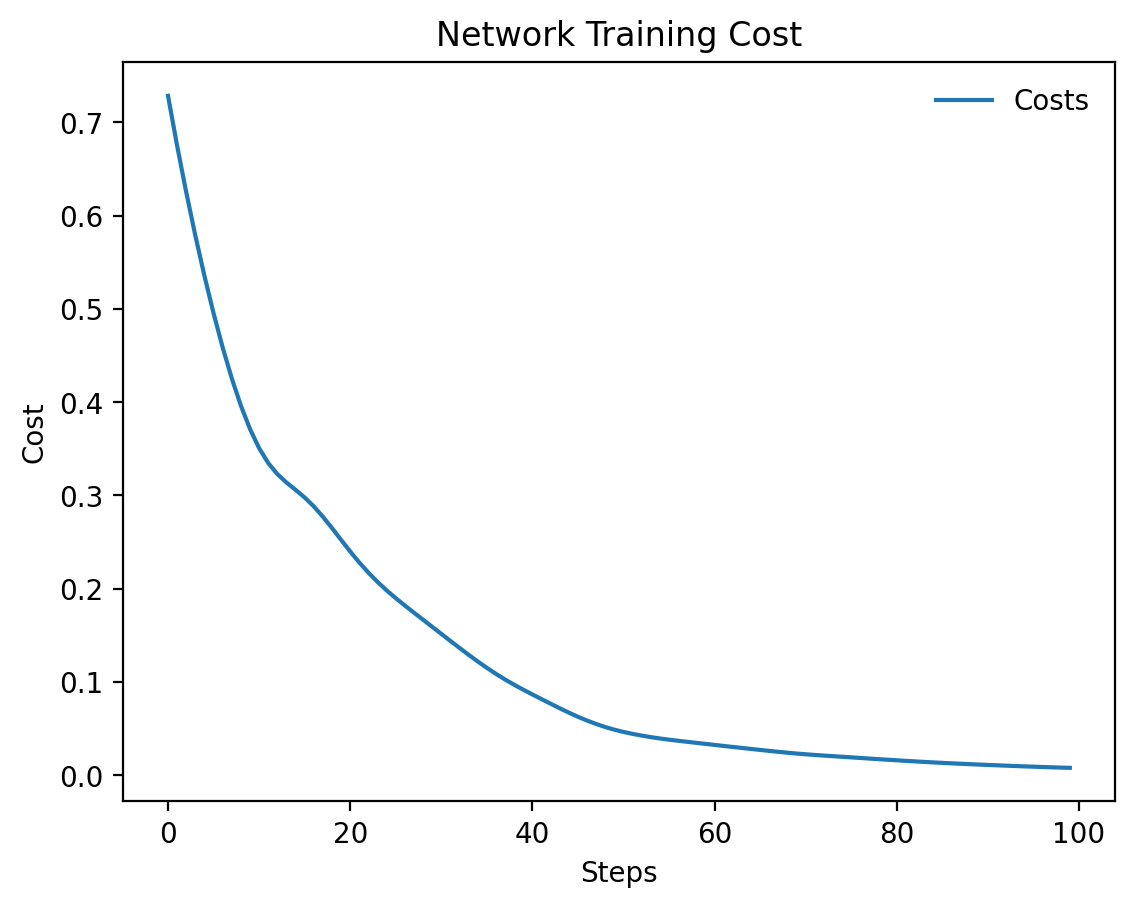

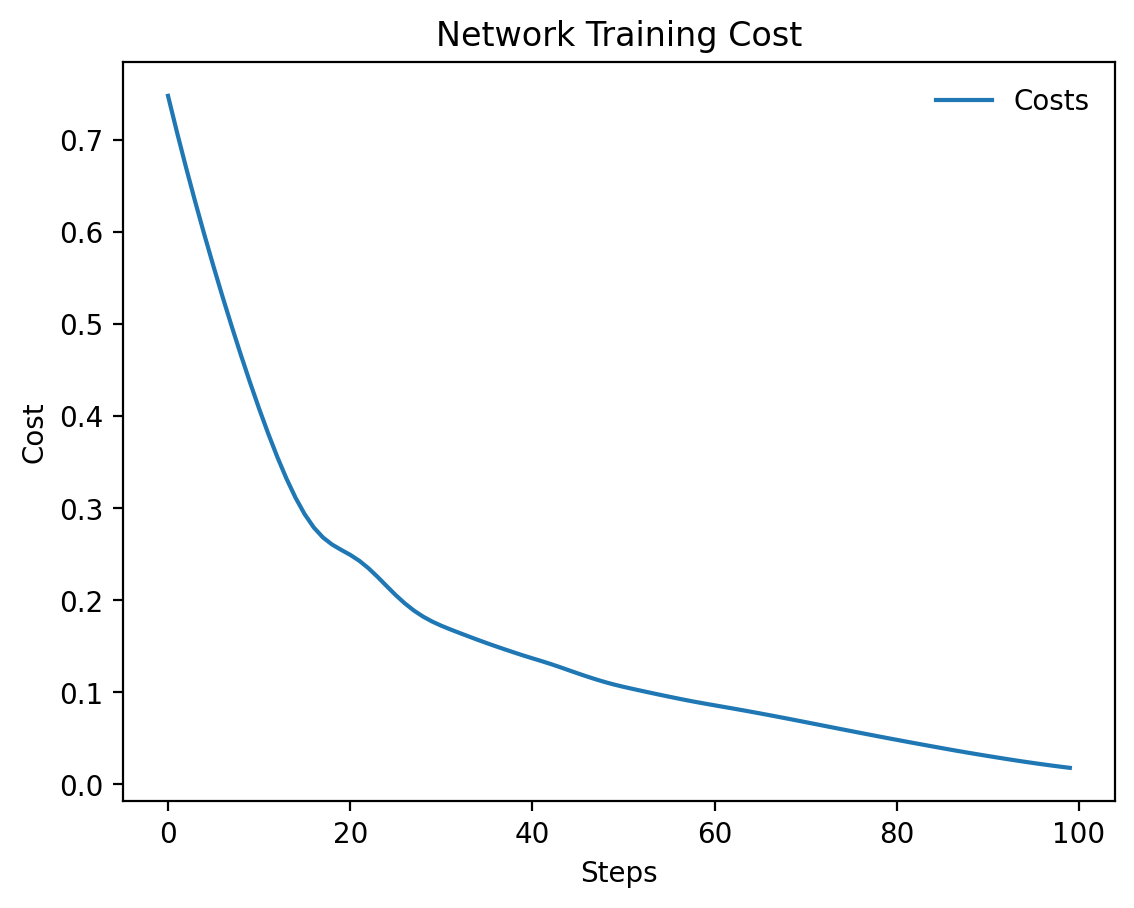

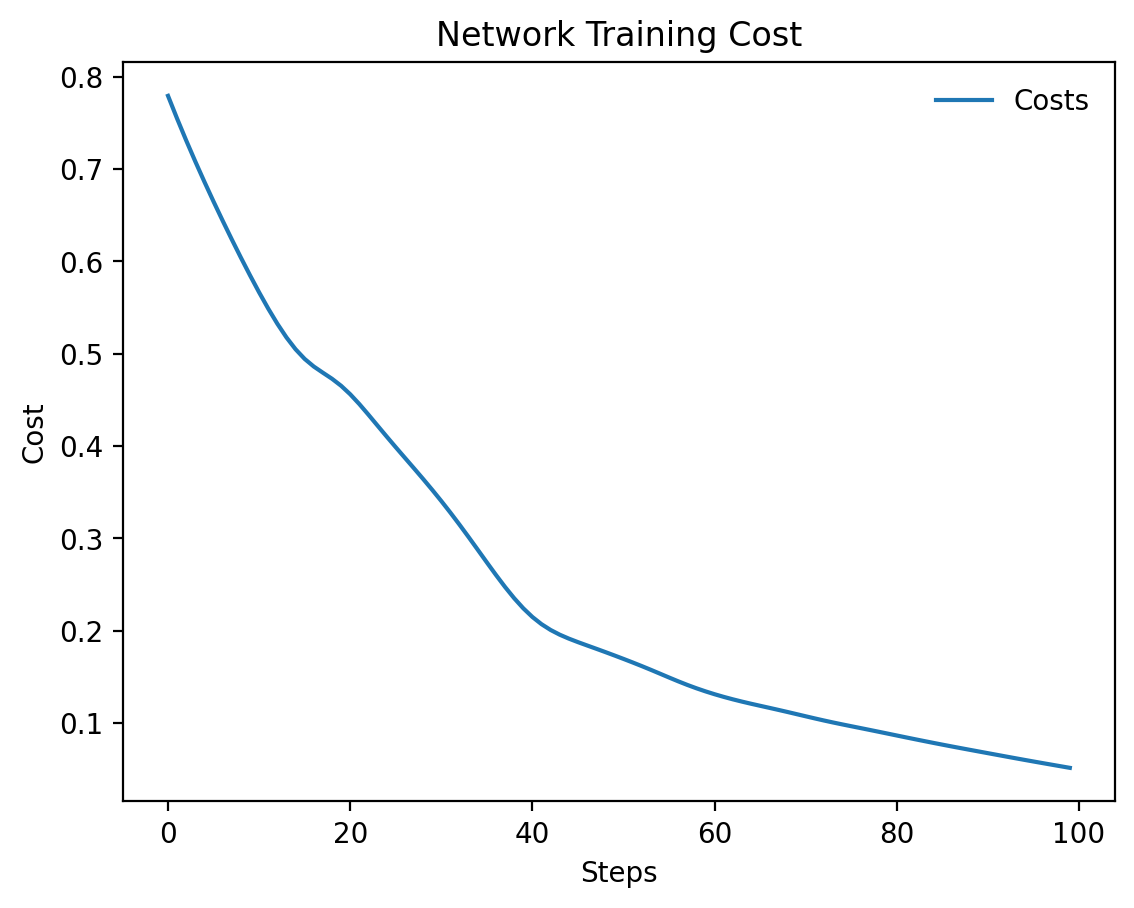

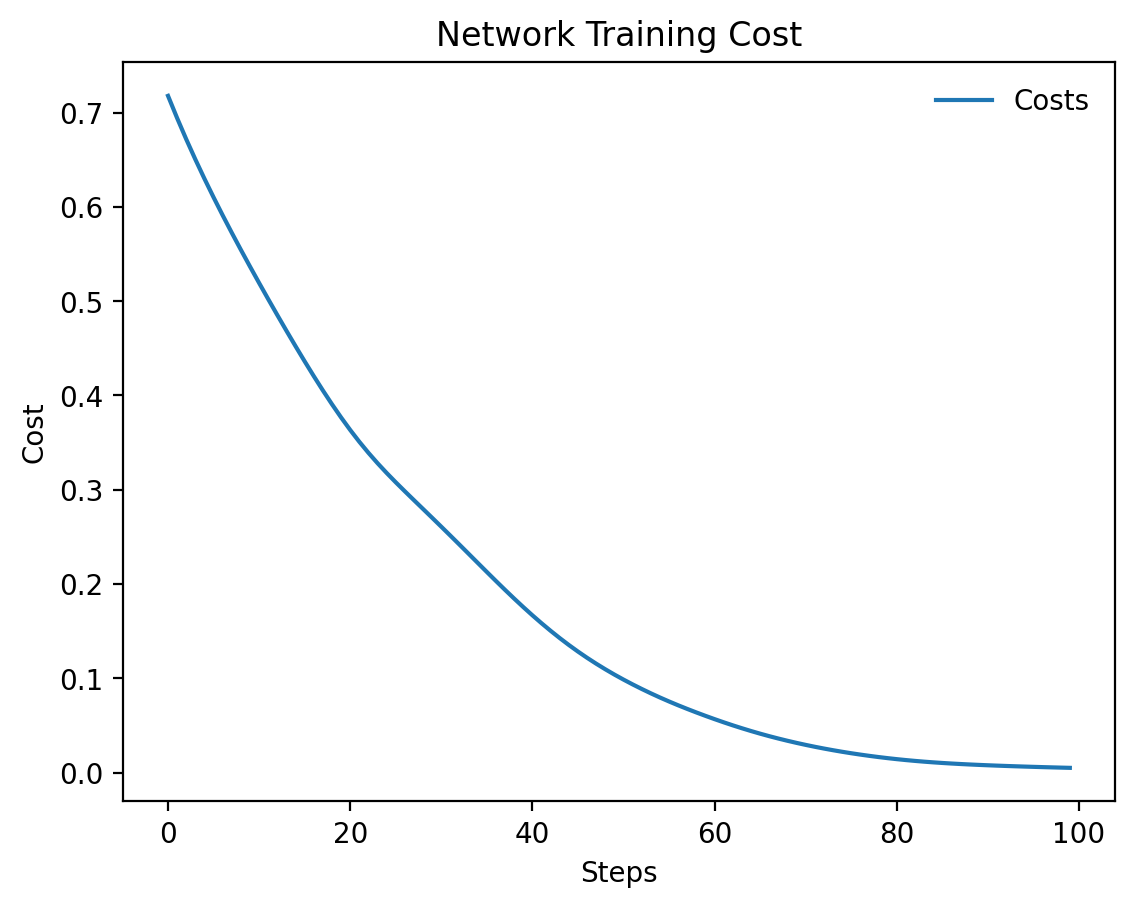

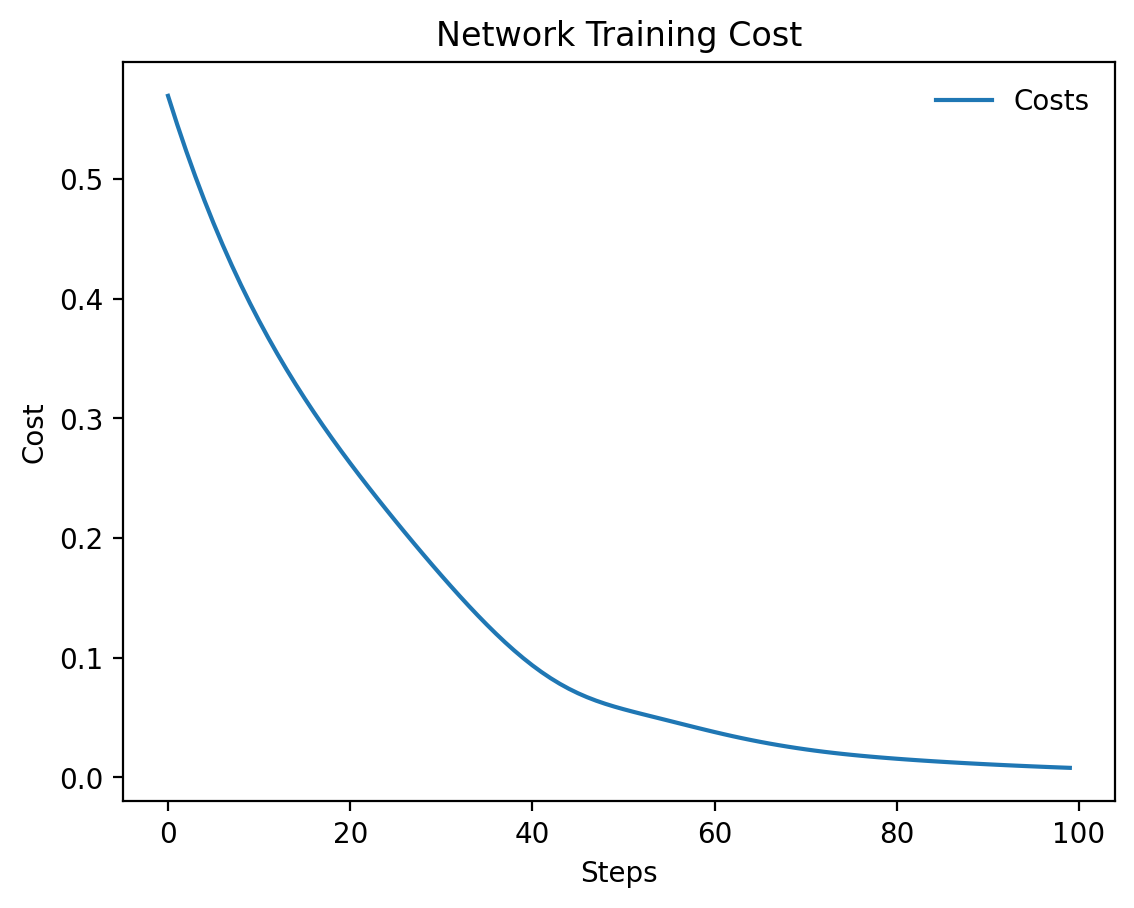

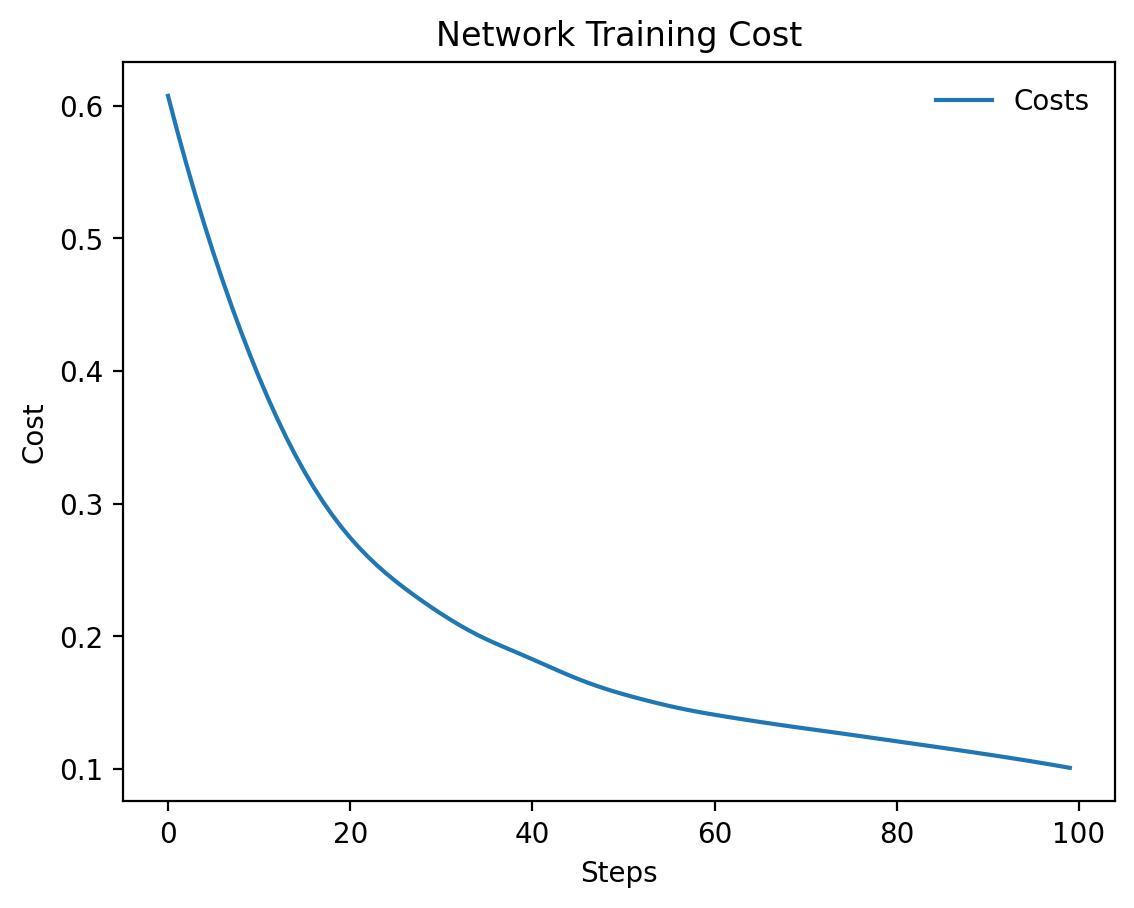

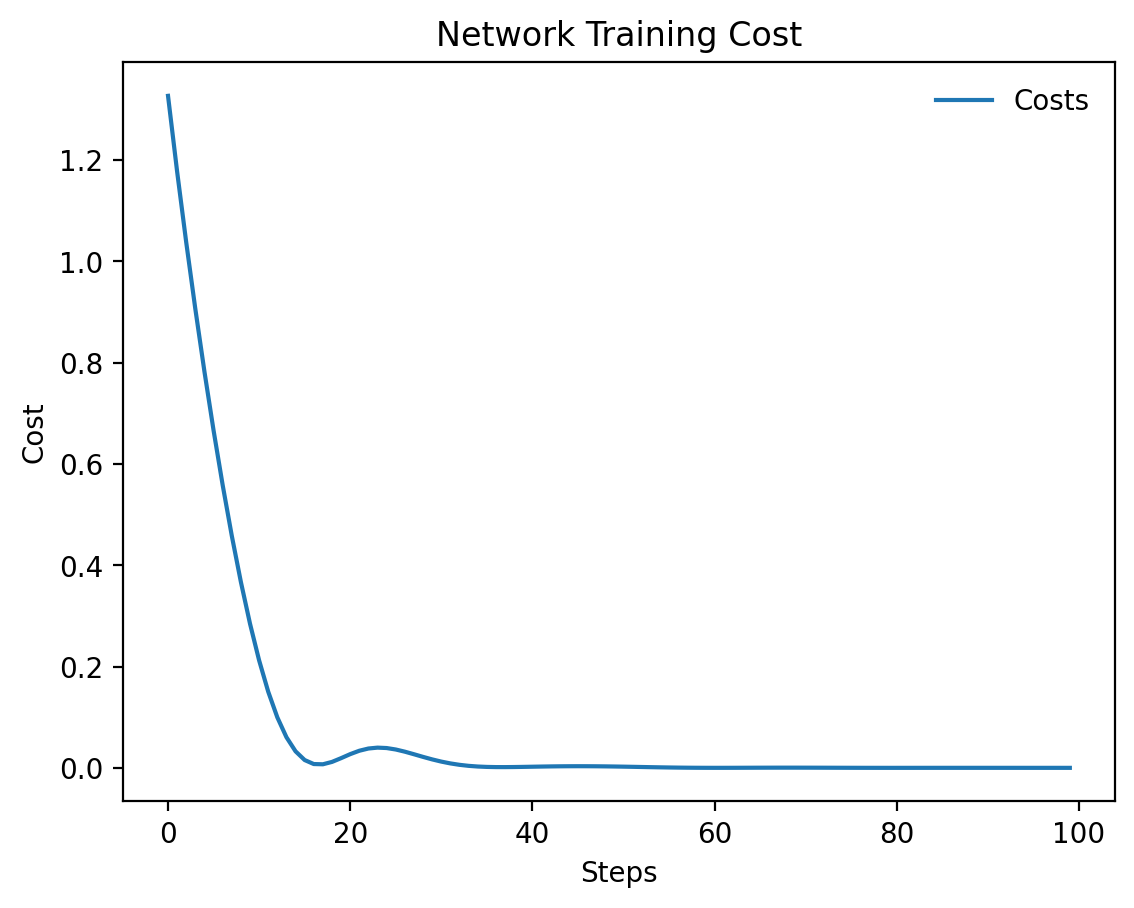

In [ ]:
# Set your windowsize and offset values
windowsize = 30
offset = 20
steps = 100

# Initialize arrays to store theta values and final costs
theta_values = np.linspace(0.001, np.pi, 10)
final_costs = []

for theta in theta_values:
    x1, y1, x2, y2 = stability(theta, 0)
    costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model(x1, x2, y1, y2, windowsize, offset,steps)
    final_costs.append(costs[-1])

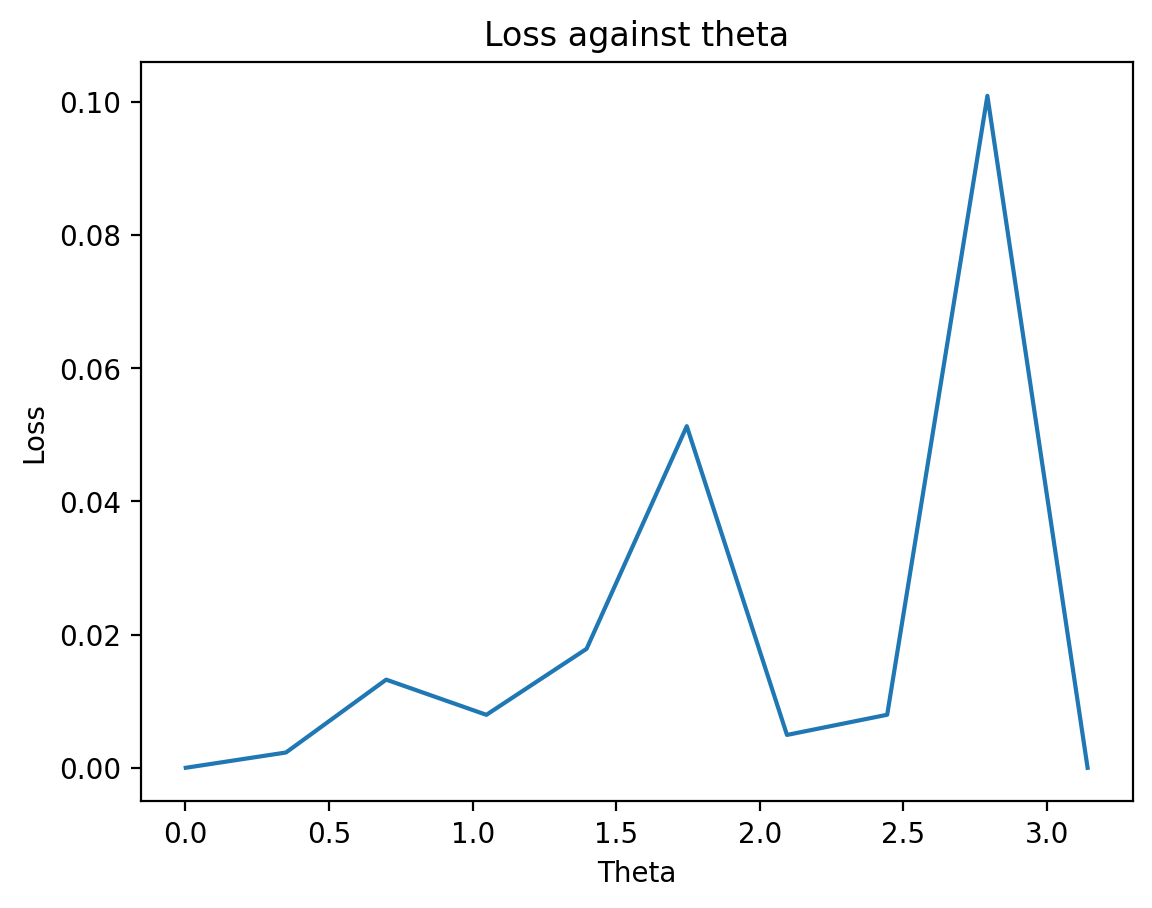

In [ ]:
plt.plot(theta_values, final_costs)
plt.xlabel("Theta")
plt.ylabel("Loss")
plt.title("Loss against theta")
plt.show()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 50)                11000     
                                                                 
 dense_33 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:08<00:00, 44.54it/s]


The final cost for training data is 0.30052509903907776


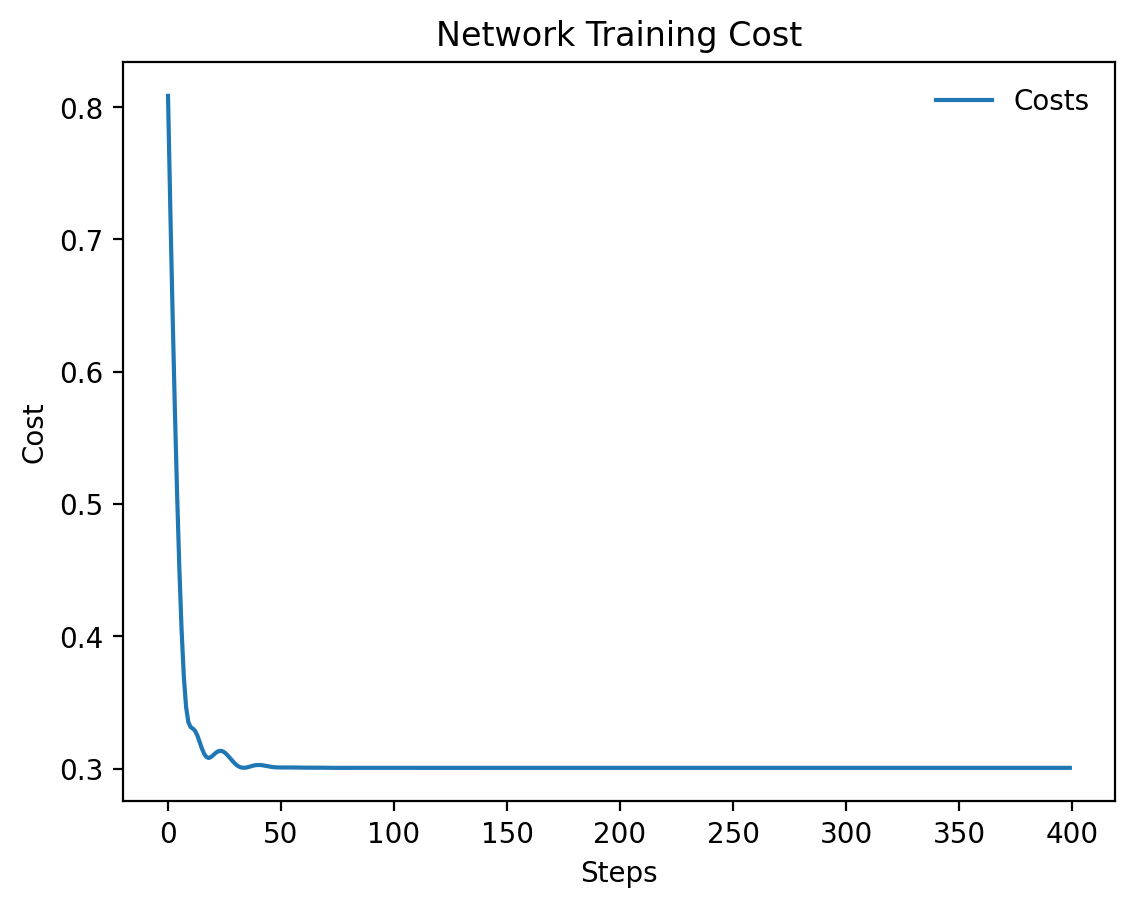

In [ ]:
# New offset to predict 100 into future
windowsize1= 30
offset1= 100
steps = 400

# Predicts future motion using function
costs3, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model(x1, x2, y1, y2, windowsize, offset1,steps)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 50)                11000     
                                                                 
 dense_34 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 42.16it/s]


The final cost for training data is 0.0006009926437400281
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 50)                11000     
                                                                 
 dense_35 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 40.88it/s]


The final cost for training data is 0.00012775923823937774
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 50)                11000     
                                                                 
 dense_36 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:11<00:00, 35.12it/s]


The final cost for training data is 0.00019612544565461576
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 50)                11000     
                                                                 
 dense_37 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:10<00:00, 39.33it/s]


The final cost for training data is 0.0001609514729352668
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 50)                11000     
                                                                 
 dense_38 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 40.22it/s]


The final cost for training data is 0.0001665703020989895
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 50)                11000     
                                                                 
 dense_39 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 400/400 [00:09<00:00, 40.80it/s]


The final cost for training data is 6.31246657576412e-05


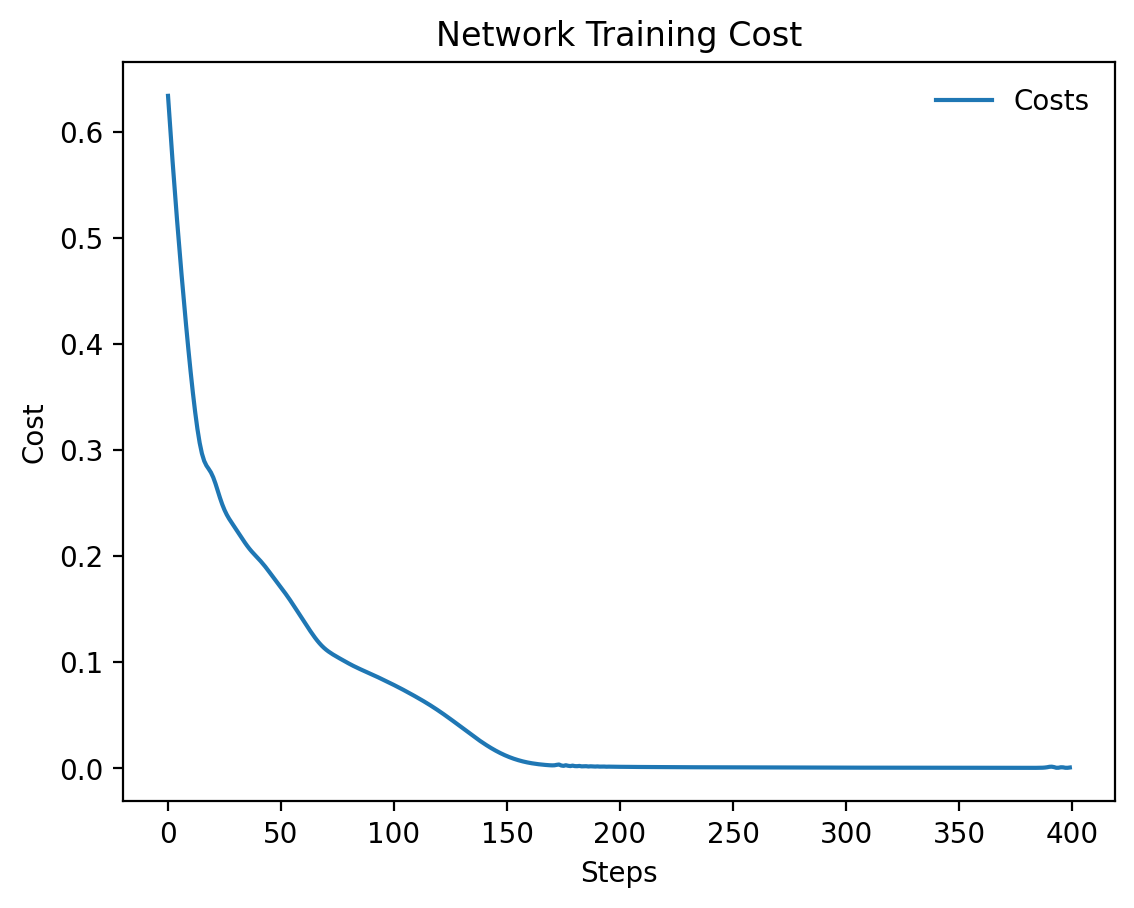

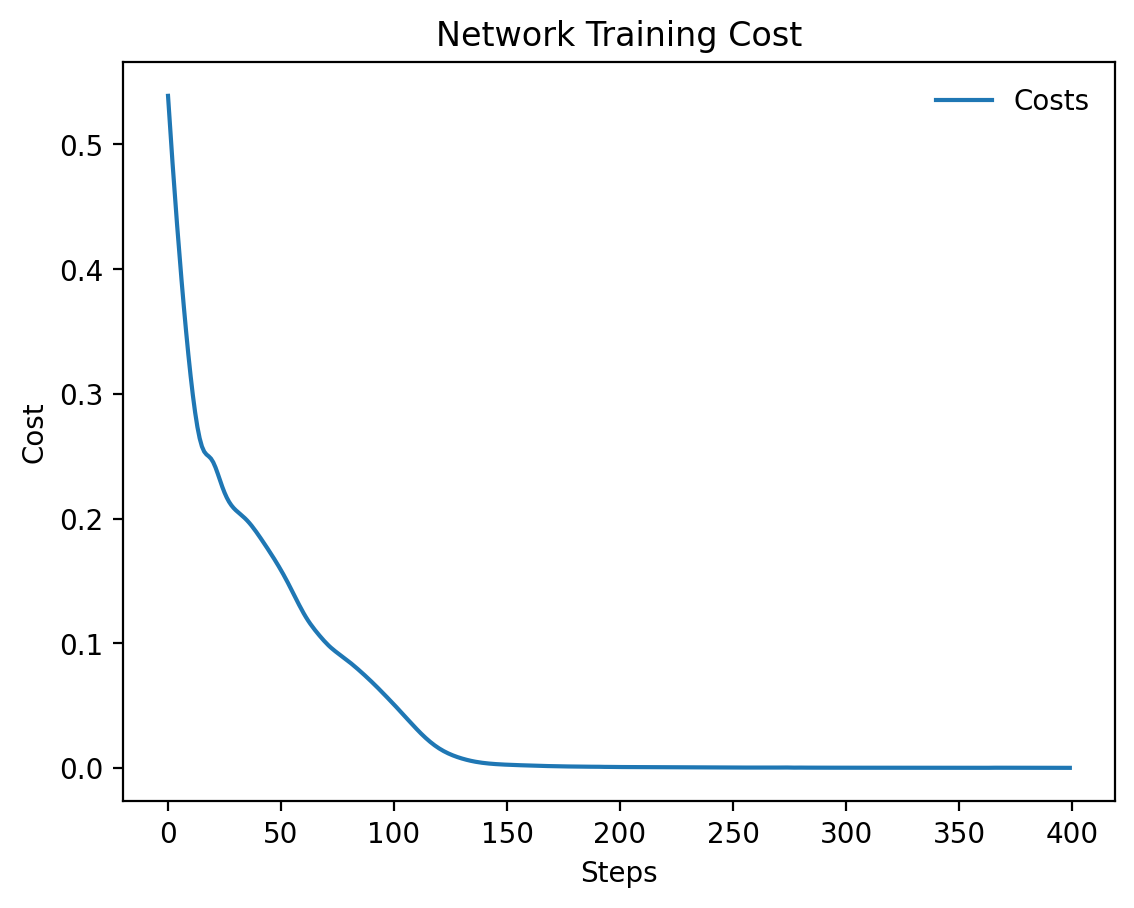

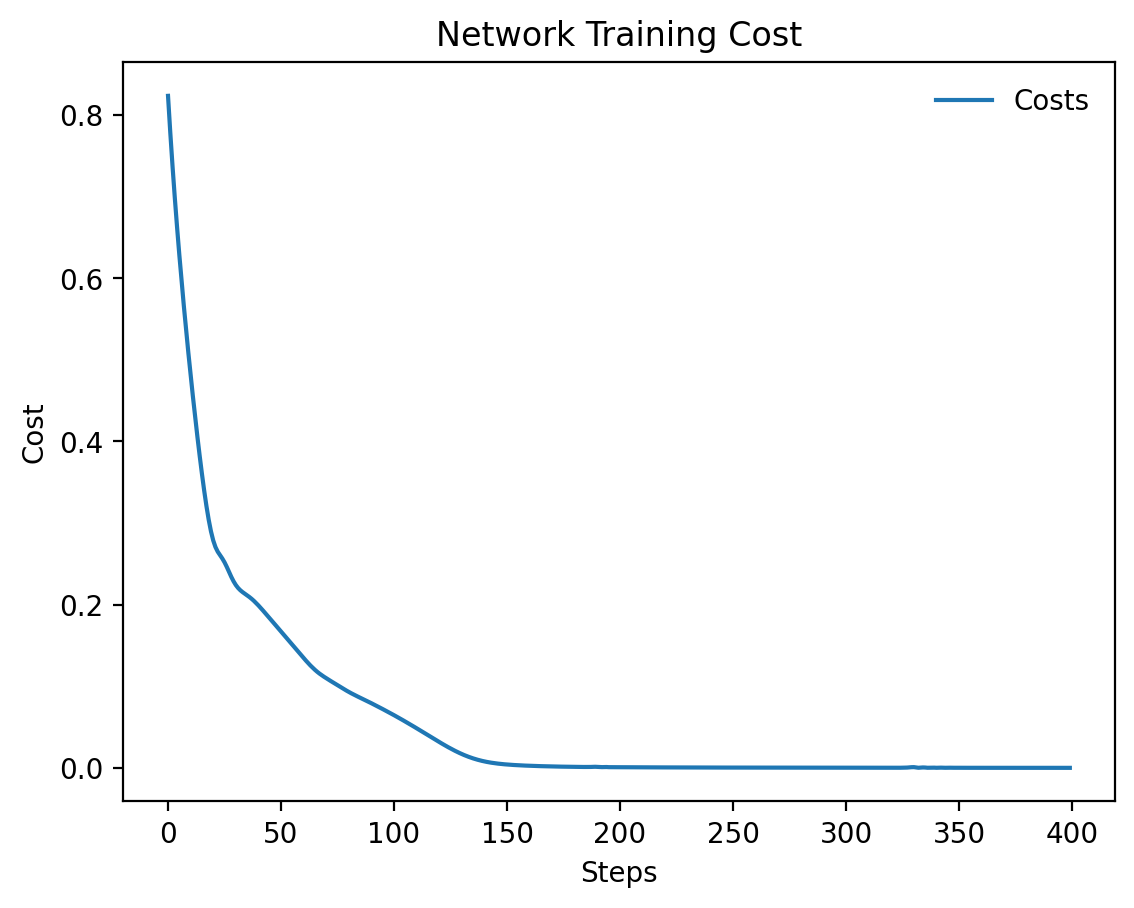

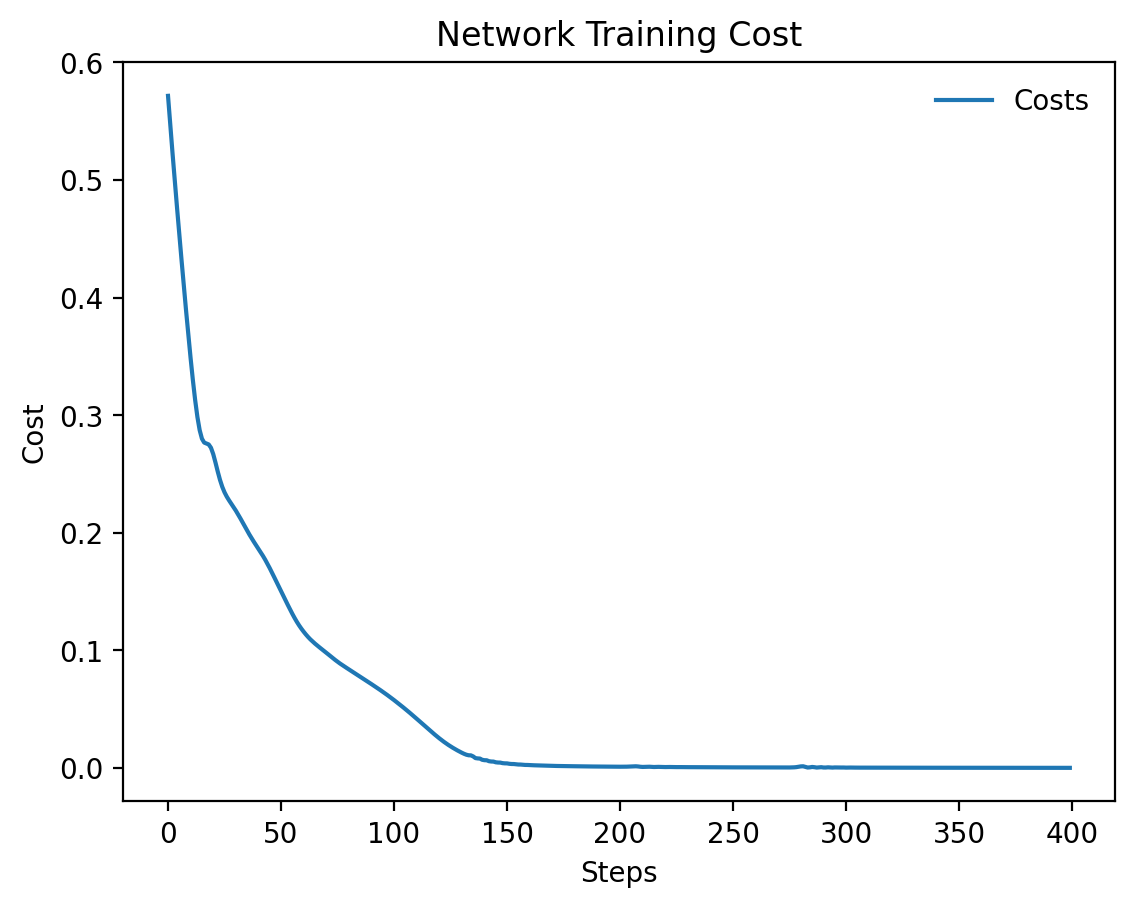

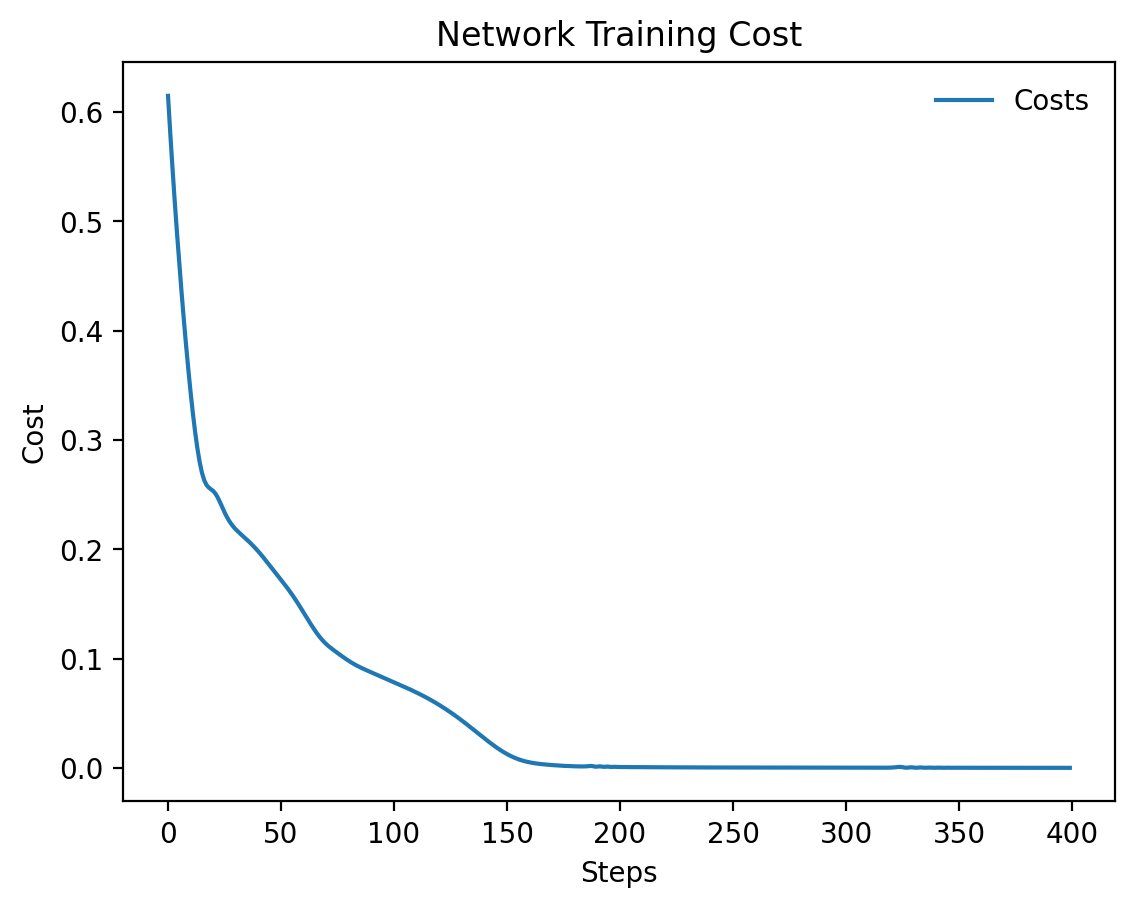

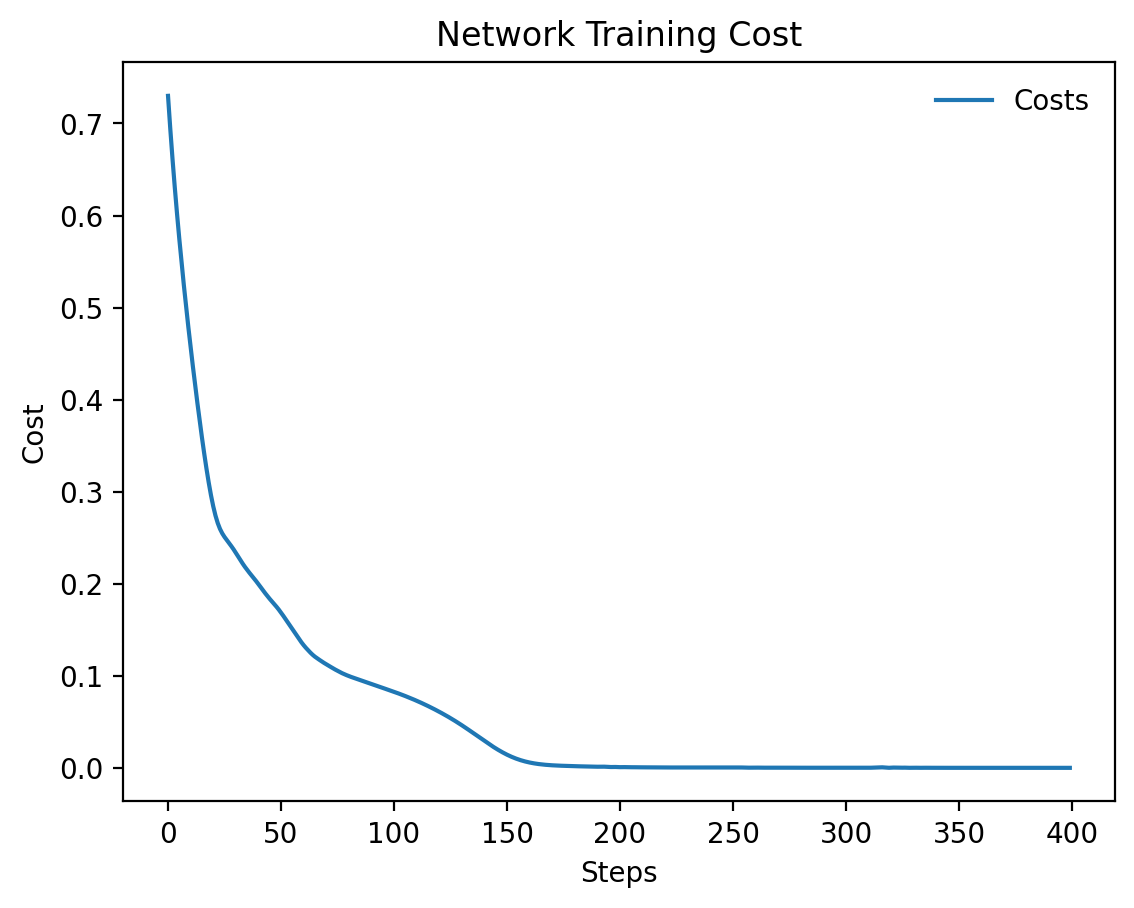

In [ ]:
# Range of offsets
offsets1 = np.linspace(20,100,6)

# Initialize arrays to store theta values and final costs
final_costs = []

for offset in offsets1:
    x1, y1, x2, y2 = stability(np.pi/2, 0)
    costs3, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model(x1, x2, y1, y2, windowsize, offset1,steps)
    final_costs.append(costs3[-1])

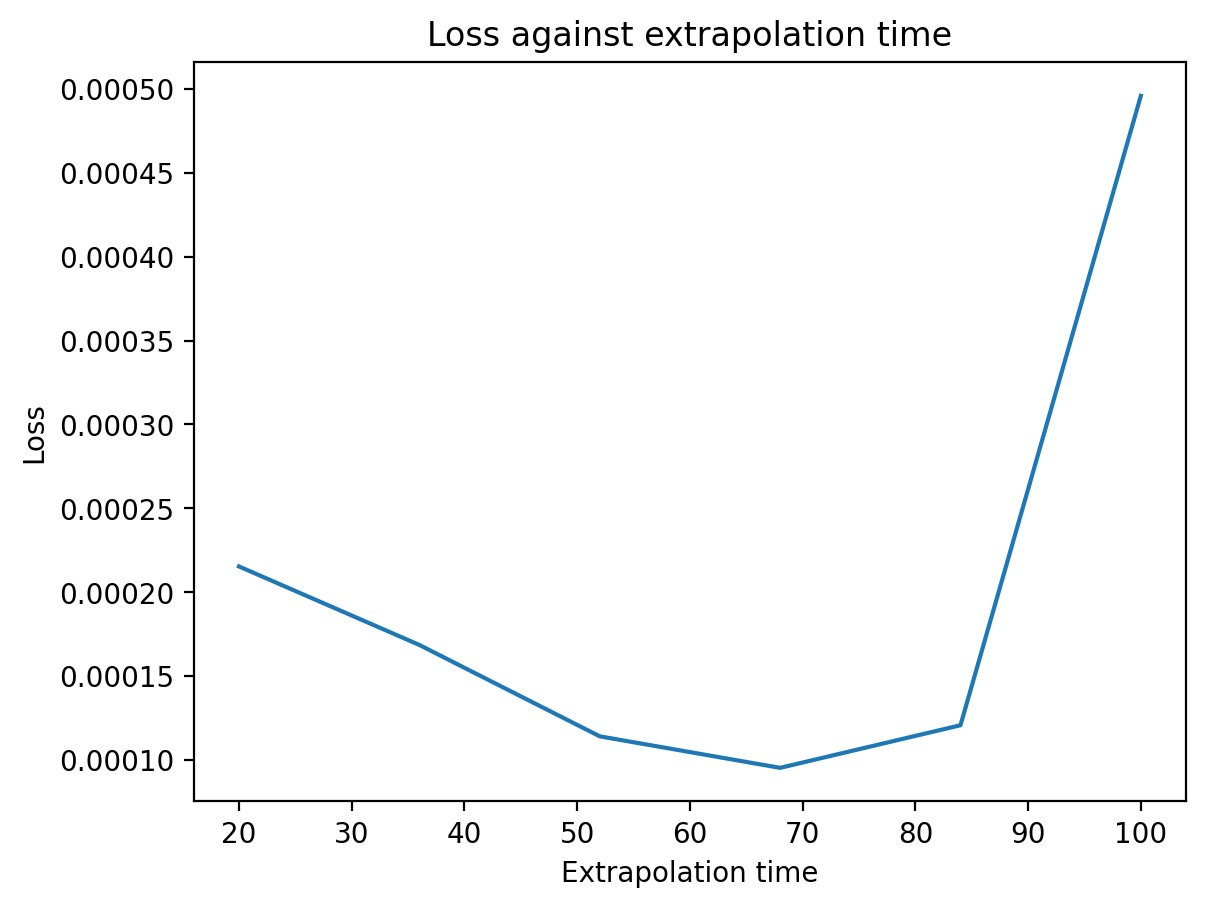

In [ ]:
plt.plot(offsets1, final_costs)
plt.xlabel("Extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

## Comment:
We can see that the cost grows with extrapolation time, showing that the model becomes less accurate with time.

## Part 5
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 50)                10600     
                                                                 
 dense_40 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 41.16it/s]


The final cost for training data is 0.00013904020306654274


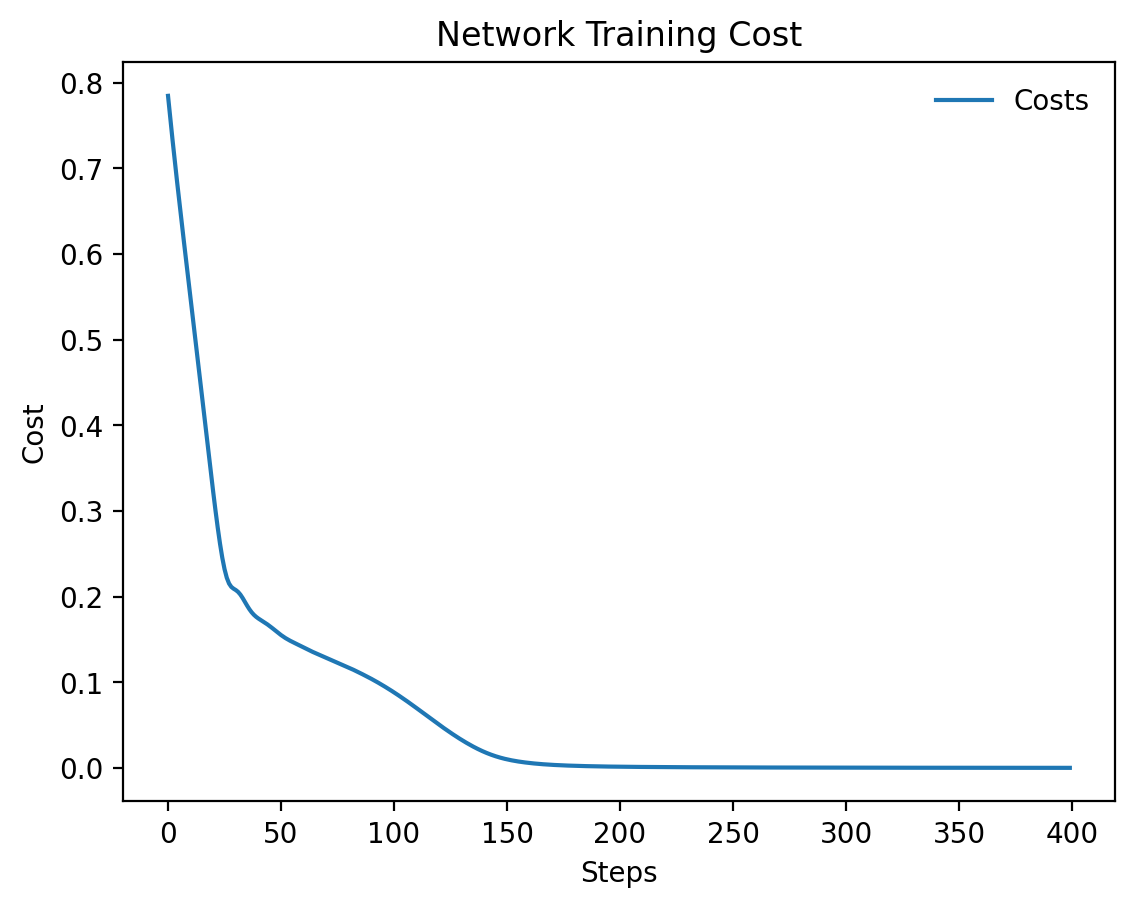

In [ ]:
def build_model2(x1, x2, y1, y2, windowsize, offset,steps):

    model2 = keras.models.Sequential()
    model2.add(keras.layers.LSTM(50, input_shape=(None, 2), return_sequences=False))  # LSTM layer with 50 neurons
    model2.add(keras.layers.Dense(4, activation="linear"))
    model2.compile(loss='mean_squared_error', optimizer='adam')
    model2.summary()

    # Stack coordinates such that we have an array of the coordinate of all coordinates at each time step
    xy = np.stack((x1,y1,x2,y2), axis = 1)

    # Reshape the data into (batchsize, timesteps, data)
    xyInput, xyLabel = shapeArray(xy, windowsize, offset)

    # Create training sample only including up to t0( windowsize*dt)
    xyTrain  = xyInput[:windowsize,:,2:]

    # Create training target only including up to t0( windowsize*dt), and last time step in label batch
    xyTarget = xyLabel[:windowsize,-1]

    print("Shape of xyTrain:", xyTrain.shape)
    print("Shape of xyTarget:", xyTarget.shape)

    # Empty array for cost along each step
    costs = np.zeros(steps)

    for i in tqdm(range(steps)):
        # Train the network and append to 'costs' empty array
        costs[i] = model2.train_on_batch(xyTrain, xyTarget)

    # Test data includes whole data range beyond window size
    xyTest = xyInput[:,:,2:]

    predictions = model2.predict_on_batch(xyTest)

    # Retrieve predicted coordinates from predicted array
    x1_hat, y1_hat = predictions[:,0], predictions[:,1]
    x2_hat, y2_hat = predictions[:,2], predictions[:,3]

    # Plot costs vs steps
    fig, ax = plt.subplots()
    ax.plot(np.arange(steps), costs, label=r"Costs")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cost")
    ax.set_title("Network Training Cost")
    ax.legend()
    print("The final cost for training data is", costs[-1])

    return costs, (x1_hat, y1_hat, x2_hat, y2_hat)

costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model2(x1, x2, y1, y2, 30, 20, 400)

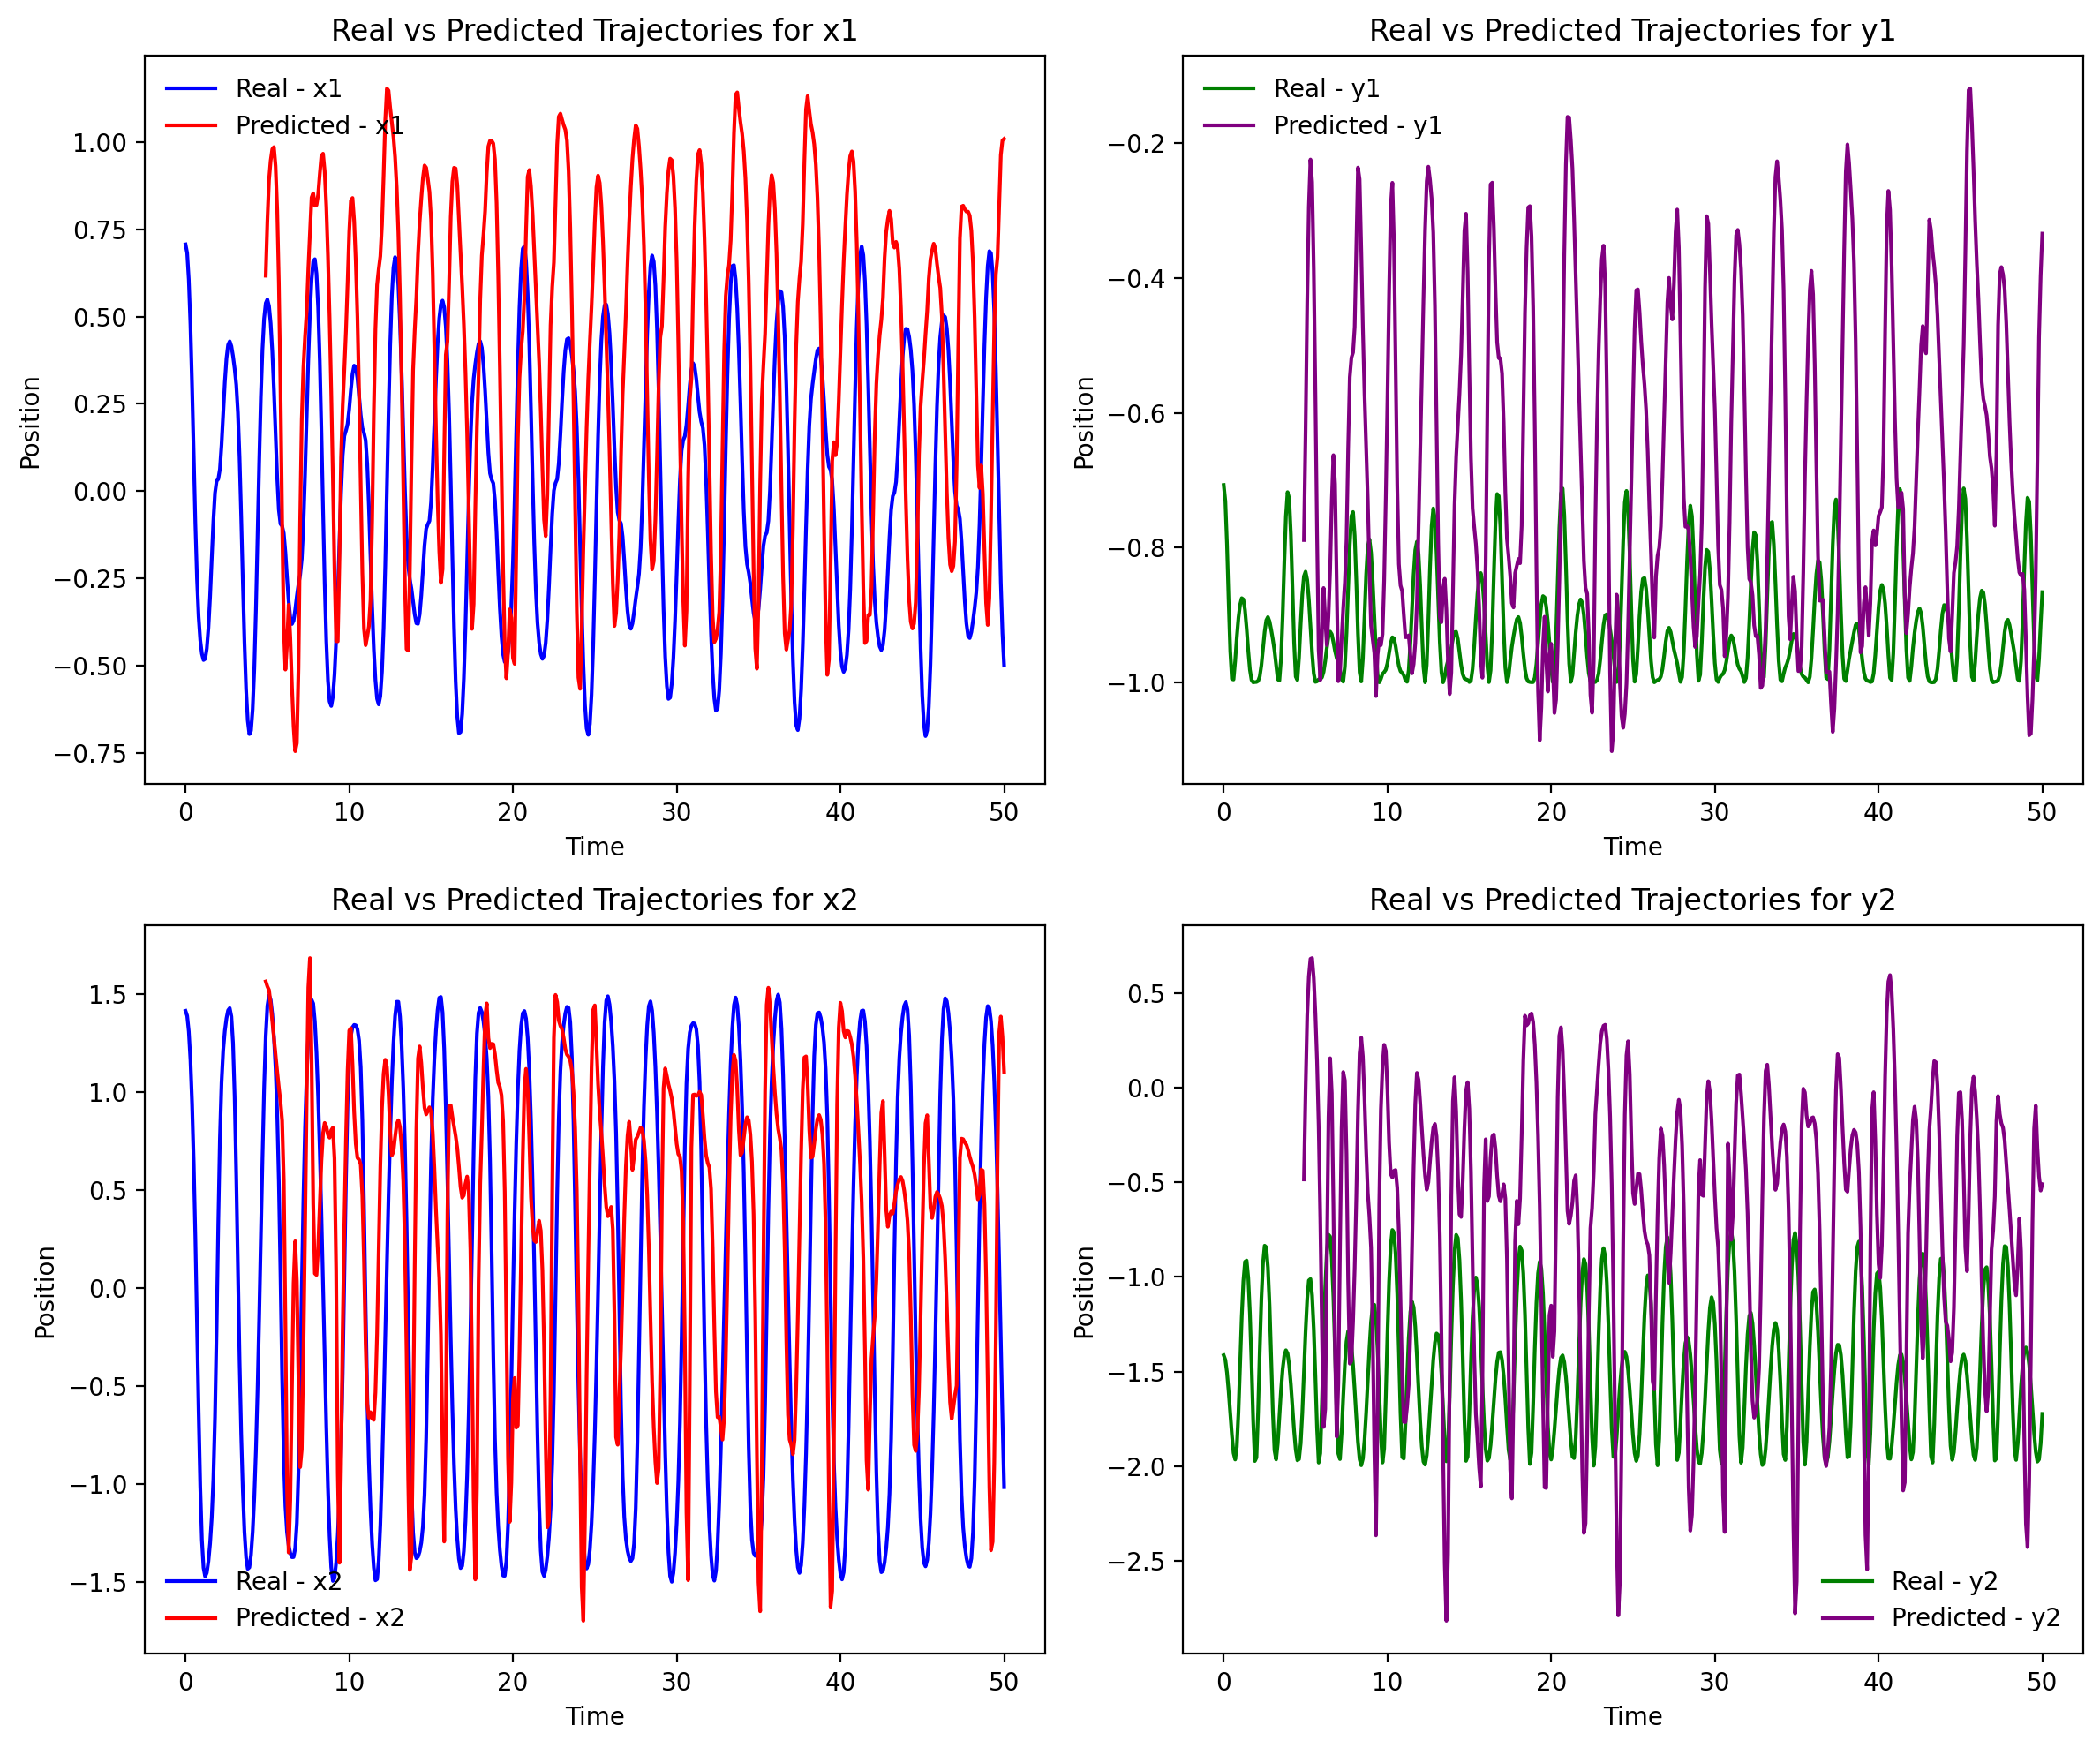

In [ ]:
# Number of samples we will use to train our network
windowsize= 30

# How many samples into the future to predict
offset= 20

x1,y1,x2,y2 = stability(np.pi/4,0)
timePlot(x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat,windowsize,offset)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 50)                10600     
                                                                 
 dense_41 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


The final cost for training data is 6.497731192212086e-06
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 50)                10600     
                                                                 
 dense_42 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


The final cost for training data is 0.003138866974040866
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 50)                10600     
                                                                 
 dense_43 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


The final cost for training data is 0.01306359563022852
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 50)                10600     
                                                                 
 dense_44 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


The final cost for training data is 0.008602956309914589
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 50)                10600     
                                                                 
 dense_45 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


The final cost for training data is 0.0897093117237091
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 50)                10600     
                                                                 
 dense_46 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


The final cost for training data is 0.08949094265699387
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 50)                10600     
                                                                 
 dense_47 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:04<00:00, 22.35it/s]


The final cost for training data is 0.0042021009139716625
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 50)                10600     
                                                                 
 dense_48 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


The final cost for training data is 0.007290055975317955
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 50)                10600     
                                                                 
 dense_49 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


The final cost for training data is 0.11140979081392288
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 50)                10600     
                                                                 
 dense_50 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


The final cost for training data is 1.3668787687493023e-05


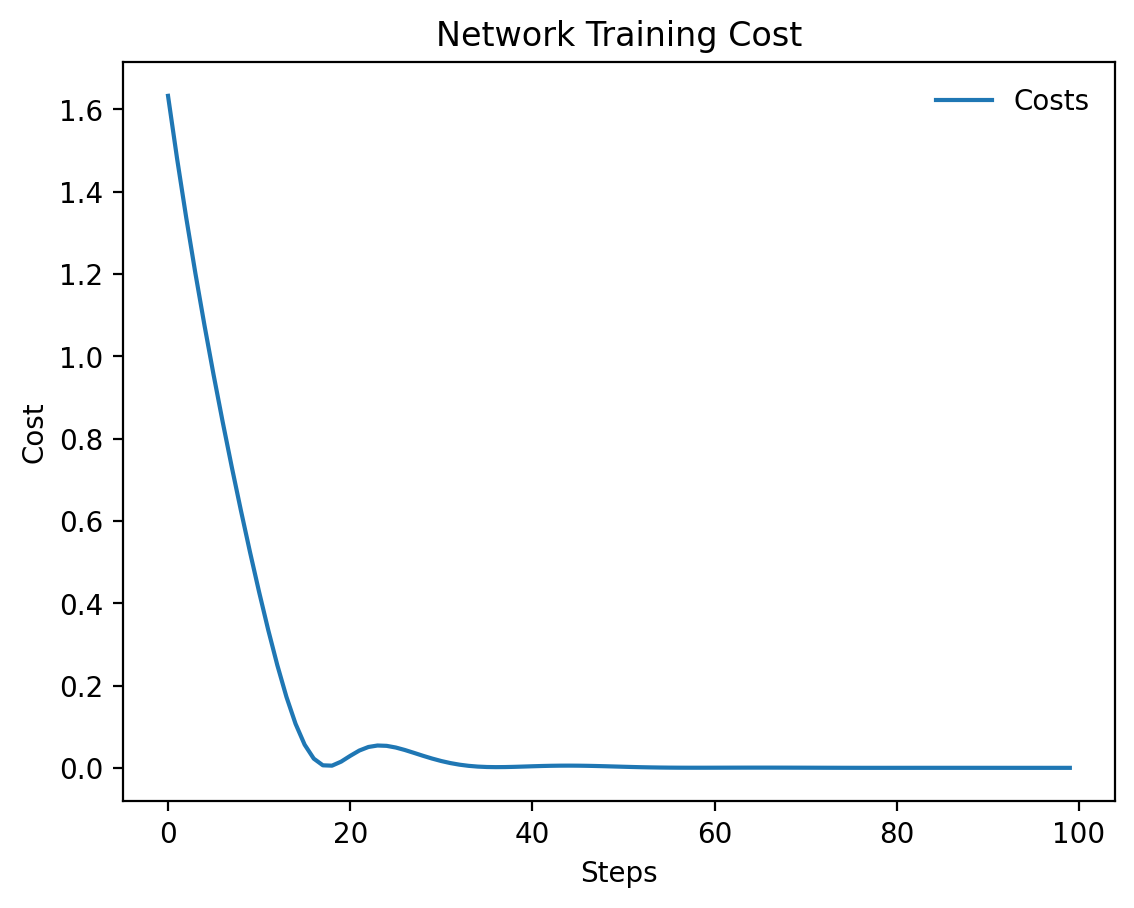

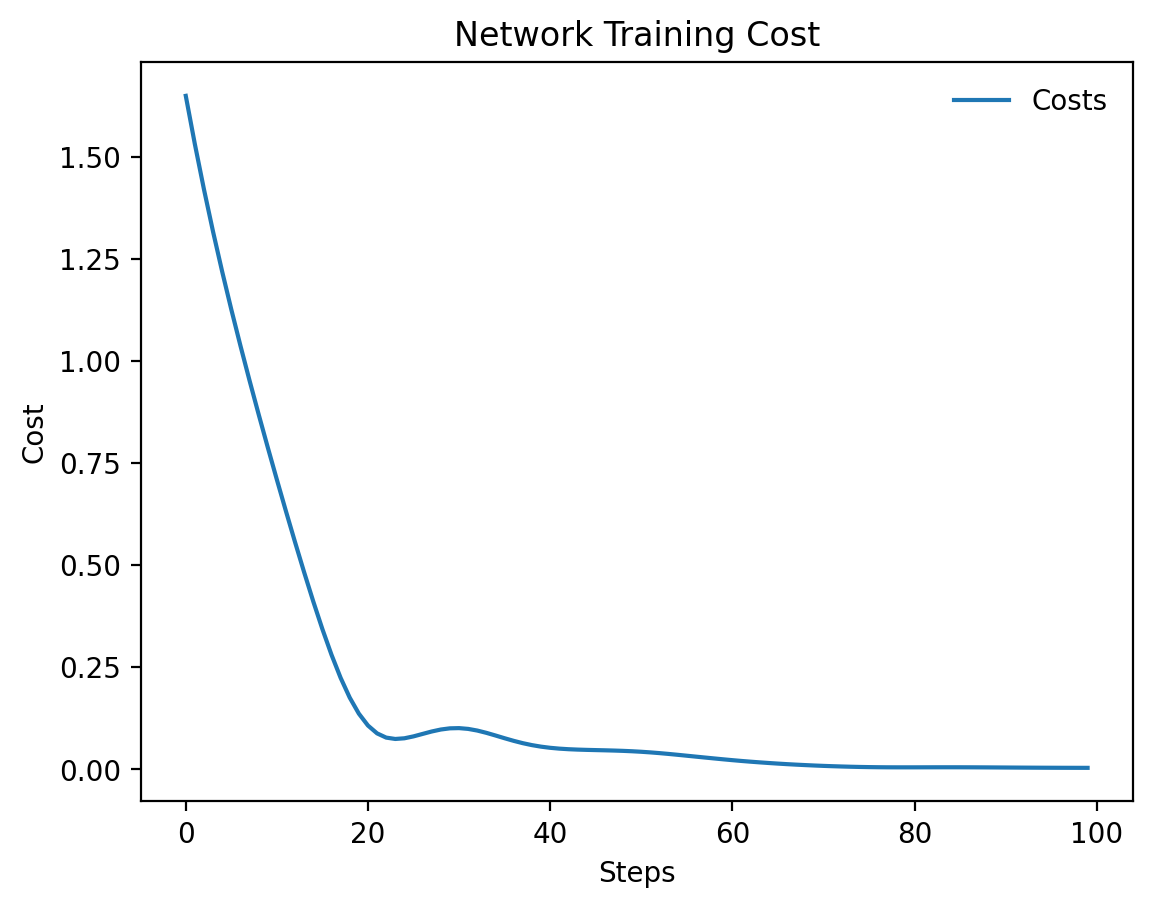

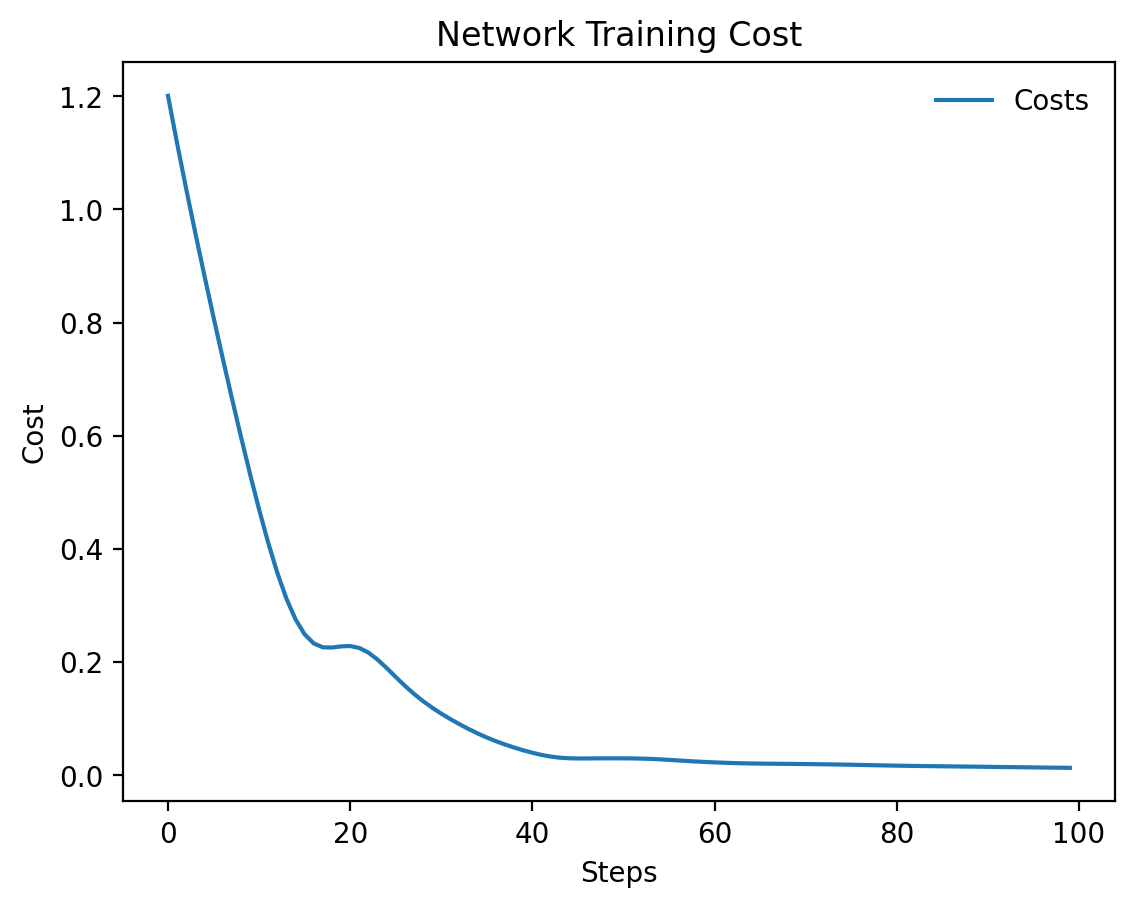

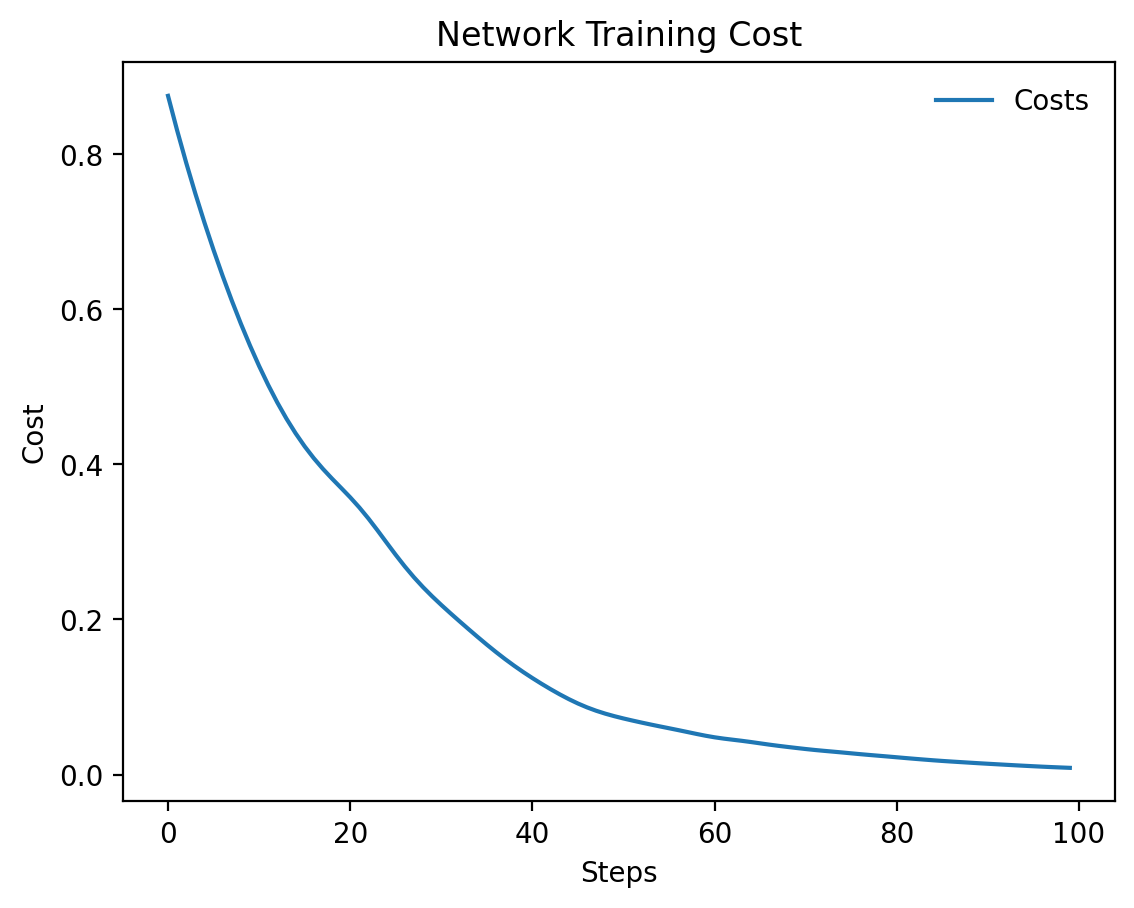

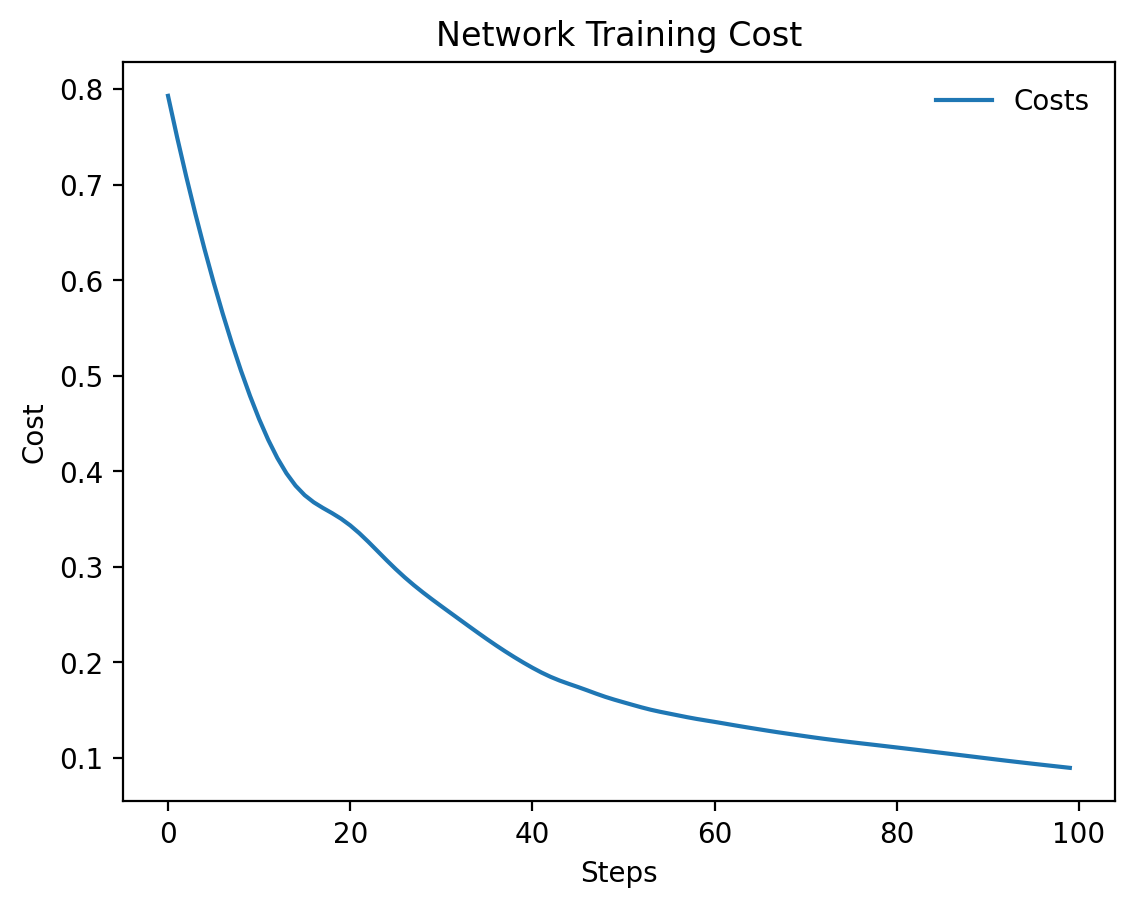

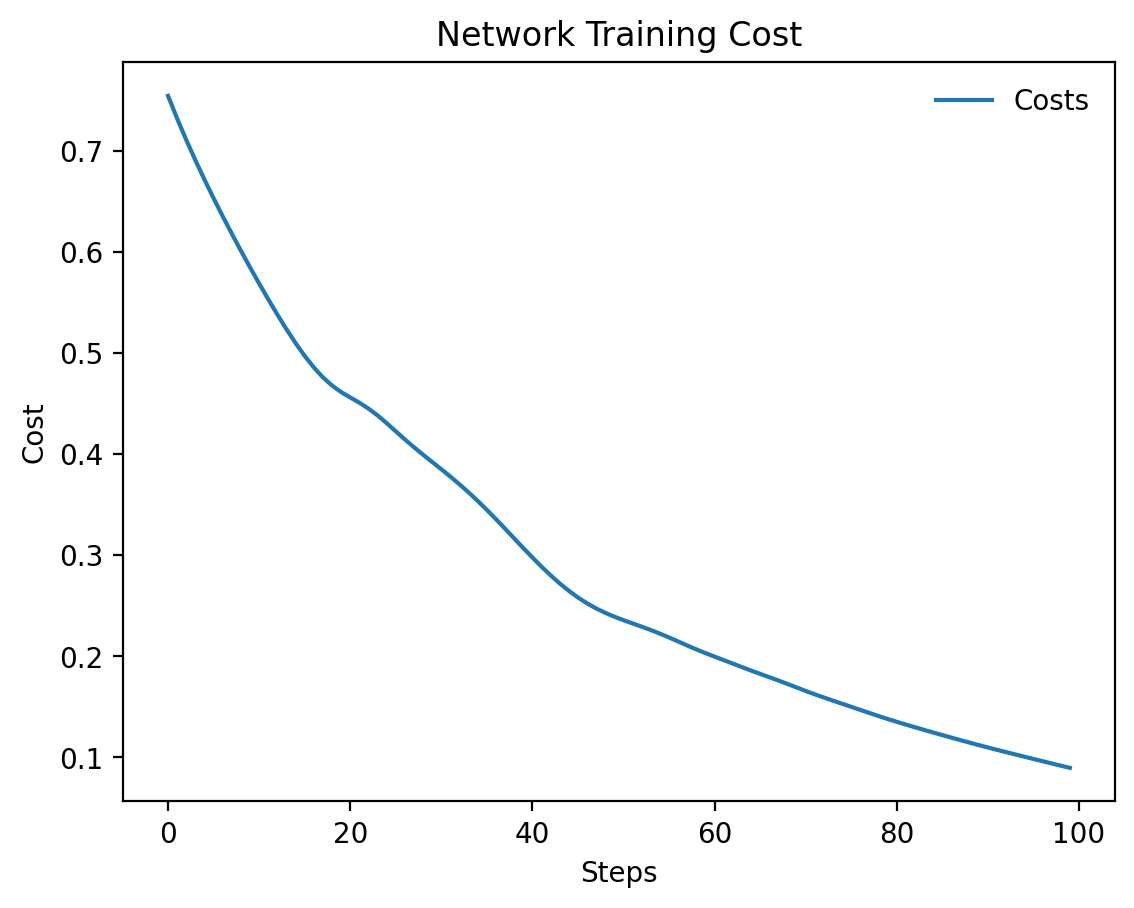

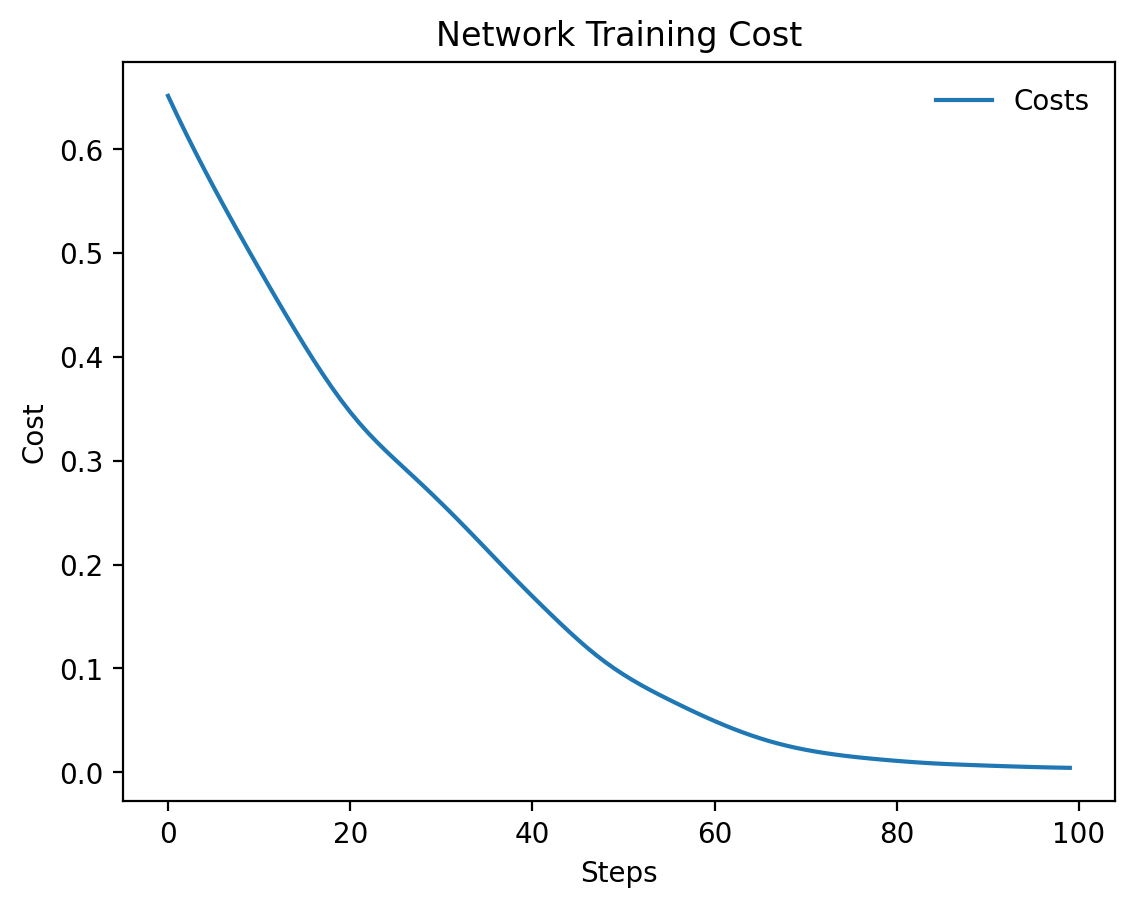

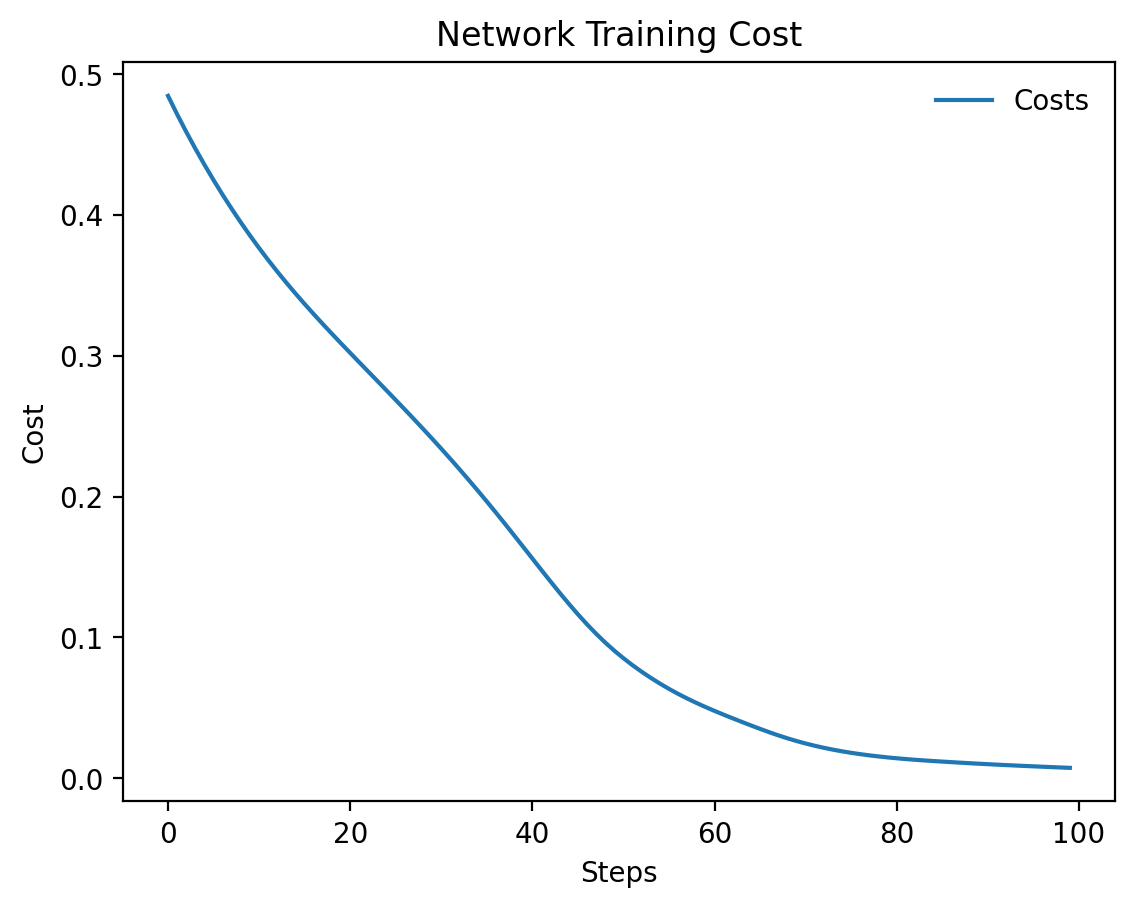

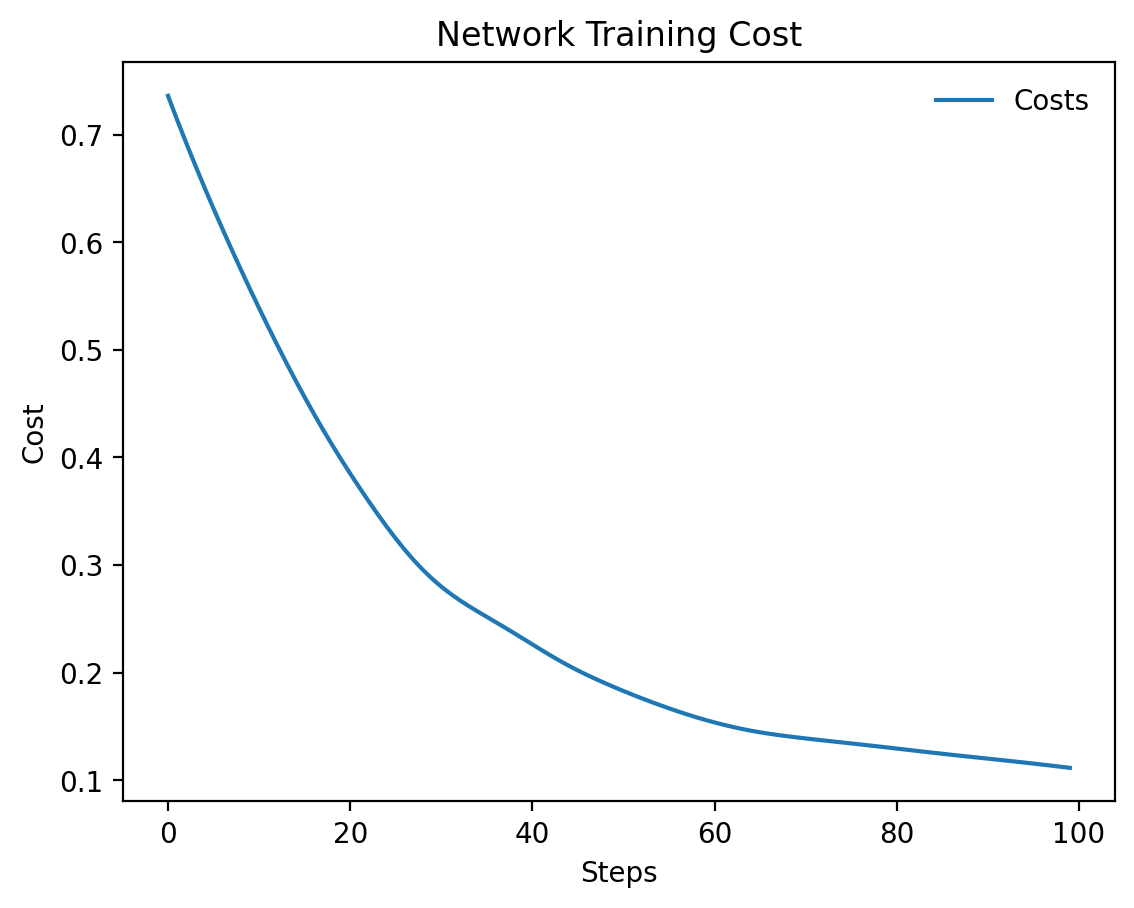

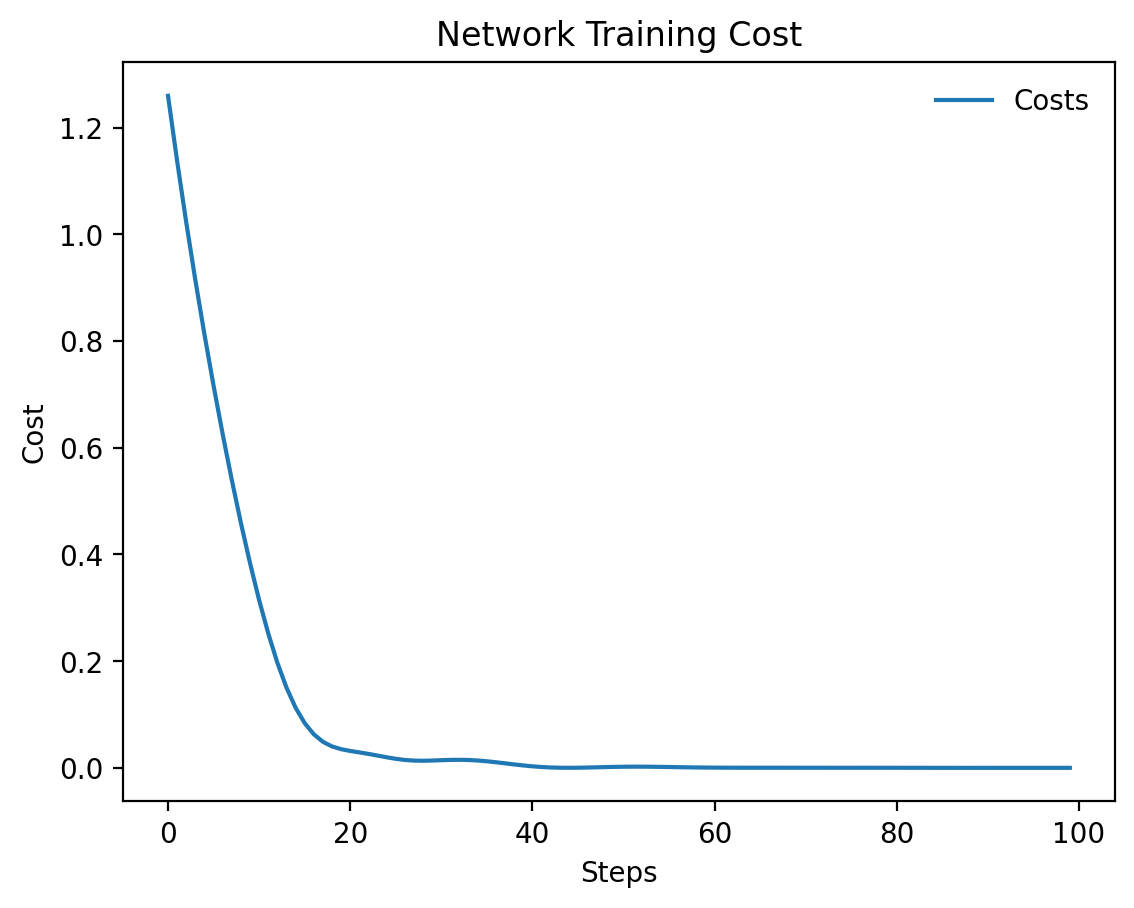

In [ ]:
# Set your windowsize and offset values
windowsize = 30
offset = 20
steps = 100

# Initialize arrays to store theta values and final costs
theta_values = np.linspace(0.001, np.pi, 10)
final_costs = []

for theta in theta_values:
    x1, y1, x2, y2 = stability(theta, 0)
    costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model2(x1, x2, y1, y2, windowsize, offset,steps)
    final_costs.append(costs[-1])

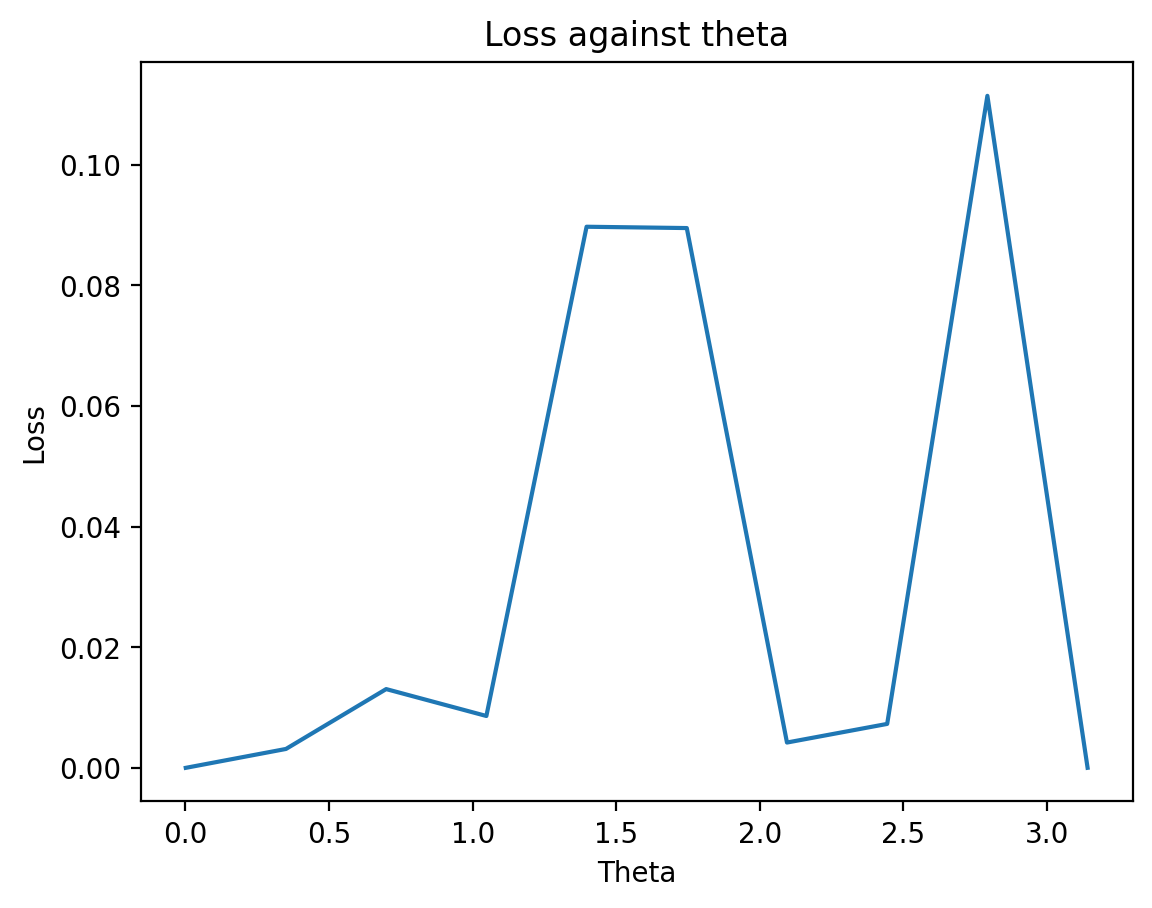

In [ ]:
plt.plot(theta_values, final_costs)
plt.xlabel("Theta")
plt.ylabel("Loss")
plt.title("Loss against theta")
plt.show()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 50)                10600     
                                                                 
 dense_51 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 40.39it/s]


The final cost for training data is 0.30052509903907776


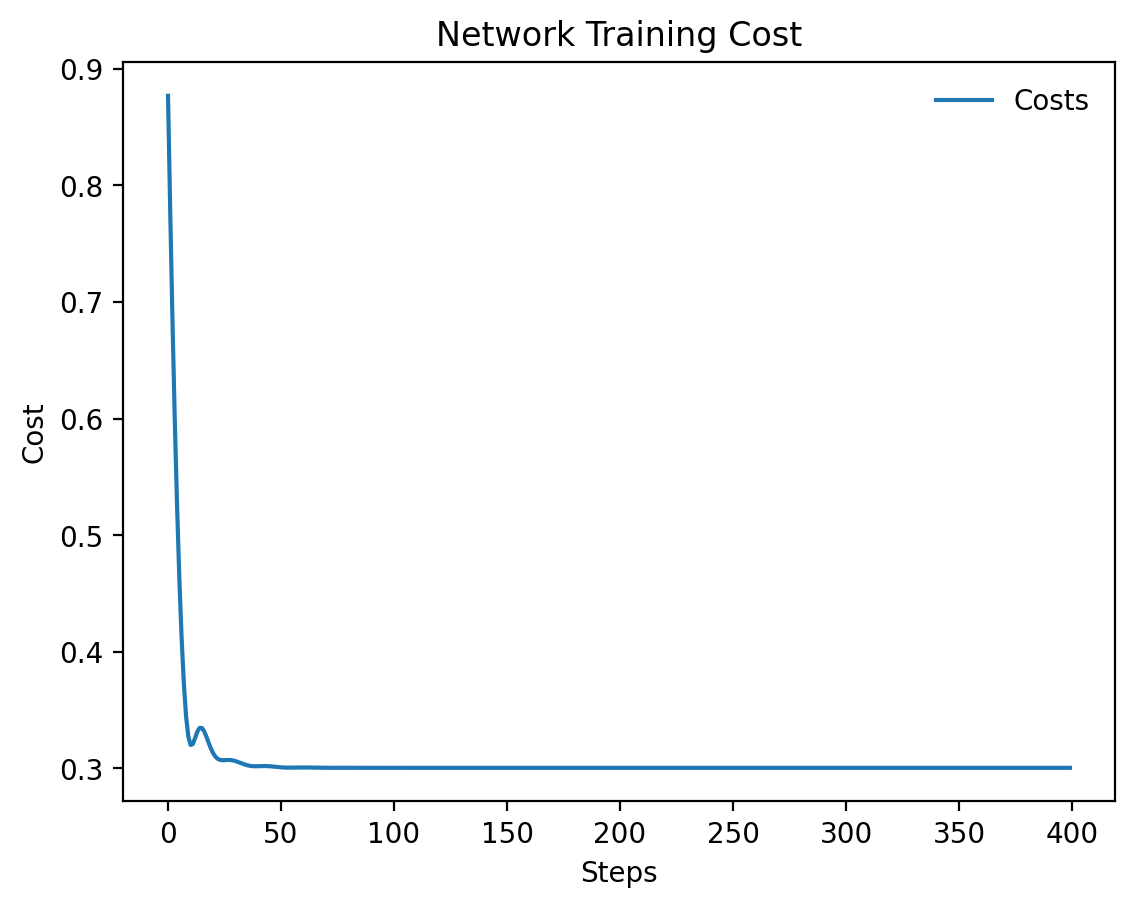

In [ ]:
# New offset to predict 100 into future
windowsize1= 30
offset1= 100
steps = 400

# Predicts future motion using function
costs4, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model2(x1, x2, y1, y2, windowsize, offset1,steps)

The cost is much higher for a higher offset value.

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 50)                10600     
                                                                 
 dense_52 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 40.07it/s]


The final cost for training data is 0.0015010782517492771
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 50)                10600     
                                                                 
 dense_53 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 40.59it/s]


The final cost for training data is 0.0019354920368641615
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 50)                10600     
                                                                 
 dense_54 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:08<00:00, 44.68it/s]


The final cost for training data is 0.0016590564046055079
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 50)                10600     
                                                                 
 dense_55 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:11<00:00, 35.04it/s]


The final cost for training data is 0.0020547856111079454
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 50)                10600     
                                                                 
 dense_56 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 40.84it/s]


The final cost for training data is 0.0015008995542302728
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 50)                10600     
                                                                 
 dense_57 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:10<00:00, 39.55it/s]


The final cost for training data is 0.0015424482990056276


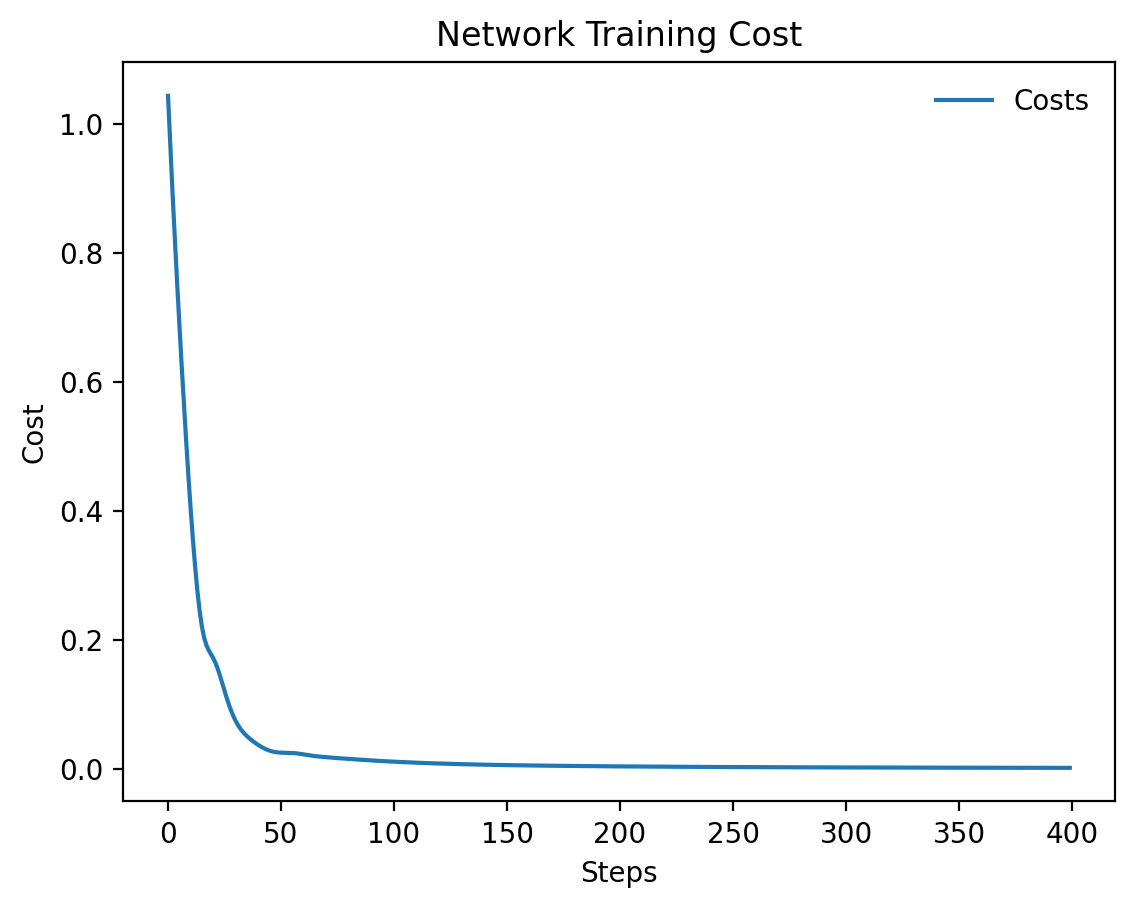

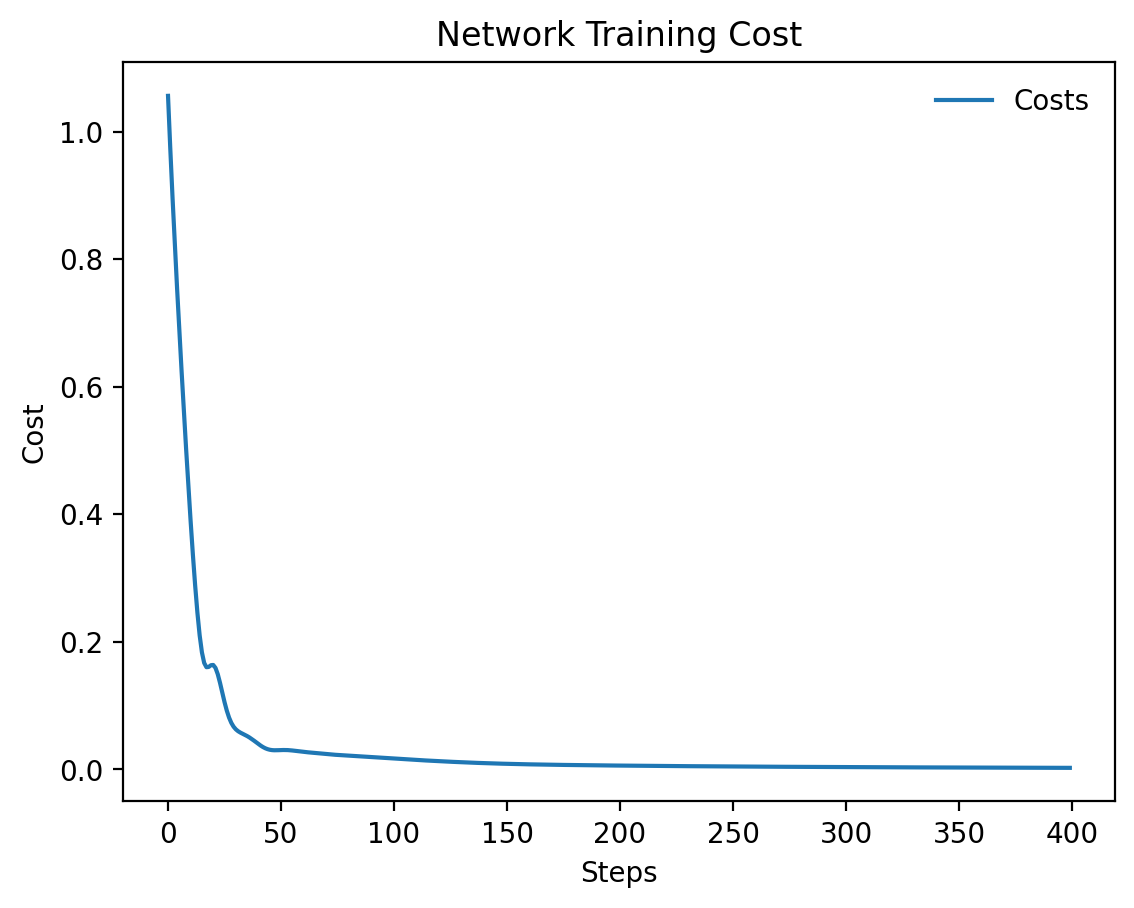

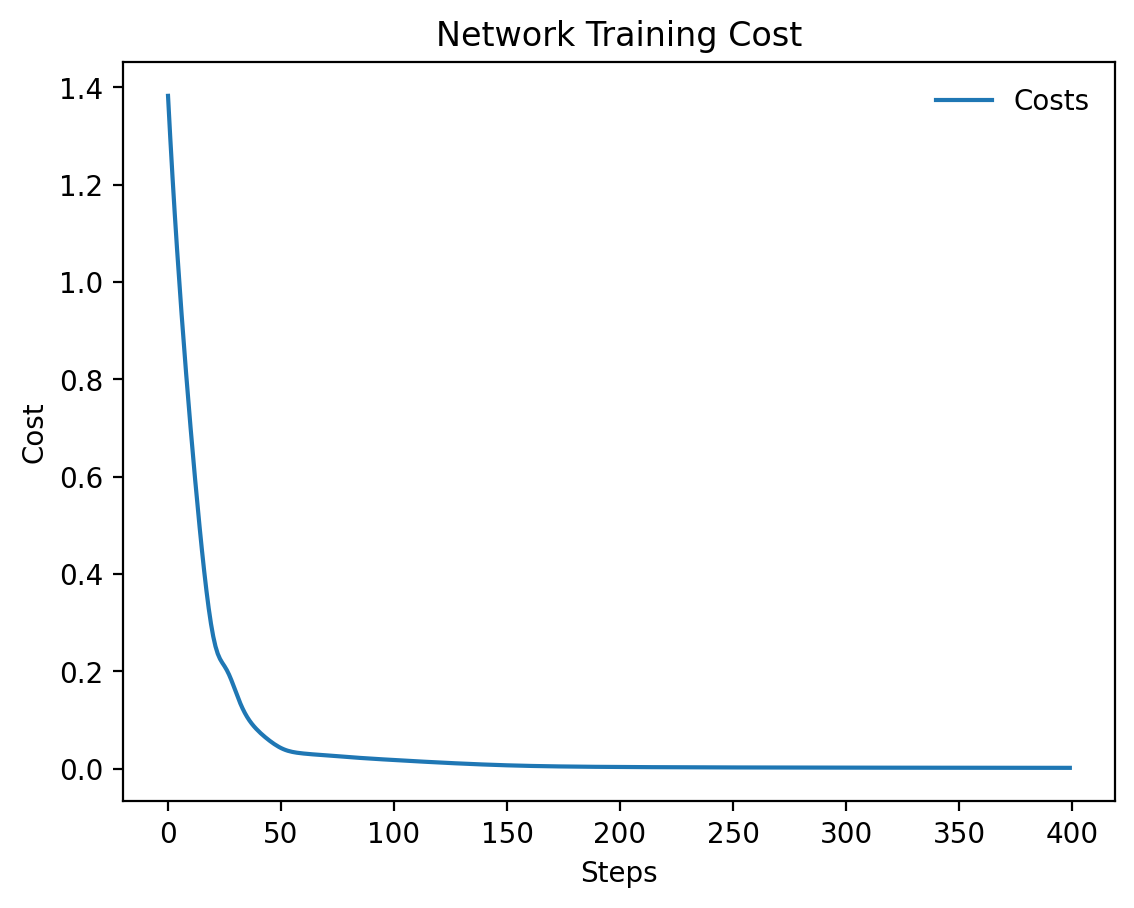

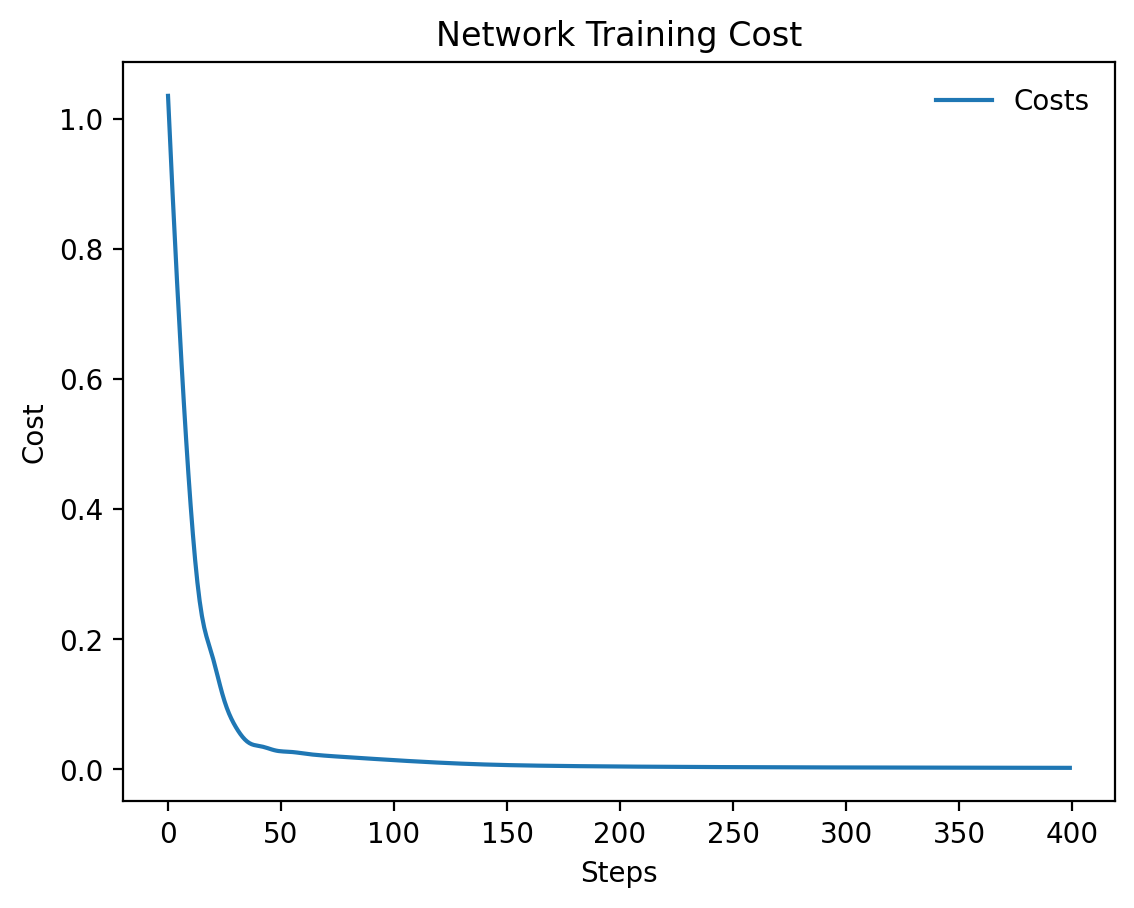

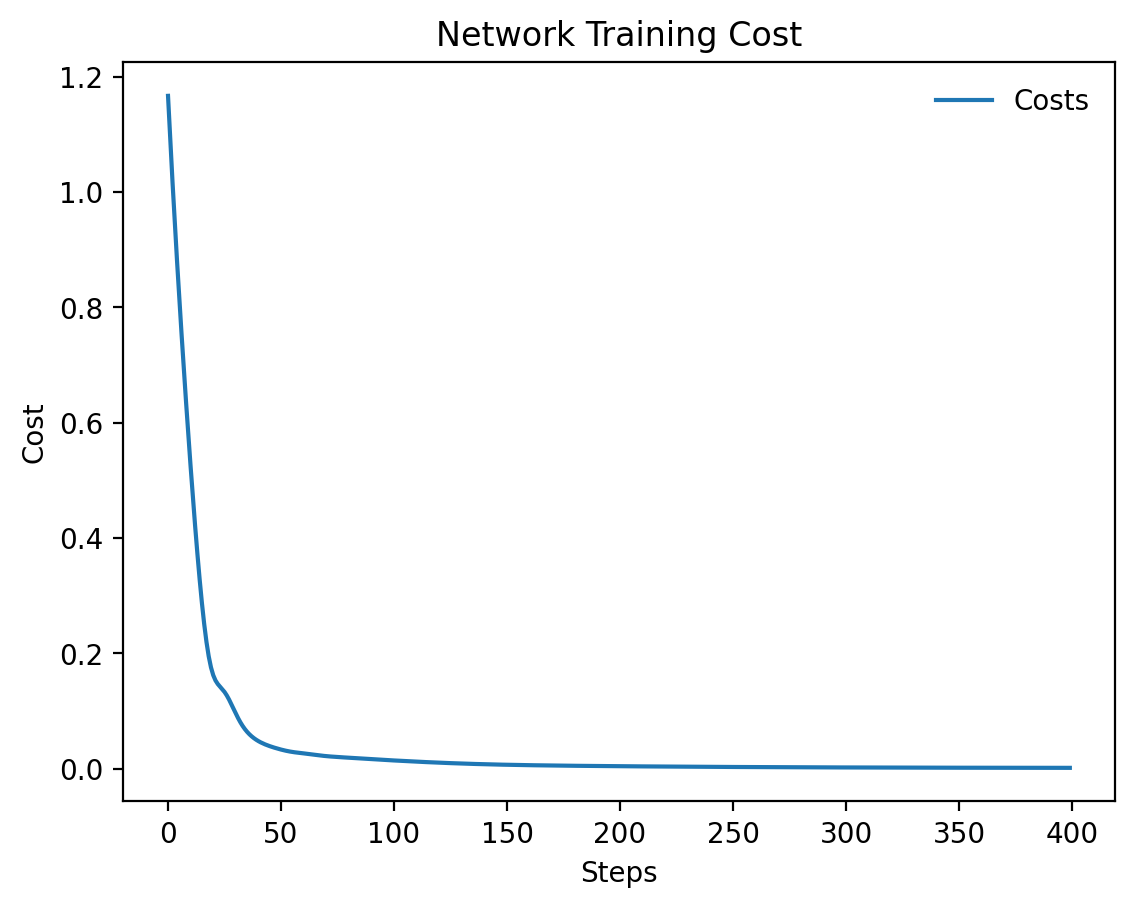

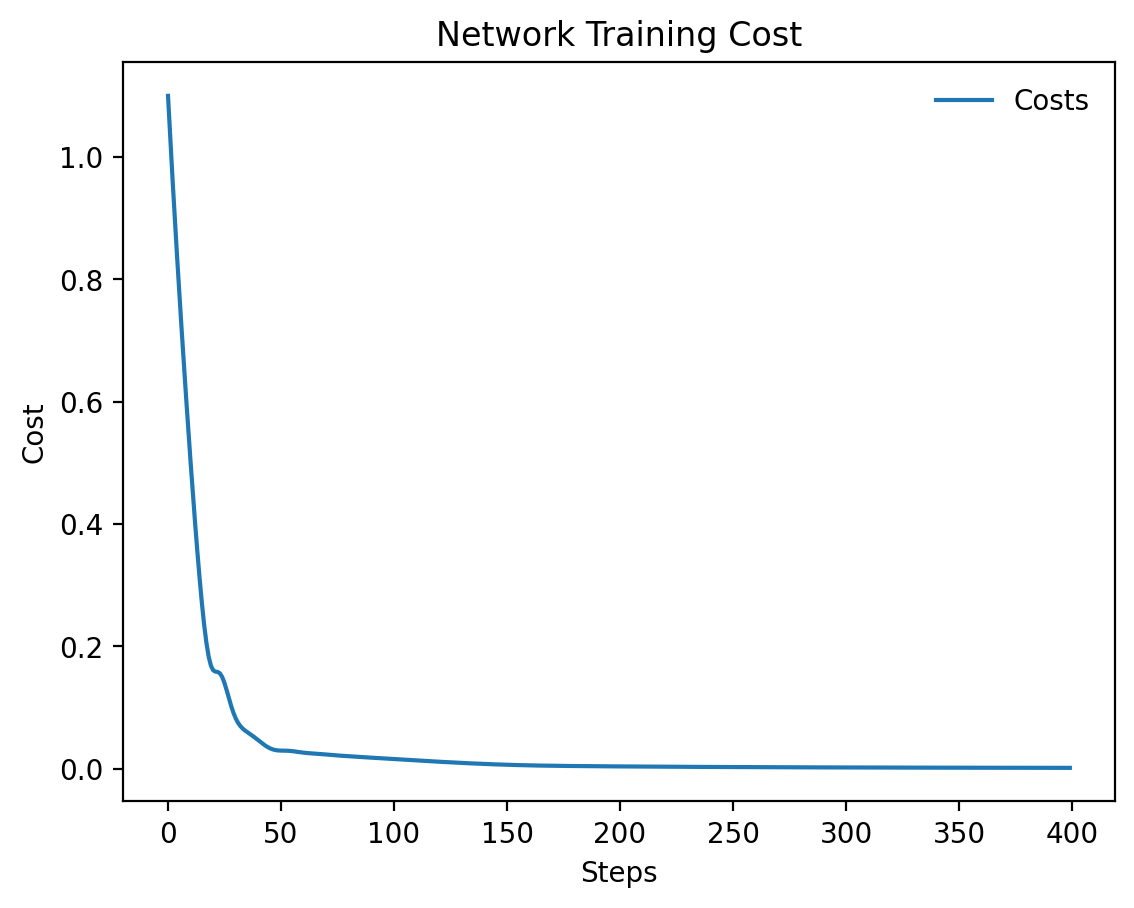

In [ ]:
# Range of offsets
offsets1 = np.linspace(20,100,6)

# Initialize arrays to store theta values and final costs
final_costs = []

for offset in offsets1:
    x1, y1, x2, y2 = stability(np.pi/4, 0)
    costs4, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model2(x1, x2, y1, y2, windowsize, offset1,steps)
    final_costs.append(costs4[-1])

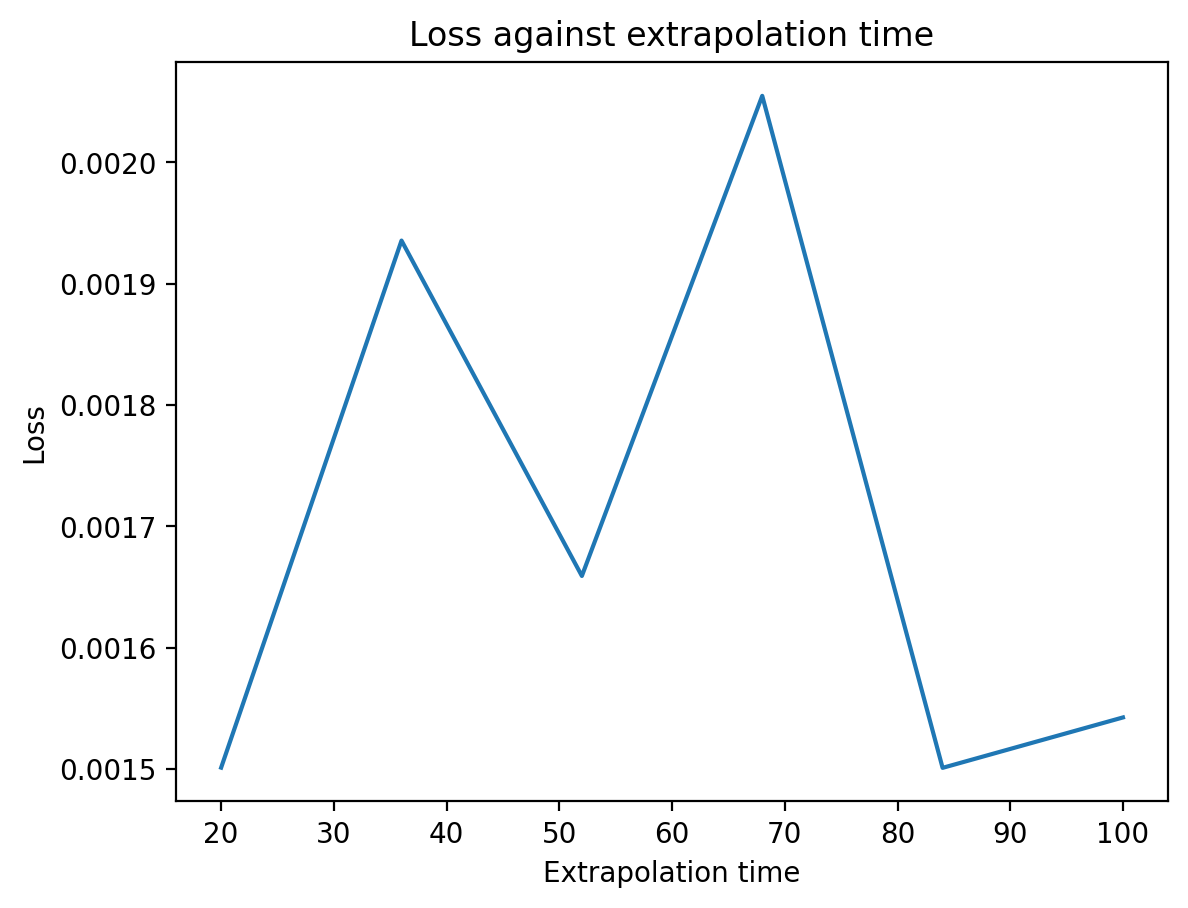

In [ ]:
plt.plot(offsets1, final_costs)
plt.xlabel("Extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

## **For** pi/2 :

In [ ]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1,y1,x2,y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 50)                10600     
                                                                 
 dense_58 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 41.21it/s]


The final cost for training data is 0.0015099489828571677


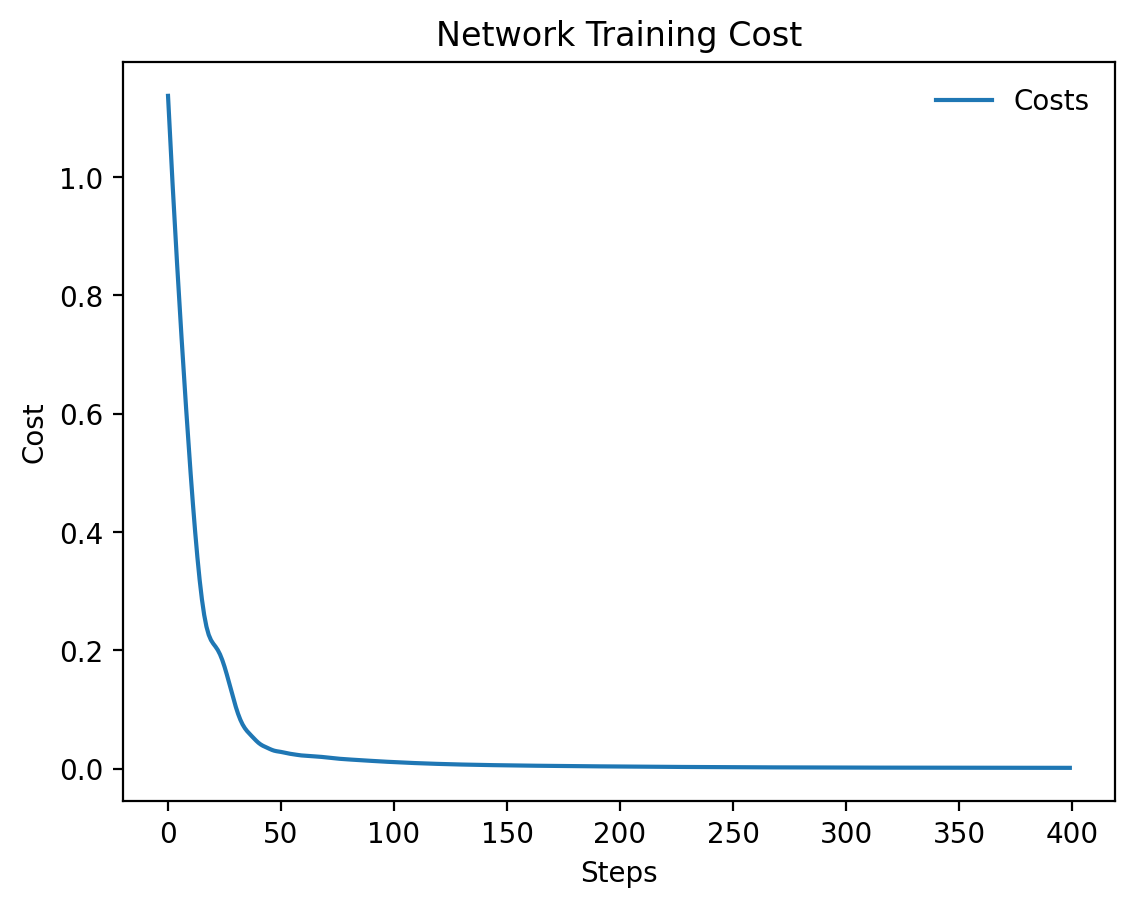

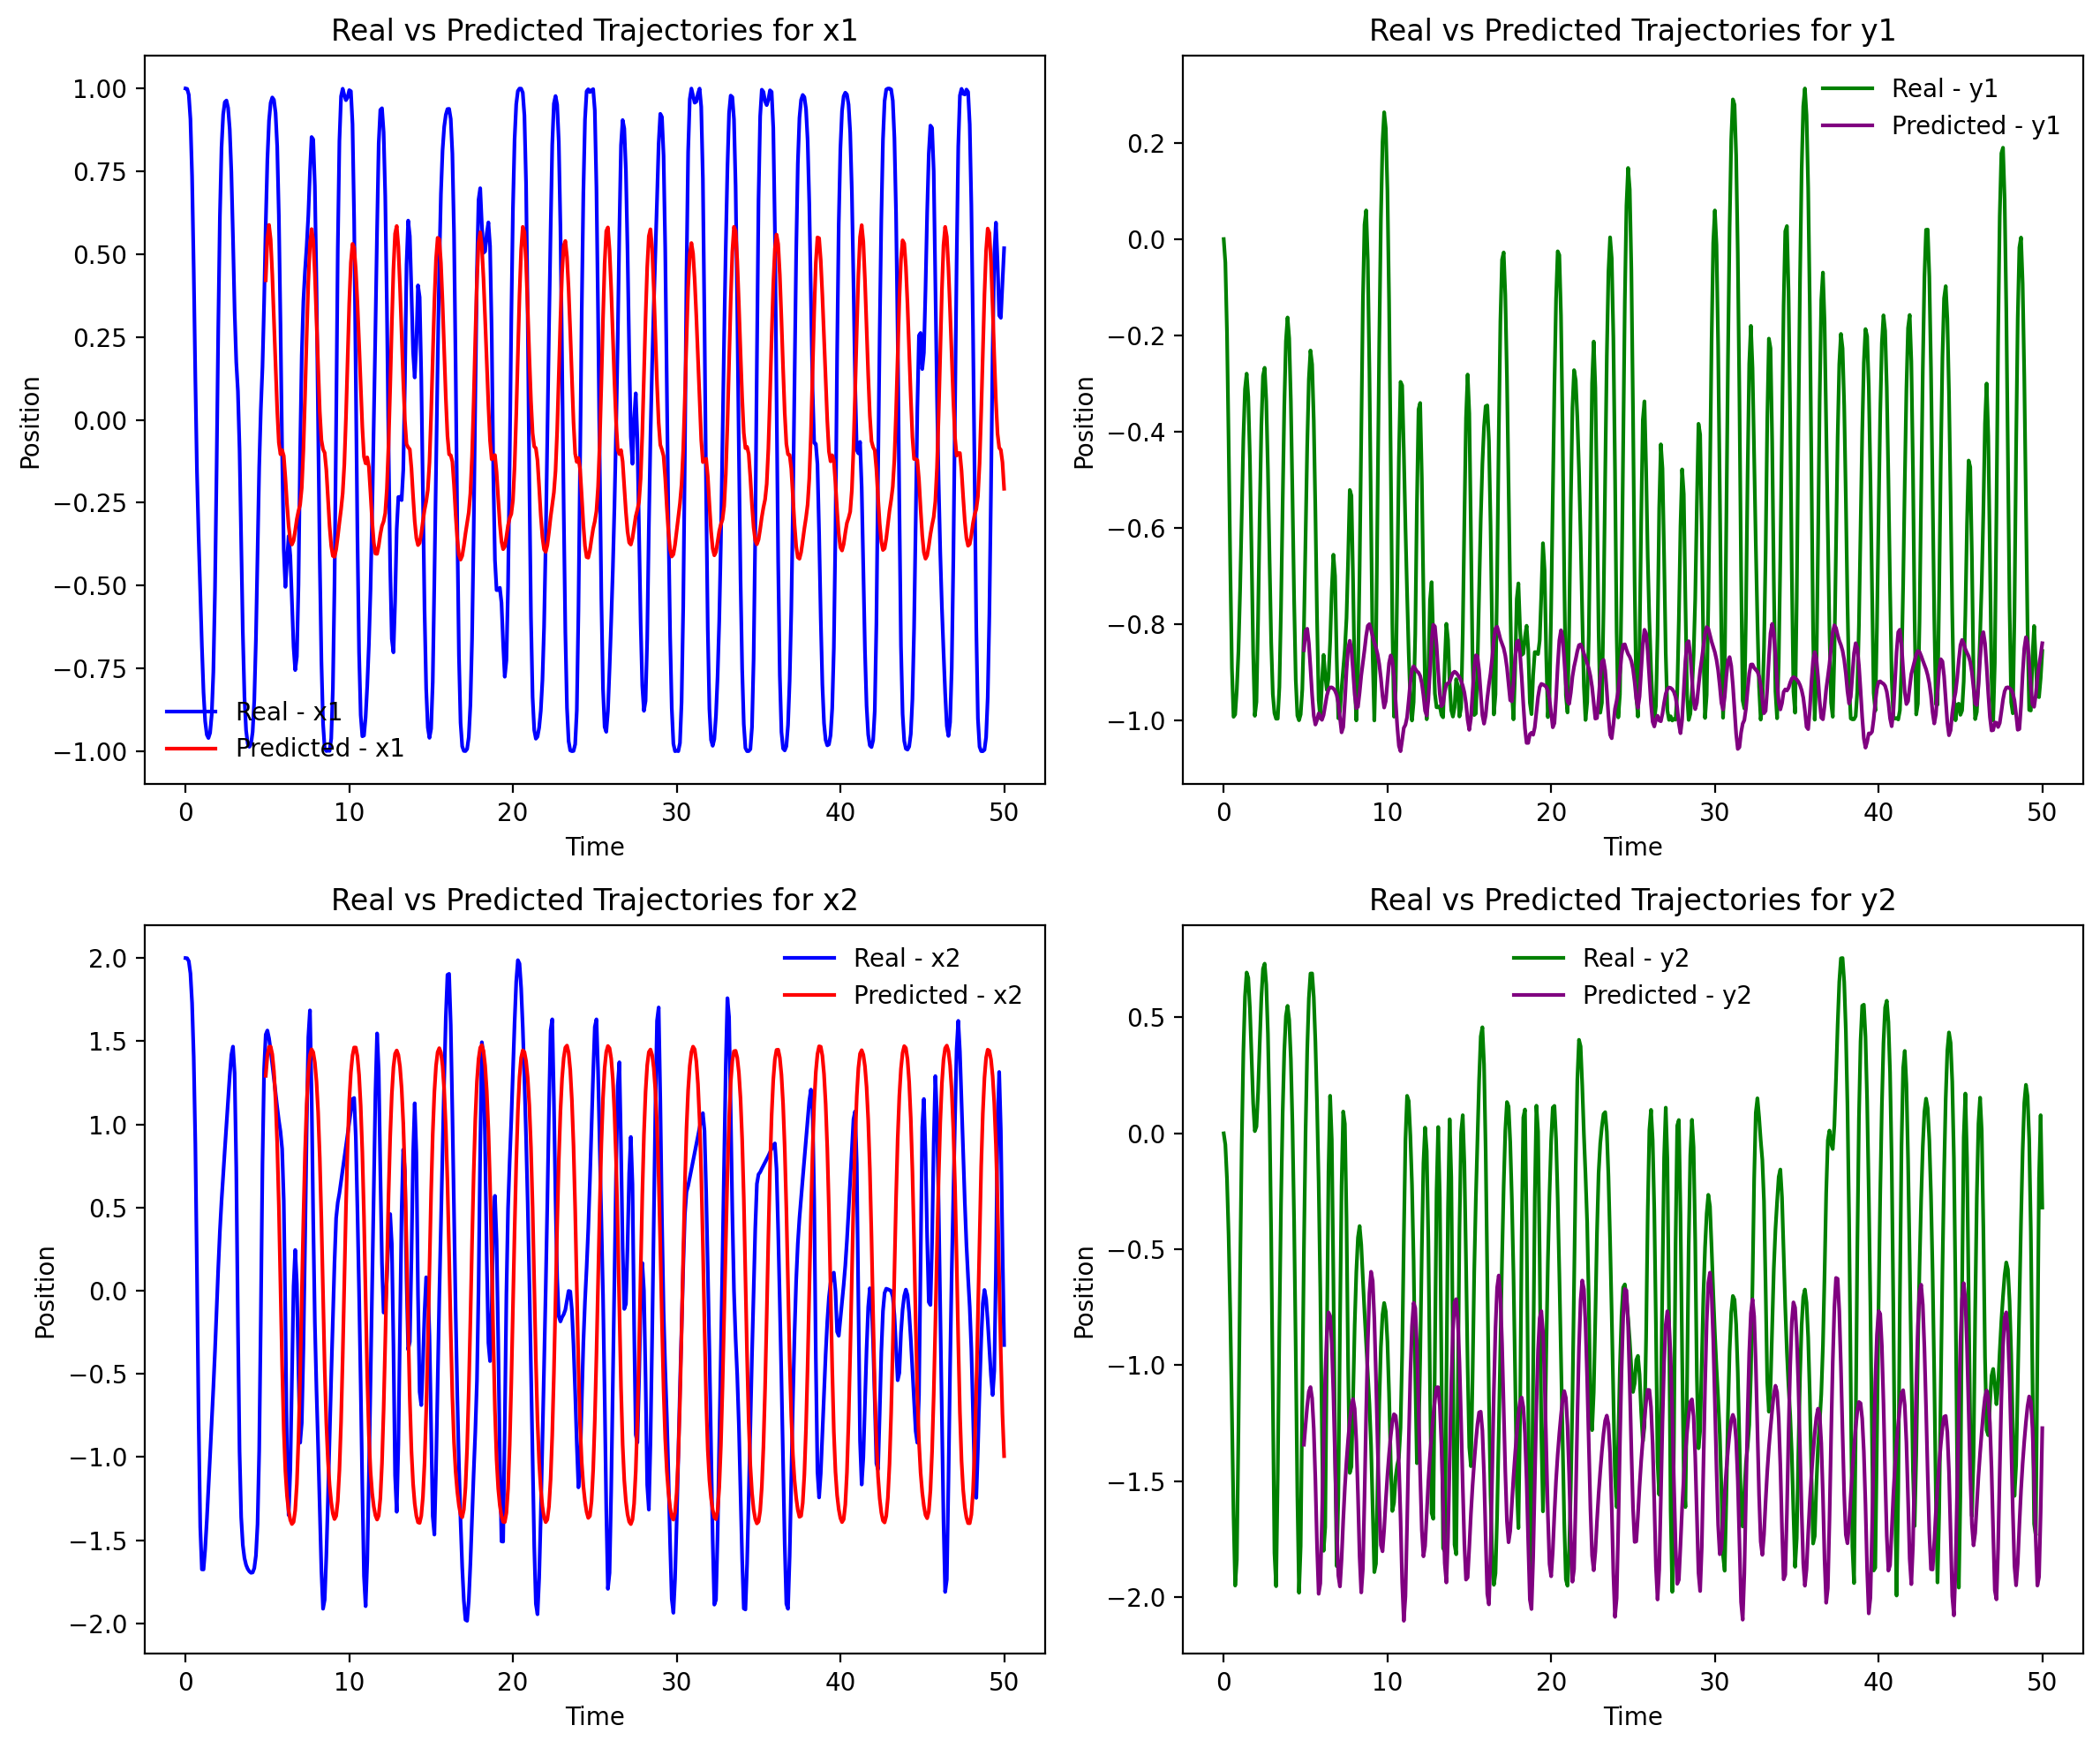

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 50)                10600     
                                                                 
 dense_59 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:04<00:00, 22.71it/s]


The final cost for training data is 1.0414513781142887e-05
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 50)                10600     
                                                                 
 dense_60 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


The final cost for training data is 0.0034925355575978756
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 50)                10600     
                                                                 
 dense_61 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:04<00:00, 22.86it/s]


The final cost for training data is 0.011007522232830524
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 50)                10600     
                                                                 
 dense_62 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


The final cost for training data is 0.016233619302511215
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 50)                10600     
                                                                 
 dense_63 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


The final cost for training data is 0.07977379858493805
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 50)                10600     
                                                                 
 dense_64 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:04<00:00, 21.78it/s]


The final cost for training data is 0.05630119889974594
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 50)                10600     
                                                                 
 dense_65 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


The final cost for training data is 0.004656508564949036
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 50)                10600     
                                                                 
 dense_66 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:04<00:00, 24.09it/s]


The final cost for training data is 0.013029994443058968
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 50)                10600     
                                                                 
 dense_67 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:05<00:00, 18.52it/s]


The final cost for training data is 0.09513154625892639
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 50)                10600     
                                                                 
 dense_68 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


The final cost for training data is 8.796912993602746e-07


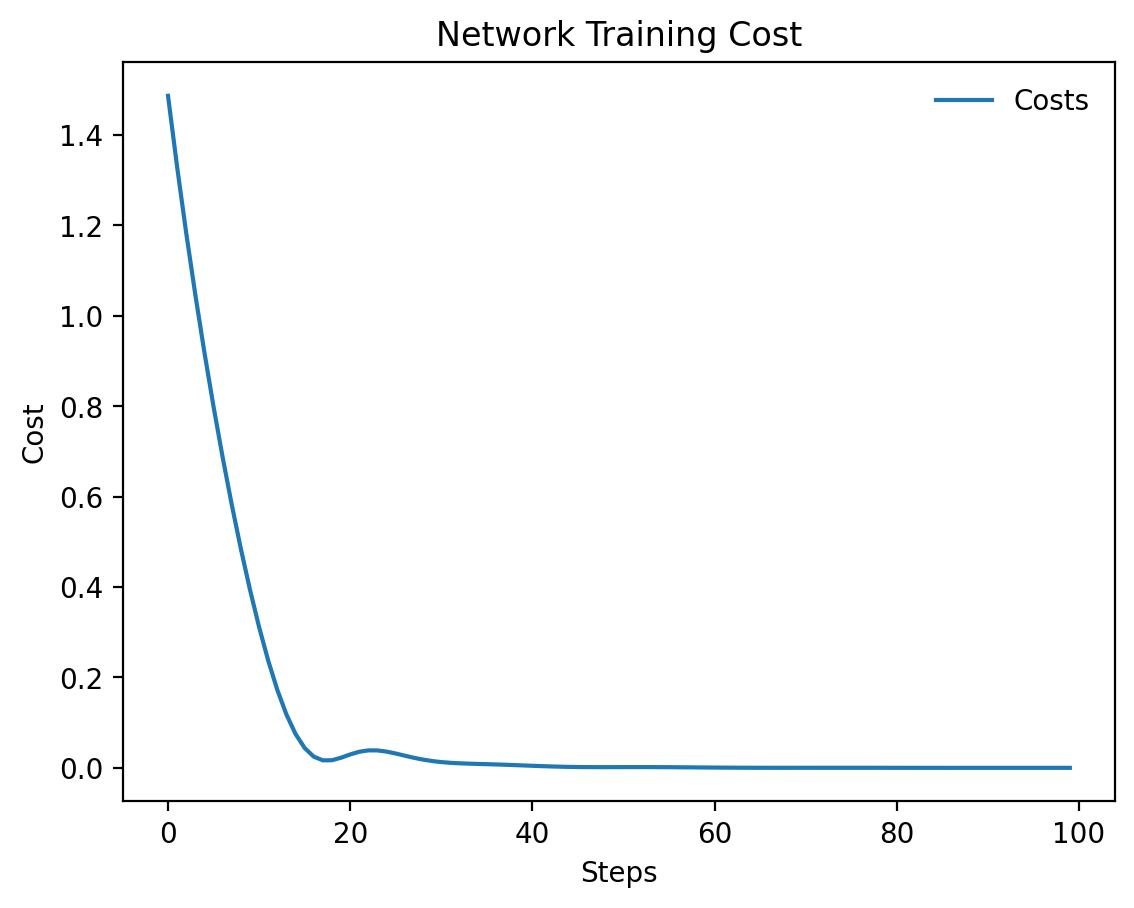

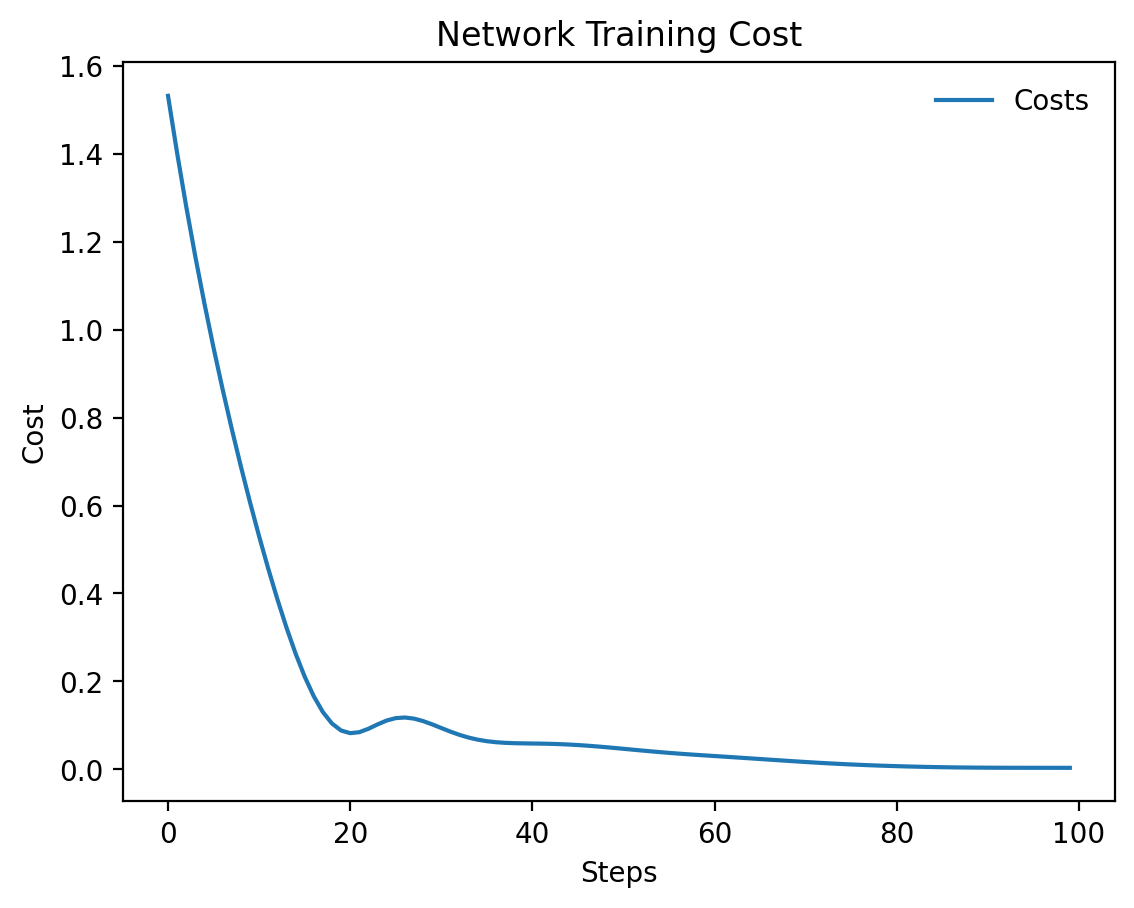

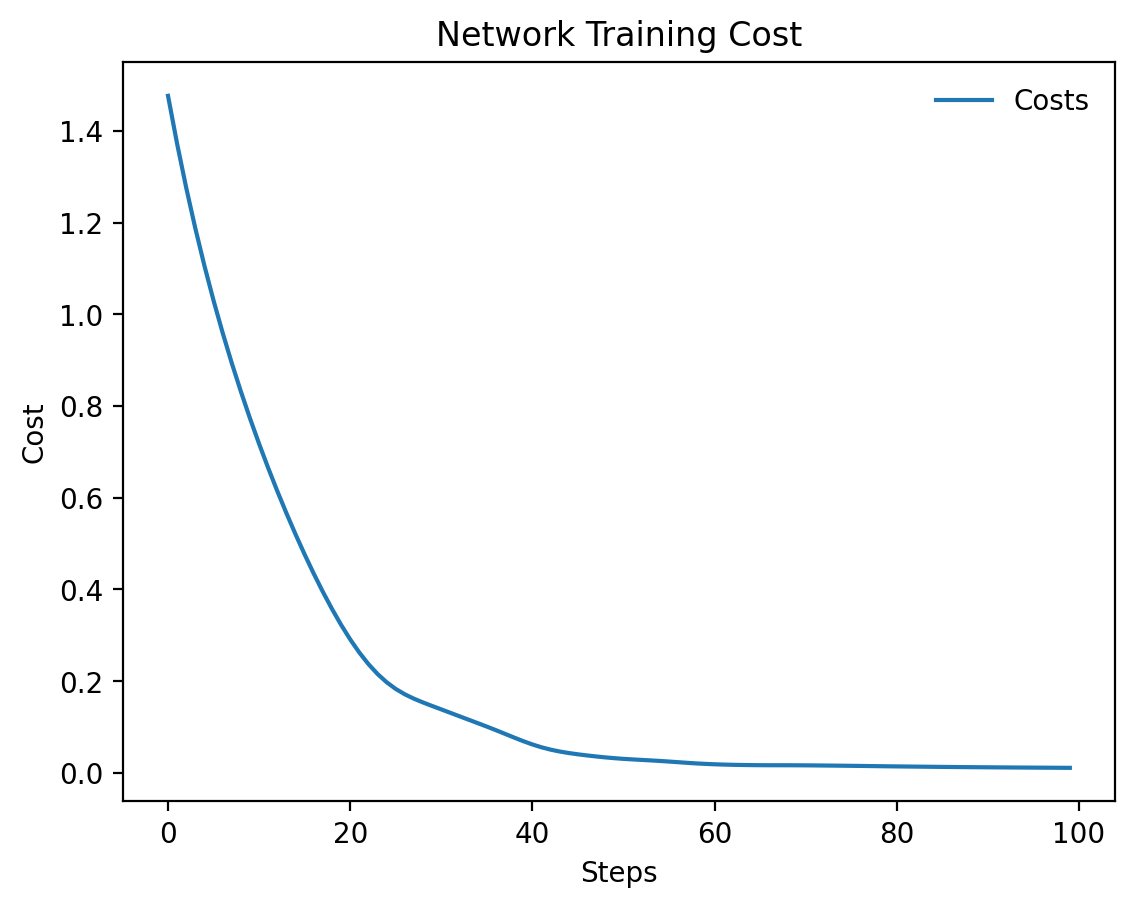

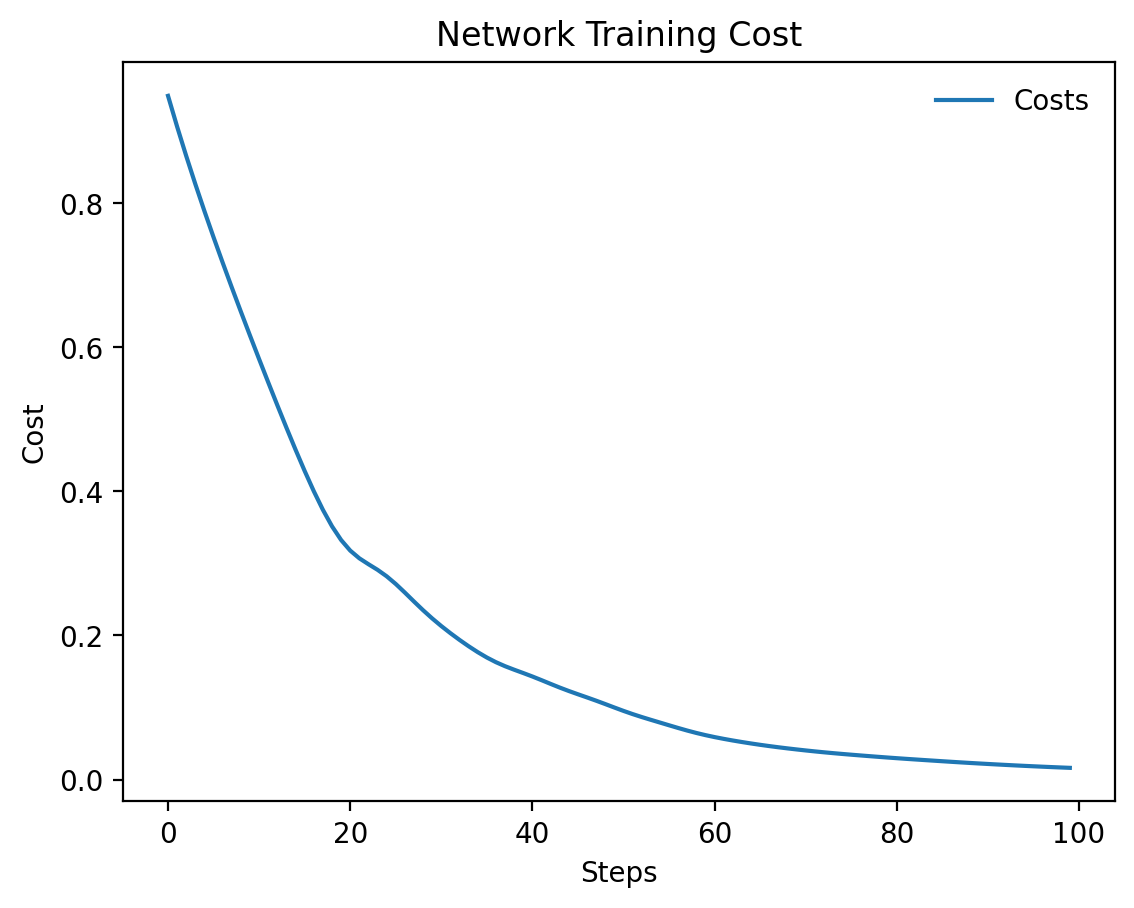

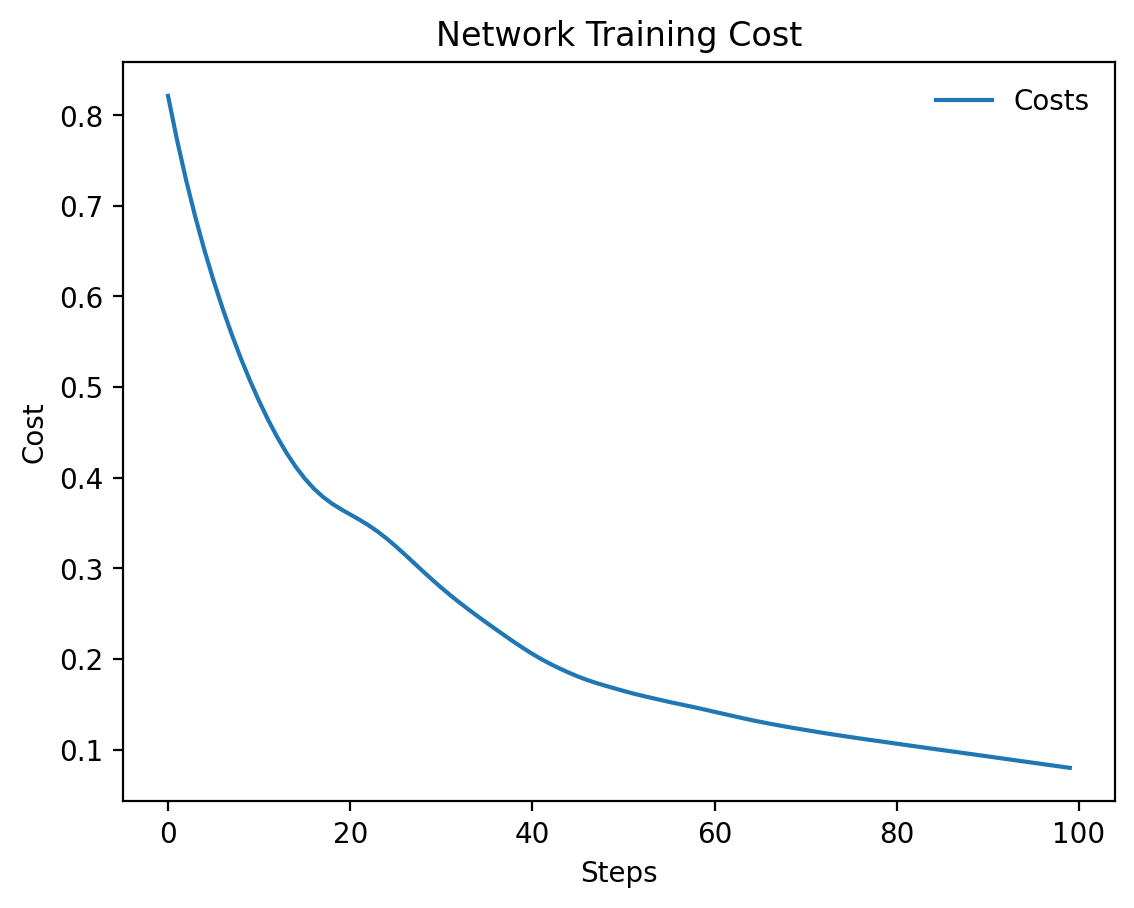

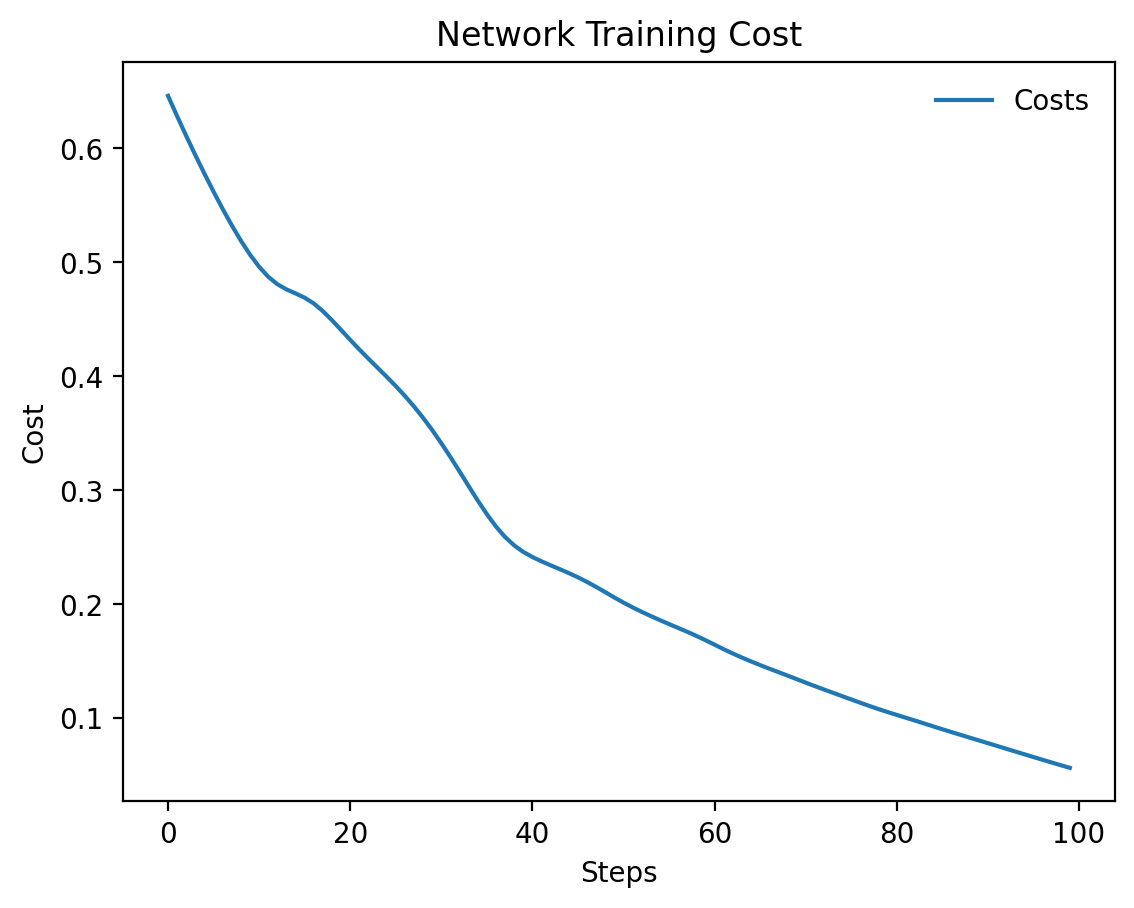

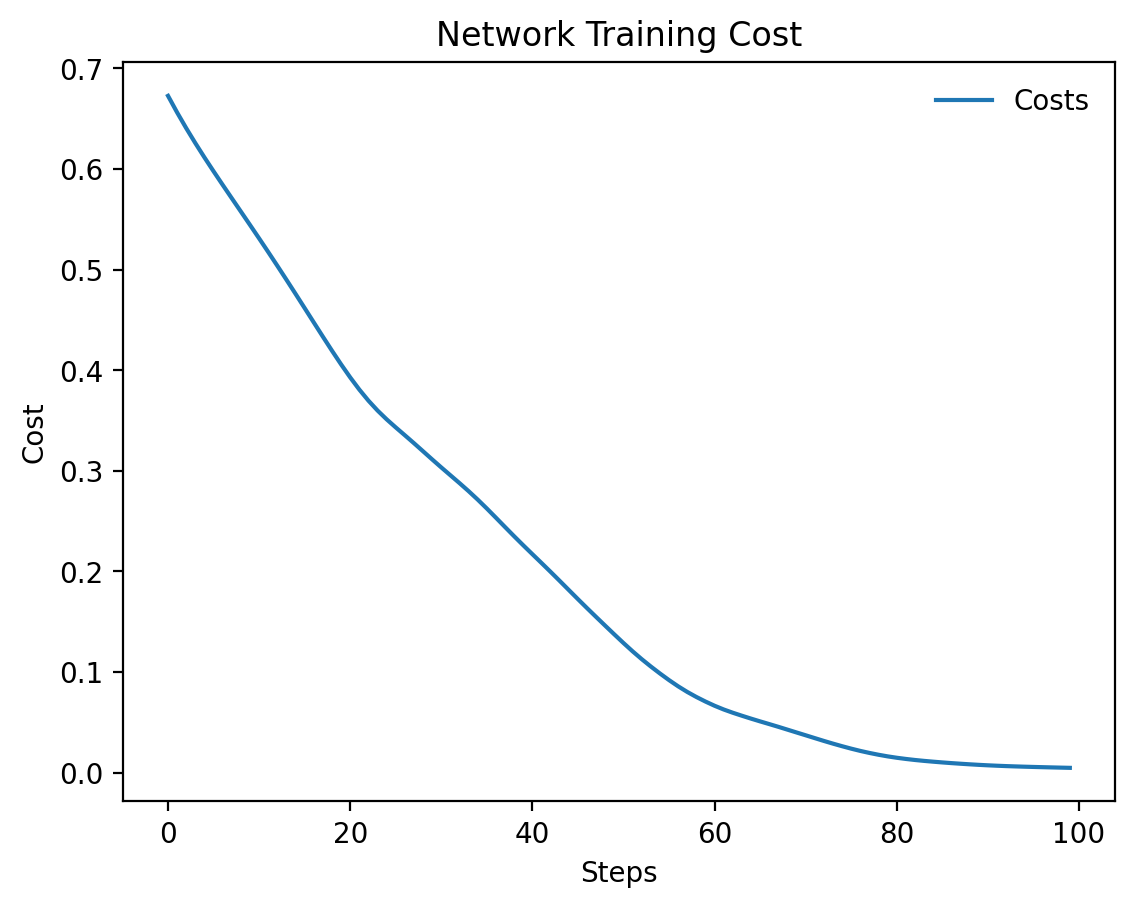

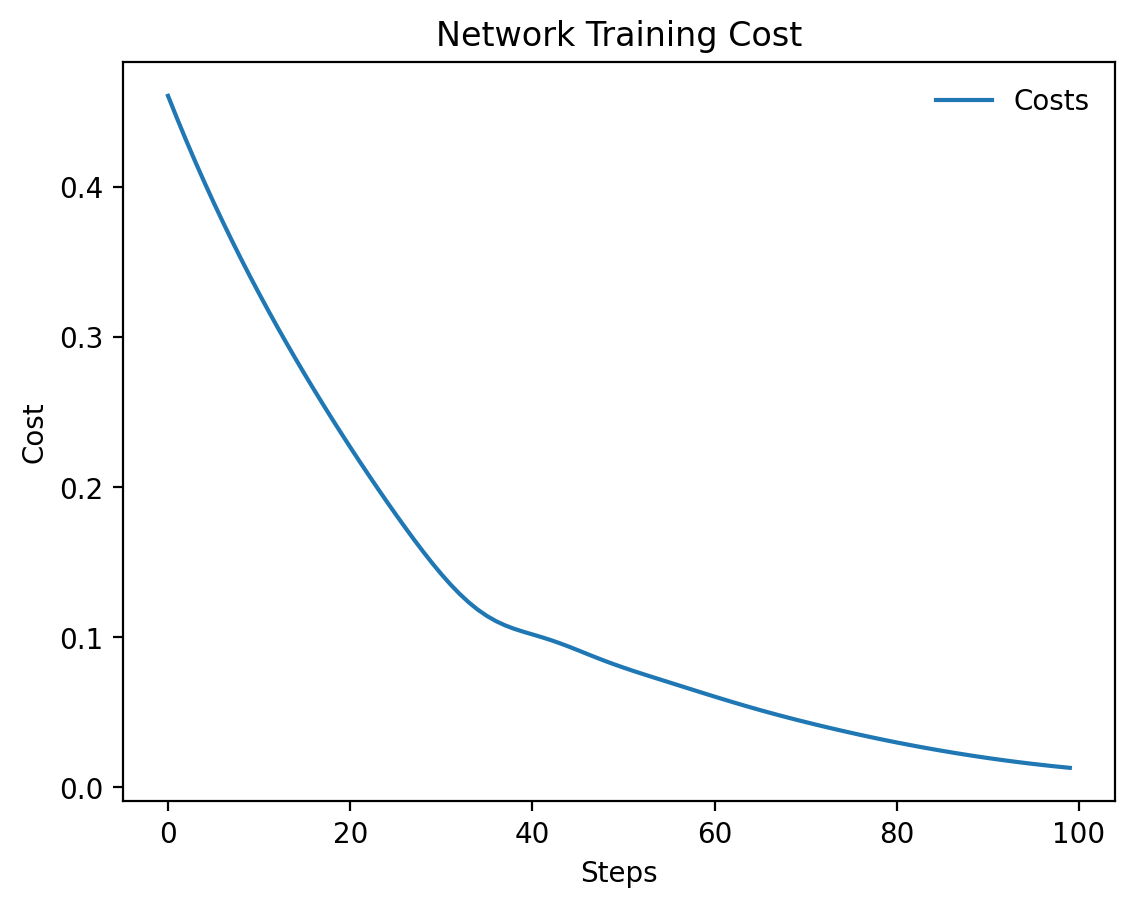

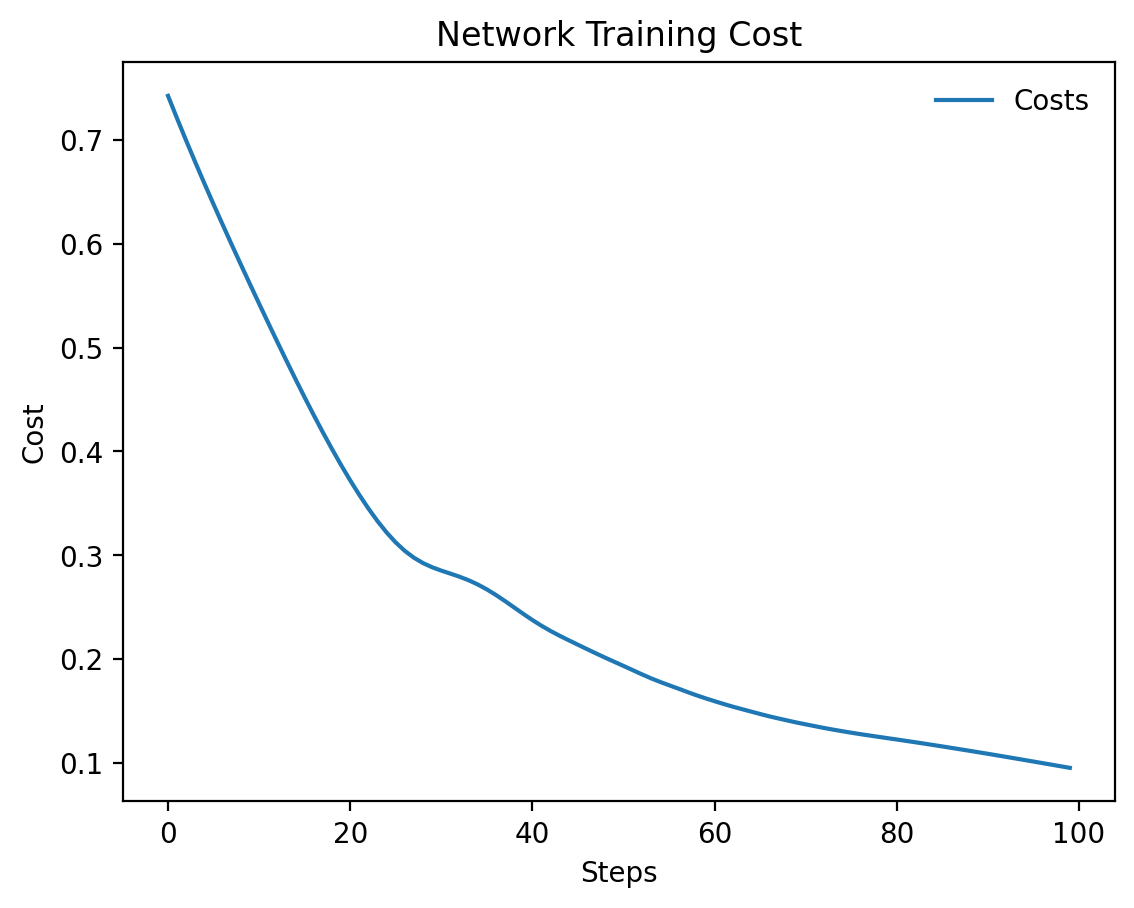

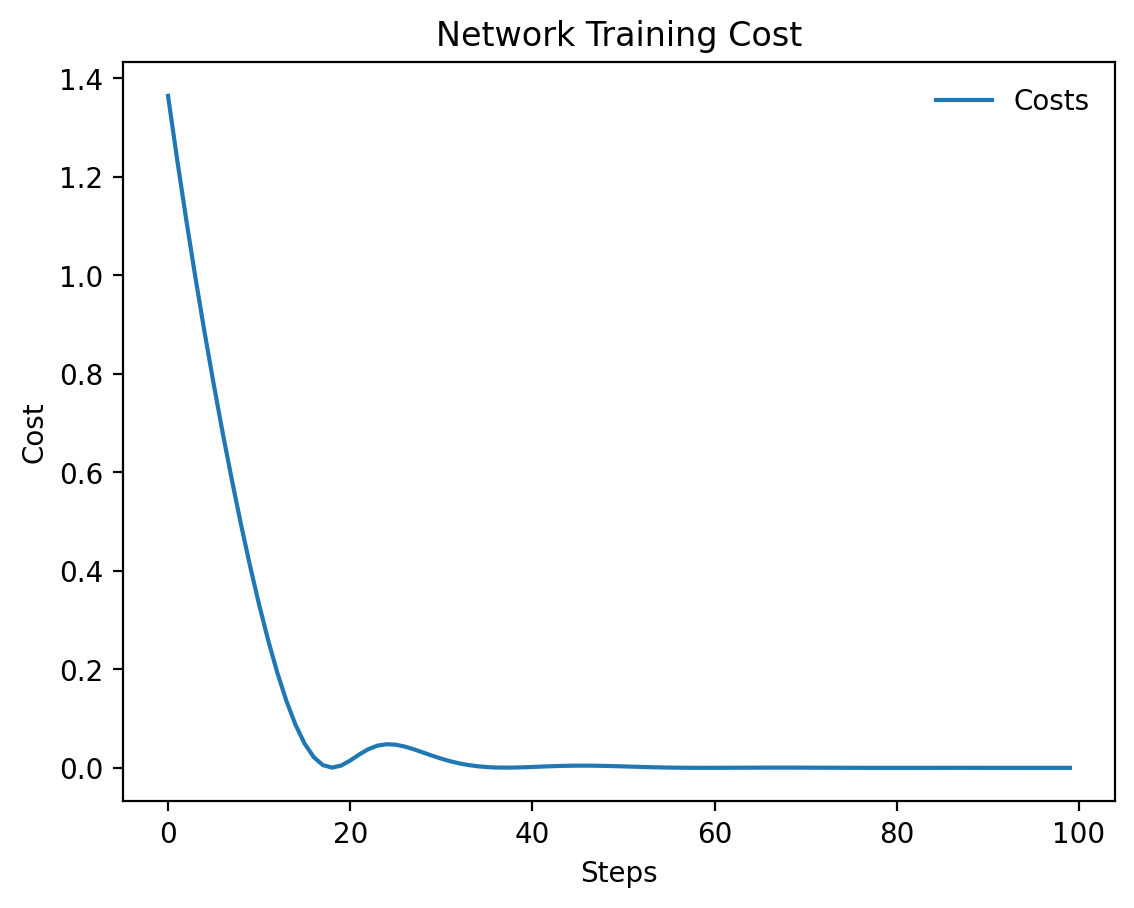

In [ ]:
costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model2(x1, x2, y1, y2, 30, 20, 400)

# Number of samples we will use to train our network
windowsize= 30

# How many samples into the future to predict
offset= 20

x1,y1,x2,y2 = stability(np.pi/2,0)
timePlot(x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat,windowsize,offset)

# Set your windowsize and offset values
windowsize = 30
offset = 20
steps = 100

# Initialize arrays to store theta values and final costs
theta_values = np.linspace(0.001, np.pi, 10)
final_costs = []

for theta in theta_values:
    x1, y1, x2, y2 = stability(theta, 0)
    costs, (x1_hat, y1_hat, x2_hat, y2_hat) = build_model2(x1, x2, y1, y2, windowsize, offset,steps)
    final_costs.append(costs[-1])


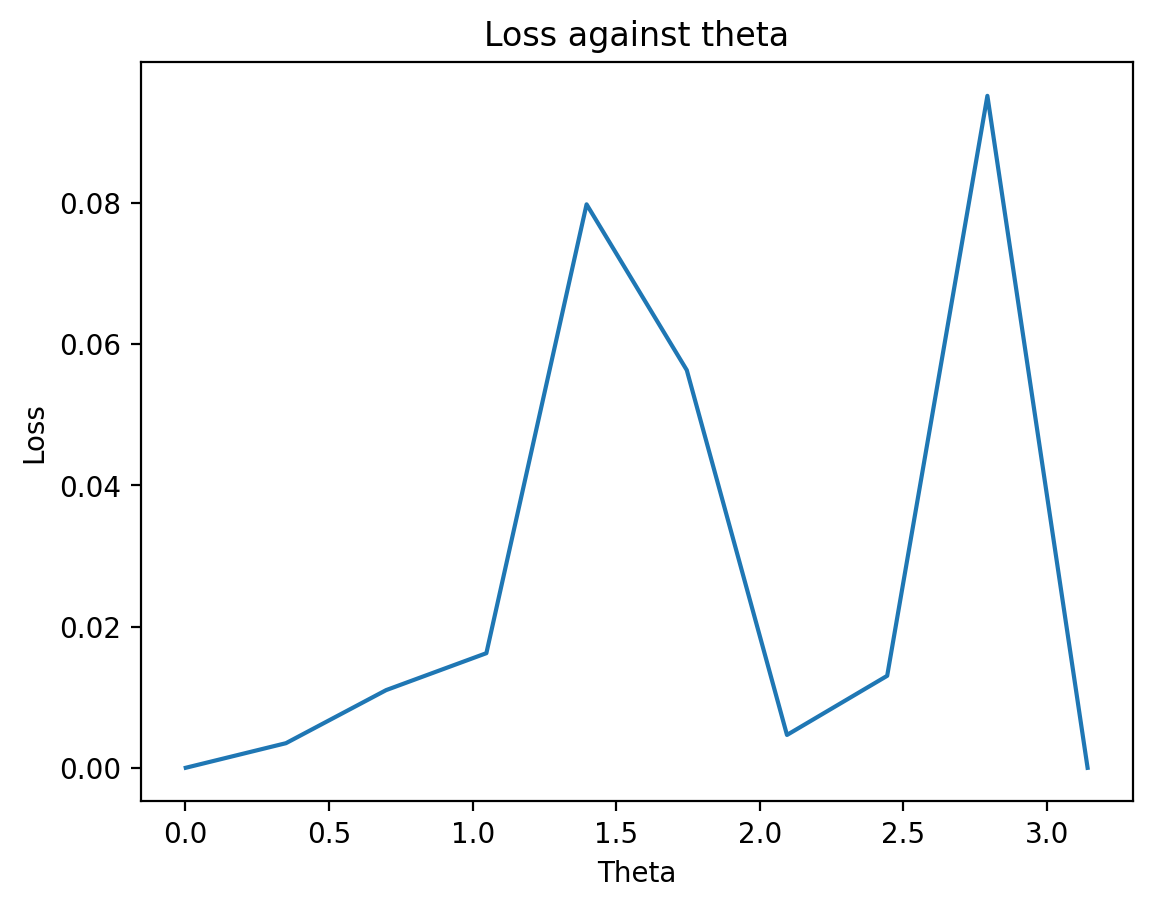

In [ ]:
plt.plot(theta_values, final_costs)
plt.xlabel("Theta")
plt.ylabel("Loss")
plt.title("Loss against theta")
plt.show()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 50)                10600     
                                                                 
 dense_69 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:10<00:00, 38.99it/s]


The final cost for training data is 0.30052509903907776
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 50)                10600     
                                                                 
 dense_70 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 43.44it/s]


The final cost for training data is 0.00021532588289119303
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 50)                10600     
                                                                 
 dense_71 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 42.90it/s]


The final cost for training data is 0.00016852951375767589
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 50)                10600     
                                                                 
 dense_72 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 40.86it/s]


The final cost for training data is 0.00011405611439840868
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 50)                10600     
                                                                 
 dense_73 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 40.72it/s]


The final cost for training data is 9.526987560093403e-05
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 50)                10600     
                                                                 
 dense_74 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 41.02it/s]


The final cost for training data is 0.00012066922499798238
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 50)                10600     
                                                                 
 dense_75 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10804 (42.20 KB)
Trainable params: 10804 (42.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of xyTrain: (30, 30, 2)
Shape of xyTarget: (30, 4)


100%|██████████| 400/400 [00:09<00:00, 41.18it/s]


The final cost for training data is 0.0004959048819728196


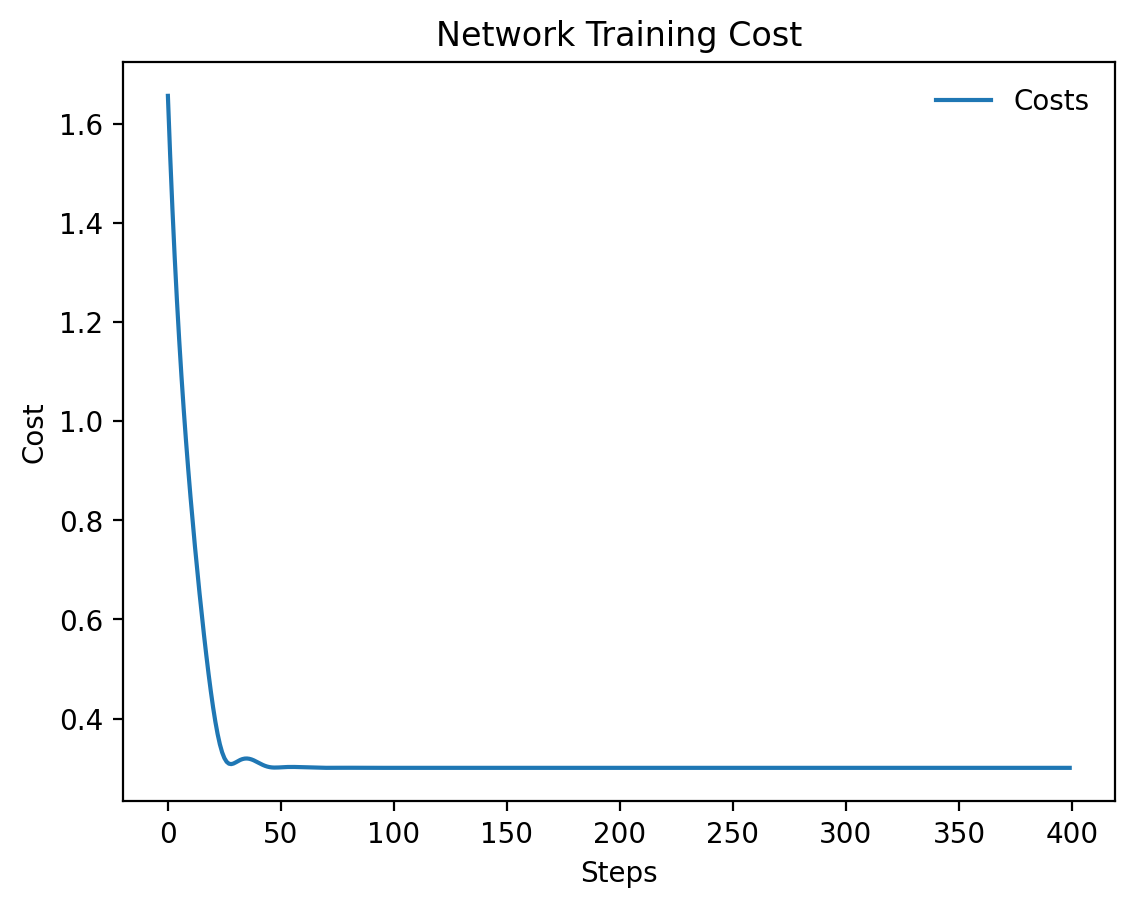

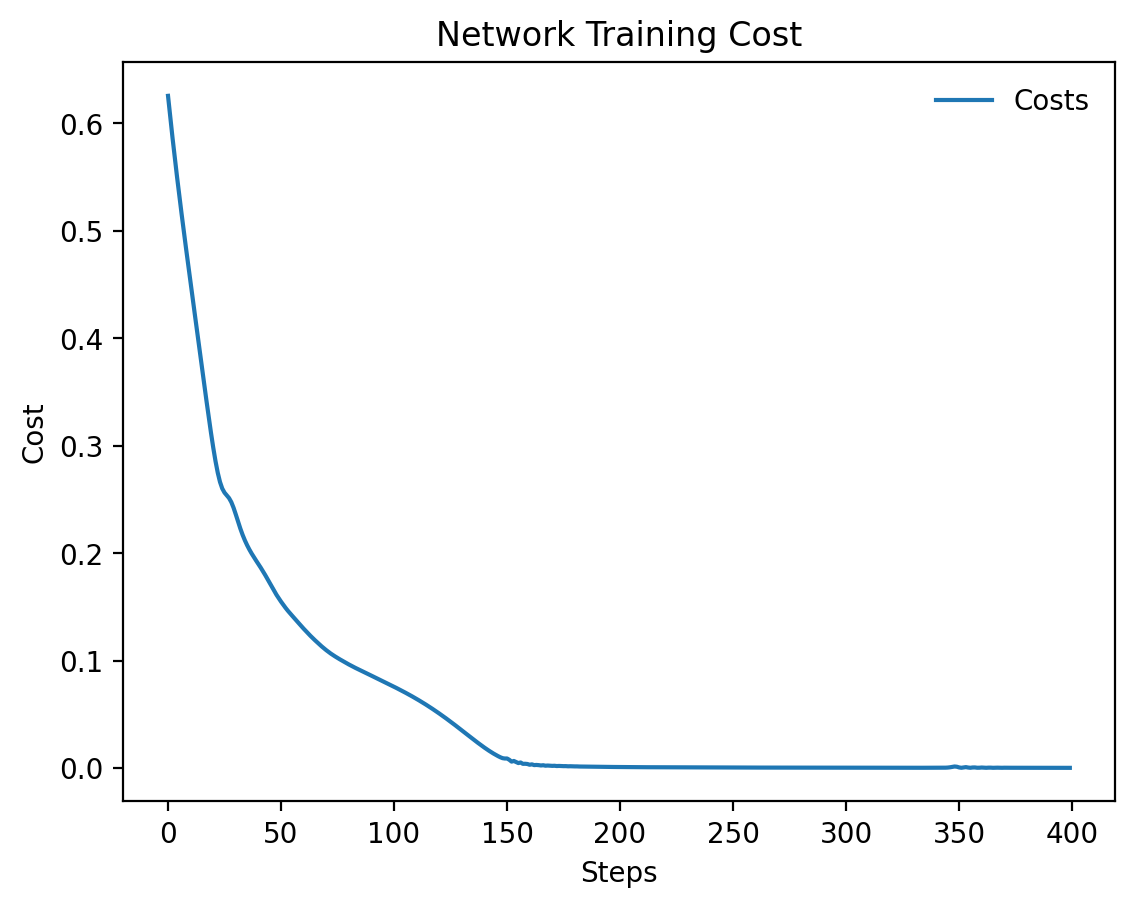

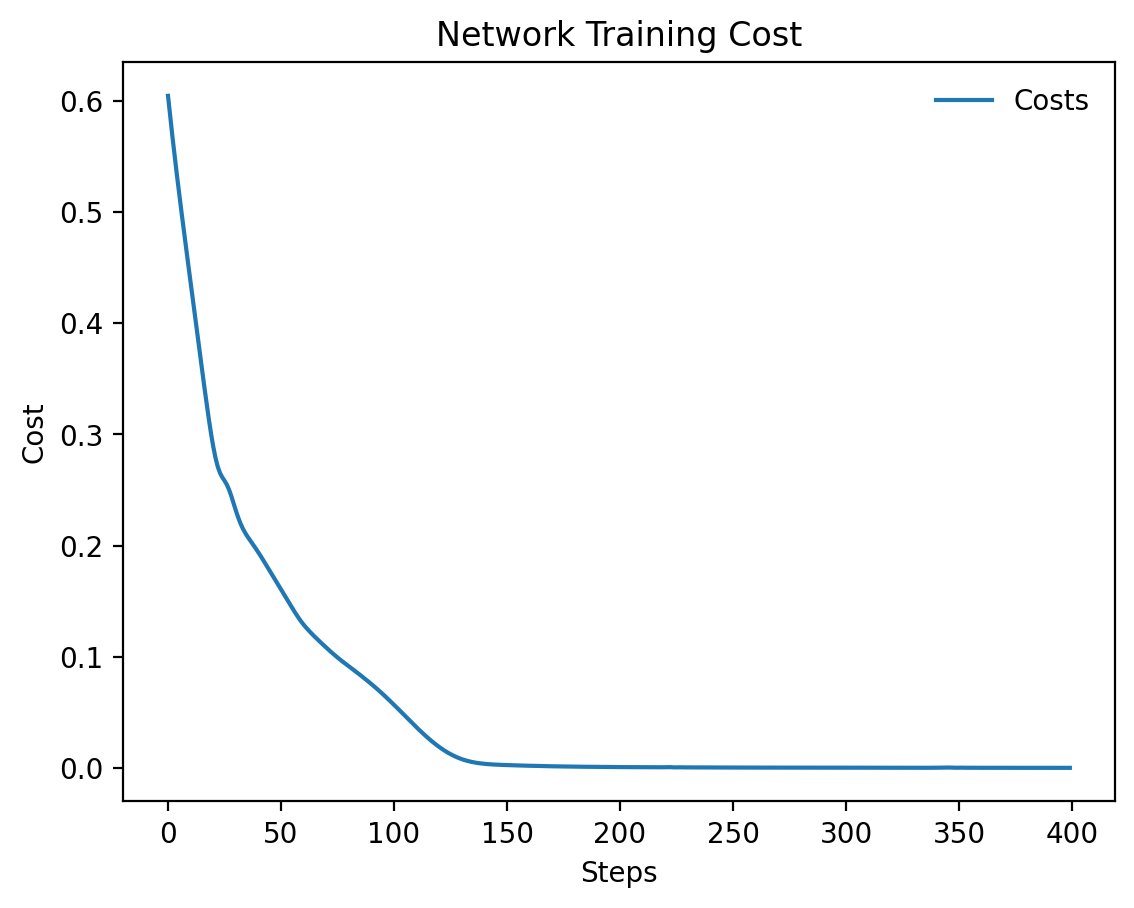

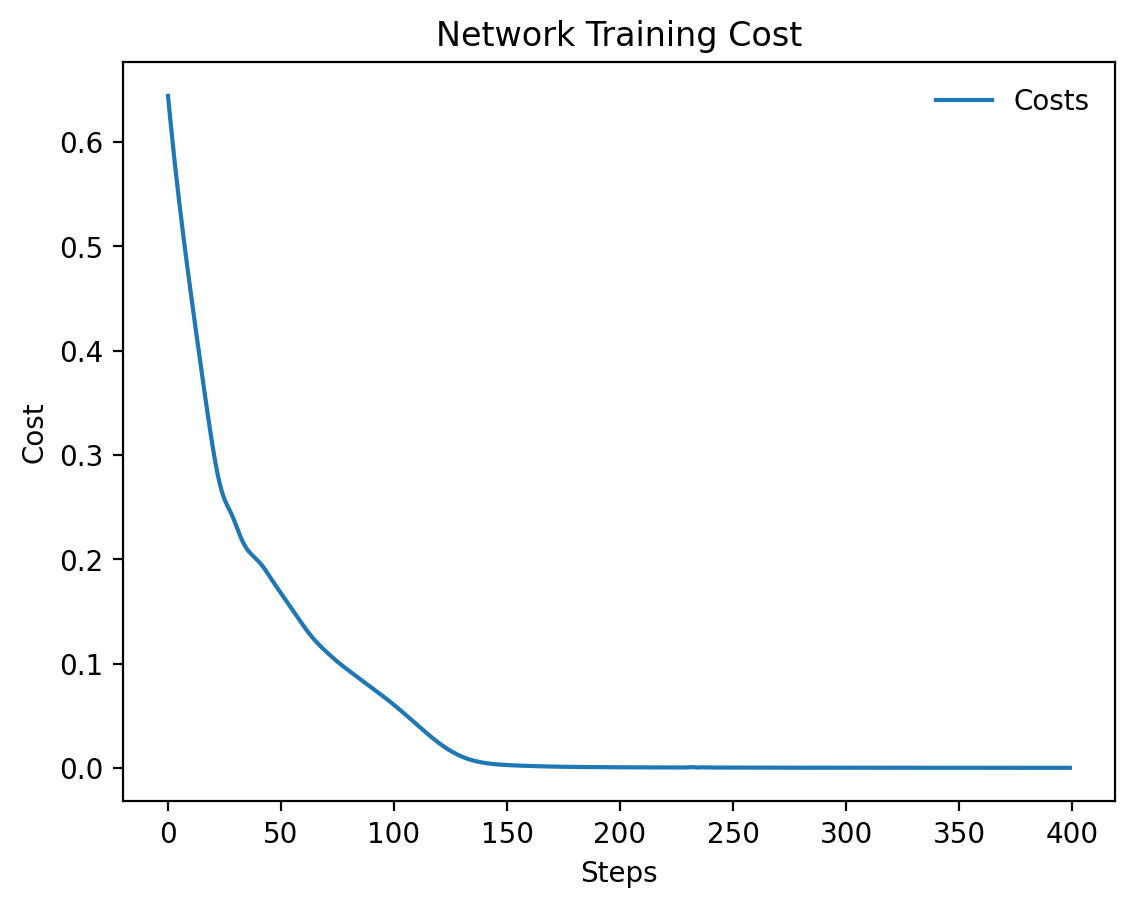

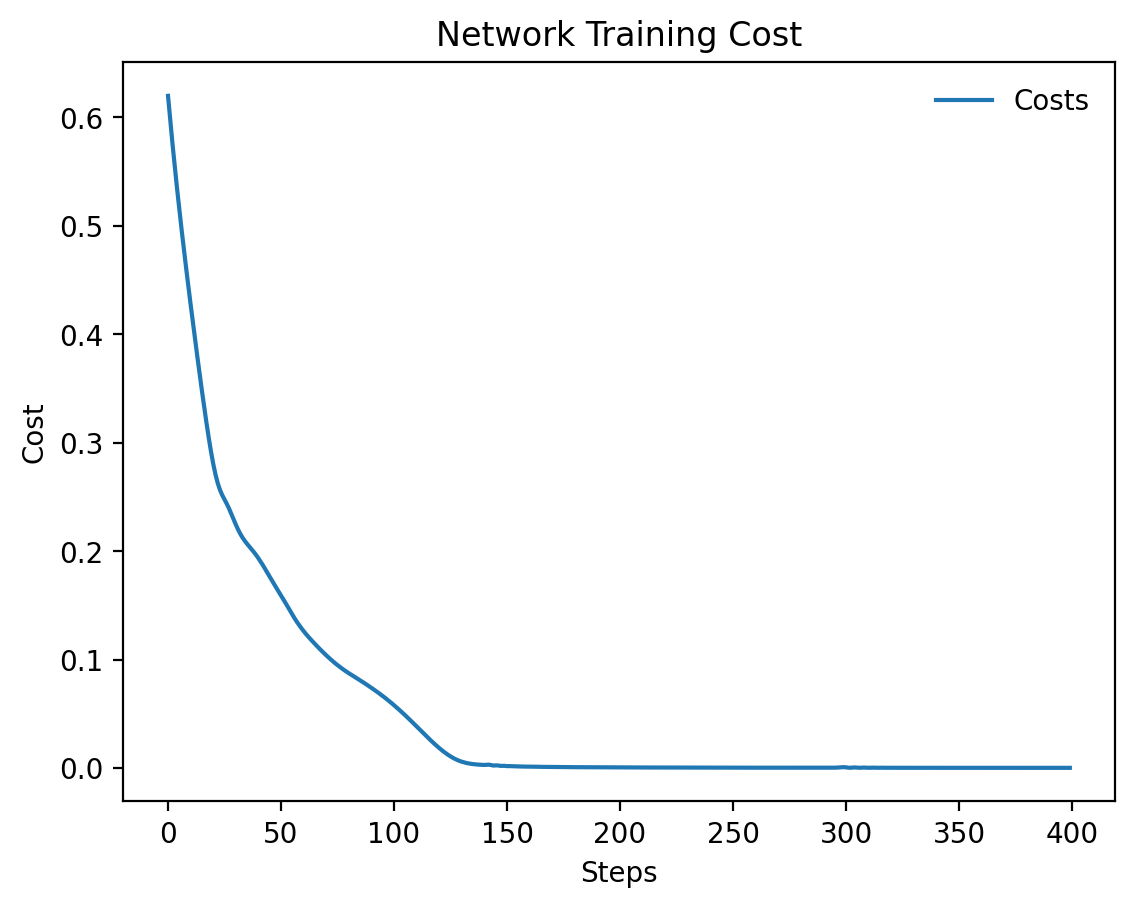

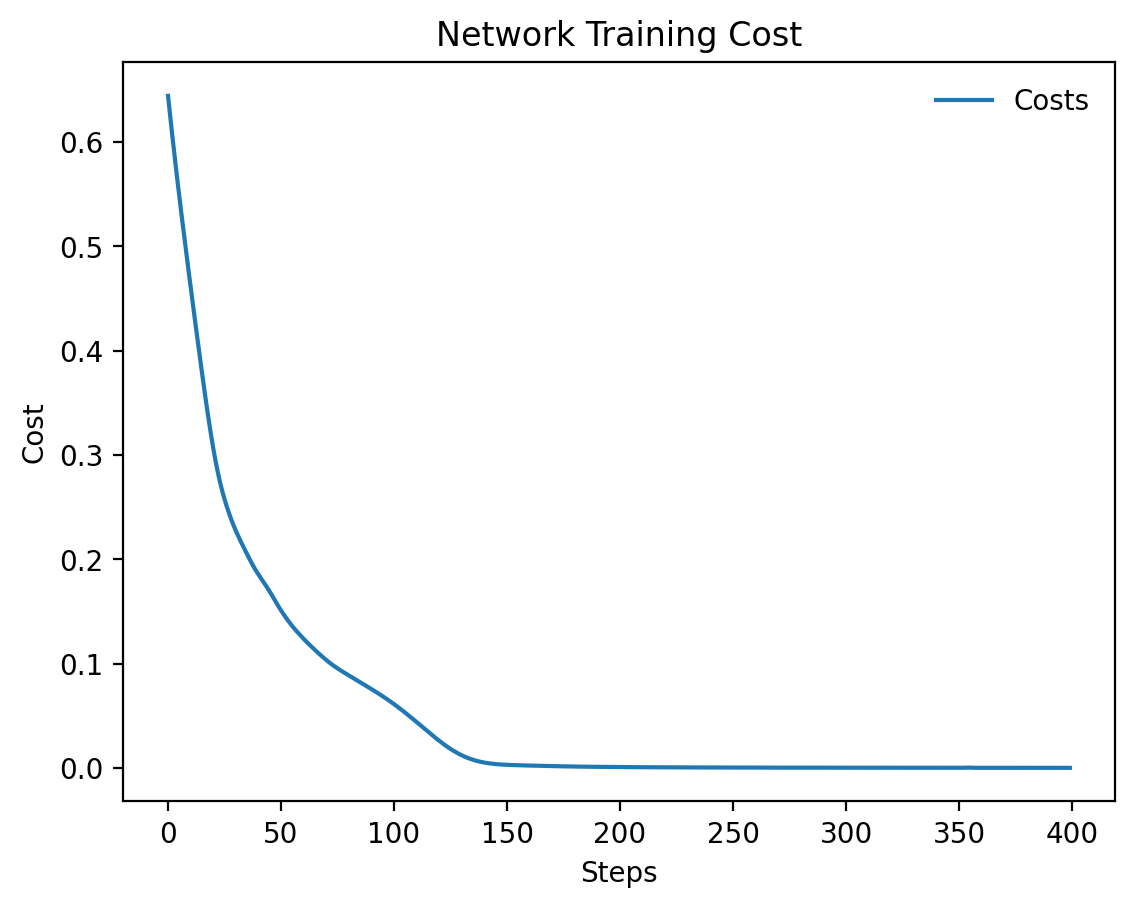

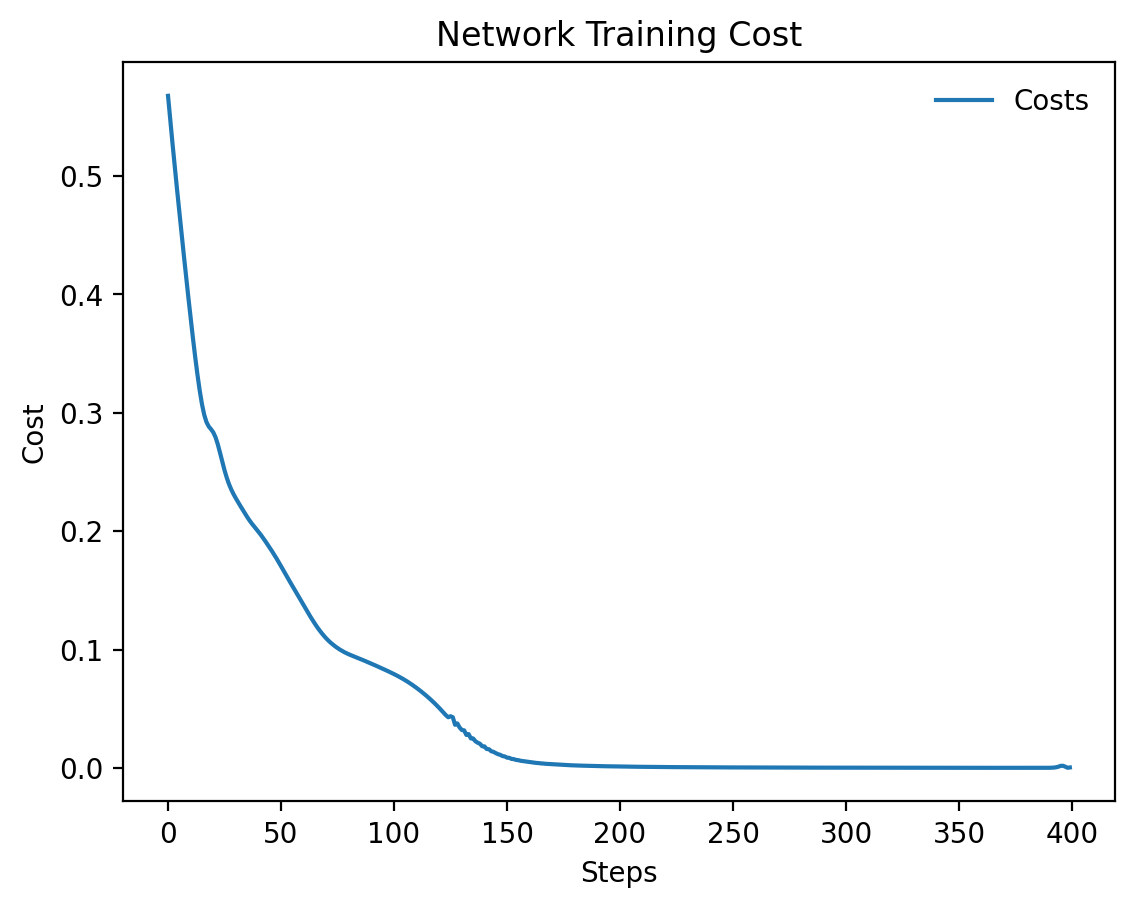

In [ ]:
# New offset to predict 100 into future
windowsize1= 30
offset1= 100
steps = 400

# Predicts future motion using function
costs3, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model2(x1, x2, y1, y2, windowsize, offset1,steps)

# Range of offsets
offsets1 = np.linspace(20,100,6)

# Initialize arrays to store theta values and final costs
final_costs = []

for offset in offsets1:
    x1, y1, x2, y2 = stability(np.pi/2, 0)
    costs3, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = build_model2(x1, x2, y1, y2, windowsize, offset1,steps)
    final_costs.append(costs3[-1])

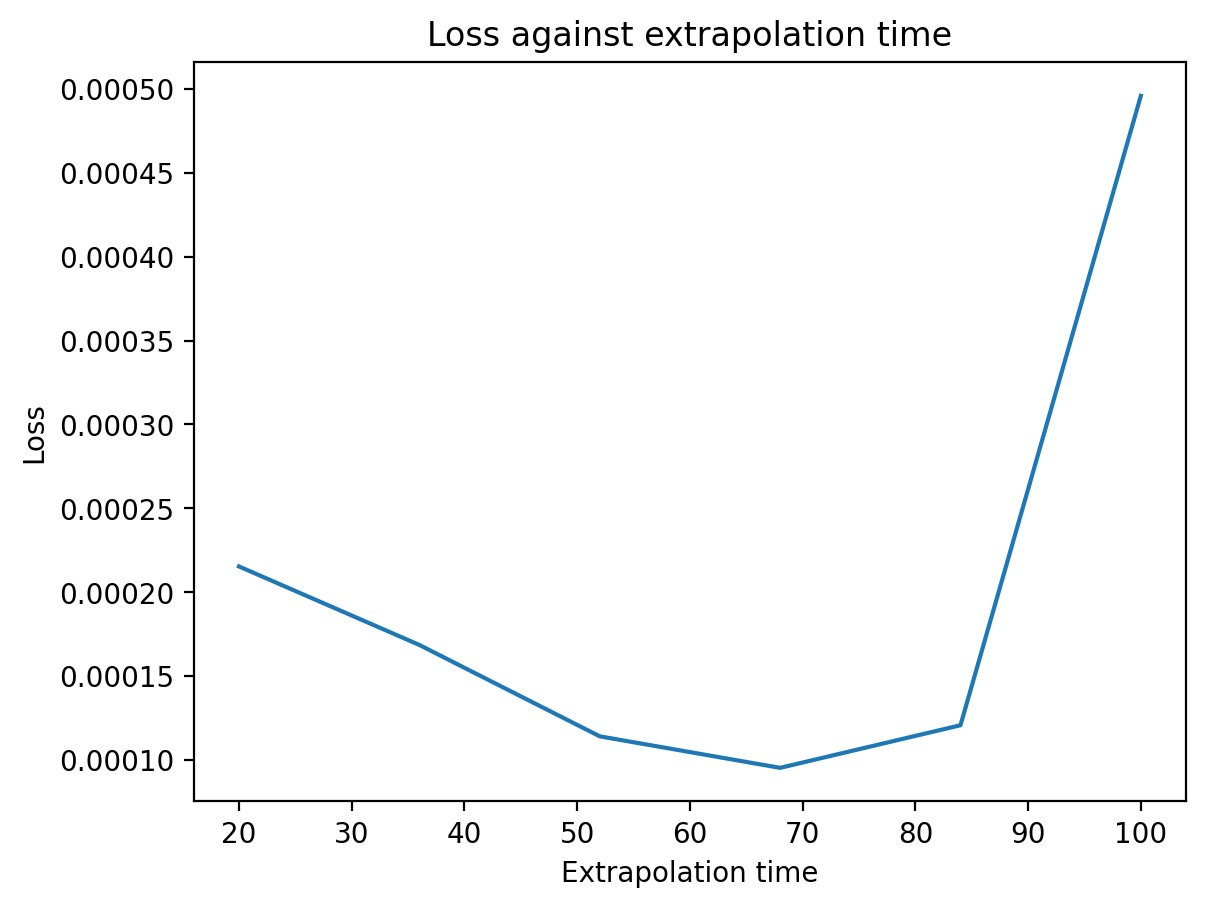

In [ ]:
plt.plot(offsets1, final_costs)
plt.xlabel("Extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()